# **Wine Quality Prediction**
### **A story-driven comparison of OLS, Lasso, and Random Forest**

In this project, we predict **white wine quality** (an ordered numeric score) from **physicochemical measurements**. We frame this as a **regression** task because we care about the **magnitude of prediction error** (e.g., being off by 0.5 quality points vs 2 points), not just whether the exact class is correct. We then build up from a trivial baseline to three increasingly flexible model families:


- **OLS (LinearRegression)**: a transparent linear benchmark  
- **Lasso / LassoCV**: linear models with **$\ell_1$** regularization (shrinkage + sparsity)  
- **Random Forest**: a non-linear model that captures interactions without manual feature engineering  

Two threads run through the workflow:

1. **Generalization:** we rank models primarily by **5-fold cross-validated MSE** (with a one-time holdout sanity check).  
2. **Understanding:** we explain models using the most appropriate lens: coefficients (linear), permutation importance + PDP (all models), and SHAP (tree models).

**Preview:** the tuned Random Forest achieves the lowest cross-validated error, while linear models remain valuable for clear directionality and quick diagnostics.

## Table of contents
1. Data overview & quality checks  
2. EDA: intuition and hypotheses  
3. Preprocessing + a baseline we can’t ignore  
4. OLS: a transparent linear benchmark  
5. Lasso: regularization, sparsity, stability  
6. Random Forest: non-linearity and interactions  
7. Validation + learning curves: bias/variance diagnostics  
8. Final comparison + conclusion  


In [13]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import time
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.linear_model import Lasso, LassoCV, LinearRegression, lasso_path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    learning_curve,
    train_test_split,
    validation_curve,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

RANDOM_STATE = 17
np.random.seed(RANDOM_STATE)

sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (10, 5)


In [14]:
def evaluate_regression(model, X_train, y_train, X_holdout, y_holdout, model_name, cv_folds=None):
    """Fit model, compute train/holdout metrics, and optionally CV MSE.

    Returns a dict suitable for building comparison tables.
    """
    model.fit(X_train, y_train)

    pred_train = model.predict(X_train)
    pred_holdout = model.predict(X_holdout)

    mse_train = mean_squared_error(y_train, pred_train) # Training MSE measures in-sample fit
    mse_holdout = mean_squared_error(y_holdout, pred_holdout) # Holdout MSE measures out-of-sample performance
    # If training error is much lower than holdout error, the model is likely overfitting.

    results = {
        "model": model_name,
        "train_mse": mse_train,
        "holdout_mse": mse_holdout,
        "holdout_rmse": np.sqrt(mse_holdout),
        "holdout_mae": mean_absolute_error(y_holdout, pred_holdout),
        "holdout_r2": r2_score(y_holdout, pred_holdout),
    }

    if cv_folds is not None:
        cv_scores = cross_val_score(
            model, X_train, y_train,
            scoring="neg_mean_squared_error",
            cv=cv_folds,
            n_jobs=-1
        )
        results["cv_mse"] = -cv_scores.mean()
        # results["cv_mse_std"] = cv_scores.std()  # still in neg scale; keep as spread indicator
        results["cv_mse_std"] = (-cv_scores).std()
    else:
        results["cv_mse"] = np.nan # np.nan means: “The cross-validated mean squared error does not exist for this model evaluation.”
        results["cv_mse_std"] = np.nan # np.nan means: “Cross-validation standard deviation is undefined because CV was not run.”

    return results


def compute_permutation_importance(model, X_holdout, y_holdout, feature_names, n_repeats=30, random_state=RANDOM_STATE):
    """Permutation importance expressed as ΔMSE on holdout (higher = more impact on error)."""
    imp = permutation_importance(
        model,
        X_holdout,
        y_holdout,
        n_repeats=n_repeats,
        random_state=random_state,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
    )
    # With scoring=neg MSE, "decrease in score" equals an *increase* in MSE.
    df = pd.DataFrame({
        "feature": feature_names,
        "delta_mse_mean": imp.importances_mean,
        "delta_mse_std": imp.importances_std,
    }).sort_values("delta_mse_mean", ascending=False).reset_index(drop=True)
    return df


def plot_permutation_importance(df_importance, top_k=12, title="Permutation importance (holdout): ΔMSE when permuted"):
    top = df_importance.head(top_k).iloc[::-1]
    plt.figure(figsize=(10, 6))
    plt.barh(top["feature"], top["delta_mse_mean"], xerr=top["delta_mse_std"])
    plt.title(title)
    plt.xlabel("Increase in MSE (ΔMSE)")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()


def plot_lasso_path(alphas, coefs, feature_names, top_k=10):
    """Plot coefficient trajectories vs log10(alpha) for the most dynamic features."""
    max_abs = np.max(np.abs(coefs), axis=1)
    top_idx = np.argsort(max_abs)[-top_k:][::-1] # Sort everything, take the biggest few, then flip them so the biggest comes first.

    plt.figure(figsize=(10, 6))
    for i in top_idx:
        plt.plot(np.log10(alphas), coefs[i], label=feature_names[i])

    plt.axhline(0, linewidth=1)
    plt.title("Lasso regularization path (top features by |coef| across the path)")
    plt.xlabel("log10(alpha)")
    plt.ylabel("Coefficient")
    plt.legend(loc="best", ncol=2, fontsize=9)
    plt.tight_layout()
    plt.show()


def bootstrap_lasso_stability(X_train, y_train, alpha, n_bootstraps=40, random_state=RANDOM_STATE, coef_eps=1e-8): # This function estimates: "How stable Lasso’s feature selection is" (i.e., how often each feature ends up with a non-zero coefficient under resampling)
    """Estimate stability: how often each feature survives (non-zero) under bootstrap resampling."""
    rng = np.random.RandomState(random_state)
    feature_names = list(X_train.columns)
    coefs = np.zeros((n_bootstraps, len(feature_names)))

    base_model = Pipeline([
        ("scaler", StandardScaler()),
        ("lasso", Lasso(alpha=alpha, random_state=random_state, max_iter=5000)),
    ])

    n = X_train.shape[0]
    for b in range(n_bootstraps):
        idx = rng.randint(0, n, size=n)  # bootstrap sample
        X_b = X_train.iloc[idx]
        y_b = y_train.iloc[idx]
        base_model.fit(X_b, y_b)
        coefs[b] = base_model.named_steps["lasso"].coef_

    selection_freq = (np.abs(coefs) > coef_eps).mean(axis=0)

    df = pd.DataFrame({
        "feature": feature_names,
        "selection_freq": selection_freq,
        "coef_mean": coefs.mean(axis=0),
        "coef_std": coefs.std(axis=0),
    }).sort_values(["selection_freq", "feature"], ascending=[False, True]).reset_index(drop=True)

    return df


def plot_validation_curve(
    estimator, X, y, param_name, param_range, scoring="neg_mean_squared_error", cv=5, title=None
):
    train_scores, valid_scores = validation_curve(
        estimator, X, y,
        param_name=param_name,
        param_range=param_range,
        scoring=scoring,
        cv=cv,
        n_jobs=-1
    )

    # Convert neg-MSE to MSE for readability
    train_mse = -train_scores
    valid_mse = -valid_scores

    train_mean = train_mse.mean(axis=1)
    train_std = train_mse.std(axis=1)
    valid_mean = valid_mse.mean(axis=1)
    valid_std = valid_mse.std(axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(param_range, train_mean, marker="o", label="Train MSE")
    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2)

    plt.plot(param_range, valid_mean, marker="o", label="CV MSE")
    plt.fill_between(param_range, valid_mean - valid_std, valid_mean + valid_std, alpha=0.2)

    plt.gca().invert_yaxis()  # lower MSE is better: visually "up"
    plt.xlabel(param_name)
    plt.ylabel("MSE (lower is better)")
    plt.title(title or f"Validation curve: {param_name}")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_learning_curve(
    estimator, X, y, scoring="neg_mean_squared_error", cv=5, train_sizes=np.linspace(0.1, 1.0, 8), title=None
):
    sizes, train_scores, valid_scores = learning_curve(
        estimator, X, y,
        scoring=scoring,
        cv=cv,
        n_jobs=-1,
        train_sizes=train_sizes,
        shuffle=True,
        random_state=RANDOM_STATE,
    )

    train_mse = -train_scores
    valid_mse = -valid_scores

    train_mean = train_mse.mean(axis=1)
    train_std = train_mse.std(axis=1)
    valid_mean = valid_mse.mean(axis=1)
    valid_std = valid_mse.std(axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(sizes, train_mean, marker="o", label="Train MSE")
    plt.fill_between(sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)

    plt.plot(sizes, valid_mean, marker="o", label="CV MSE")
    plt.fill_between(sizes, valid_mean - valid_std, valid_mean + valid_std, alpha=0.2)

    plt.gca().invert_yaxis()
    plt.xlabel("Training set size")
    plt.ylabel("MSE (lower is better)")
    plt.title(title or "Learning curve")
    plt.legend()
    plt.tight_layout()
    plt.show()


def print_df(df, title=None, float_format="{:.4f}", max_rows=None):
    """Pretty-print a DataFrame without relying on external display helpers."""
    if title is not None:
        print(title)
    if max_rows is not None and len(df) > max_rows:
        df_to_print = df.head(max_rows)
    else:
        df_to_print = df
    with pd.option_context("display.max_rows", None, "display.max_columns", None):
        # print(df_to_print.to_string(index=False))
        print(df_to_print.to_string(index=False, float_format=float_format.format))


<details>
<summary><span style="color:red"> 

about `evaluate_regression(...)`:</span></summary>  

**Purpose:** Train a regression model and return a compact summary of how well it performs.  

`evaluate_regression` is a model-evaluation helper.  
Its job is to take any regression model and answer three questions:   

   1) How well does the model fit the training data?  

   2) How well does it generalize to unseen data (holdout set)?

   3) How stable is its performance across different training splits (via CV), if requested?  

It returns all of this in a single, tidy dictionary so multiple models can be compared side by side.  

**What it does:**

1. **Fits** the model on `(X_train, y_train)`.

2. Makes predictions on:

   * the **training set** (to see how well it fits the data it learned from)
   * the **holdout set** (to estimate real-world performance)

3. Computes performance metrics:

   * **Train MSE** (mean squared error on training data)
   * **Holdout MSE** (mean squared error on holdout data)
   * **Holdout RMSE** = √MSE (same units as the target, easier to interpret)
   * **Holdout MAE** (mean absolute error; less sensitive to outliers than MSE)
   * **Holdout R²** (explained variance)

   This block builds a summary of complementary metrics:

      - MSE / RMSE → overall error magnitude

      - MAE → average absolute error (more robust to outliers)

      - R² → fraction of variance explained

      - Train vs holdout → fit vs generalization

   Together, these give a balanced picture instead of relying on a single number.  


<details>
<summary><span style="color:red">about R²:</span></summary>  

## Formula for $R^2$ (coefficient of determination)

$$
R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}
$$

## What each term means

* $y_i$: true observed value
* $\hat{y}_i$: model prediction
* $\bar{y}$: mean of the observed values
* $\sum (y_i - \hat{y}_i)^2$: **Residual Sum of Squares (RSS)**
* $\sum (y_i - \bar{y})^2$: **Total Sum of Squares (TSS)**

So you’ll often see it written as:

$$
R^2 = 1 - \frac{\text{RSS}}{\text{TSS}}
$$


## Intuition

* **TSS**: how much variance there is in the data if you predict the mean every time
* **RSS**: how much error your model still makes

$R^2$ answers:

> *“What fraction of the variance in $y$ does my model explain?”*


## Interpretation

* $R^2 = 1$: perfect predictions
* $R^2 = 0$: no better than predicting the mean
* $R^2 < 0$: worse than predicting the mean (can happen on holdout data)


## Why negative $R^2$ is possible

If:
$$
\sum (y_i - \hat{y}_i)^2 > \sum (y_i - \bar{y})^2
$$

then your model is doing worse than a constant-mean predictor.


## Connection to our code

This line:

```python
r2_score(y_holdout, pred_holdout)
```

computes exactly that formula on the **holdout set**.


## 1. How $R^2$ relates to MSE

Recall the formula:

$$
R^2 = 1 - \frac{\sum (y_i - \hat y_i)^2}{\sum (y_i - \bar y)^2}
$$

Now divide numerator and denominator by $n$:

$$
R^2 = 1 - \frac{\text{MSE}_{\text{model}}}{\text{Var}(y)}
$$

So:

* **Model MSE** = average squared prediction error
* **Var(y)** = MSE of a *baseline model* that always predicts the mean

>👉 **$R^2$ is a *relative* error reduction** compared to predicting the mean.

### Intuition

* $R^2 = 0.6$ → your model reduces squared error by **60%** vs the mean
* $R^2 < 0$ → your model increases error vs the mean


## 2. Why $R^2$ can be misleading

### (a) High $R^2$ ≠ good predictions

You can have:

* high $R^2$
* large RMSE

Example:

* predicting house prices across cities
* huge variance in prices → easy to get high $R^2$
* but absolute errors may still be large

>👉 Always report **RMSE / MAE alongside $R^2$**.


### (b) $R^2$ always improves when you add features (OLS)

For **ordinary least squares**:

* adding predictors **never decreases training $R^2$**

Even useless noise features will inflate it.

>👉 That’s why training $R^2$ is a terrible model-selection metric.


### (c) $R^2$ depends on target variance

Two datasets with identical errors can have very different $R^2$ values if:

* one has high variance in $y$
* the other has low variance

>So $R^2$ is **not comparable across datasets**.


### (d) Negative $R^2$ surprises people

On holdout data:

* negative $R^2$ is not a bug
* it’s a warning sign of poor generalization

This often happens with:

* overfitting
* extrapolation
* distribution shift


## 3. Adjusted $R^2$

### Formula

$$
\text{Adjusted } R^2
= 1 - (1 - R^2)\frac{n - 1}{n - p - 1}
$$

Where:

* $n$: number of observations
* $p$: number of predictors


### Why it exists

Adjusted $R^2$ penalizes adding predictors that don’t improve the model *enough*.

* If a new variable helps → adjusted $R^2$ goes **up**
* If it’s useless → adjusted $R^2$ goes **down**

### When to use it

Use **Adjusted $R^2$**:

* for **OLS**
* on the **training set**
* when comparing models with different numbers of predictors

Do **not** use it:

* for Random Forests
* for Lasso (regularization already handles complexity)
* as a substitute for test error


## 4. How this fits our project

Our current choices are actually ideal:

* **RMSE / MAE** → real-world prediction quality
* **$R^2$** → variance explained (contextual understanding)
* **CV MSE** → stability
* **Holdout MSE** → final honesty check

We’re using $R^2$ in the **right role**, not over-trusting it.

## Summary

> **MSE tells you how wrong you are.**
> **$R^2$ tells you how much better you are than guessing the mean.**

</details>

4. **Optional cross-validation on the training set**:

   * If `cv_folds` is provided, it runs `cross_val_score` with scoring `"neg_mean_squared_error"`.
   * scikit-learn returns **negative MSE** for this scorer (because it tries to “maximize” scores).
   * So the code flips the sign to get **positive CV MSE**.

**Output:** a dictionary like:

```python
{
  "model": "Lasso",
  "train_mse": ...,
  "holdout_mse": ...,
  "holdout_rmse": ...,
  "holdout_mae": ...,
  "holdout_r2": ...,
  "cv_mse": ...,
  "cv_mse_std": ...
}
```

This is handy for building a results table comparing OLS vs Lasso vs Random Forest, etc.

⚠️ Small note: `results["cv_mse_std"] = cv_scores.std()` is **still on the negative scale** (as your comment says). The spread is the same either way, but if you want it consistent you could store `(-cv_scores).std()`.



## Optional cross-validation (on training data only)

```python
if cv_folds is not None:
```

Cross-validation is **optional** and **explicitly controlled**.

When enabled:

```python
cv_scores = cross_val_score(
    model, X_train, y_train,
    scoring="neg_mean_squared_error",
    cv=cv_folds
)
```

This:

* repeatedly splits the **training set**
* trains on part of it
* validates on the remainder
* returns one MSE per fold

Why only training data?
Because CV is for **model assessment and stability**, not final evaluation.

## Summarize CV results

```python
results["cv_mse"] = -cv_scores.mean()
results["cv_mse_std"] = cv_scores.std()
```

* Mean CV MSE → **typical expected error**
* Standard deviation → **stability across folds**

This tells us:

* whether performance is reliable
* whether the model is sensitive to the specific data split


## Handle the no-CV case cleanly

```python
else:
    results["cv_mse"] = np.nan
    results["cv_mse_std"] = np.nan
```

If CV isn’t requested, the function:

* still returns the same dictionary structure
* avoids breaking downstream comparison code

This is good design.


## Return a clean comparison unit

```python
return results
```

The function returns a **single record** representing one model.
You can easily stack many of these into a DataFrame:

```python
pd.DataFrame([results_ols, results_lasso, results_rf])
```


## Why this design is good

* Separates **training**, **validation**, and **testing**
* Avoids data leakage
* Works for any sklearn-style regressor
* Encourages reporting **multiple metrics**
* Supports honest model comparison


## Summary

> *This function trains a regression model, evaluates its in-sample and out-of-sample performance using multiple error metrics, and optionally estimates performance stability via cross-validation, returning a compact summary suitable for model comparison.*

</details>


<details>
<summary><span style="color:red">permutation importance (ΔMSE)</span></summary>

Permutation importance answers:

> **If we shuffle one feature (breaking its relationship with the target), how much does predictive error increase?**

In this project we measure error as **holdout MSE**, using `scoring="neg_mean_squared_error"`.  
Because the scoring is “negative MSE”, the reported importance corresponds to an **increase in MSE (ΔMSE)**:

- larger **ΔMSE** → the model relied more on that feature to reduce error  
- near-zero **ΔMSE** → the feature is mostly redundant for the fitted model  

This is a model-agnostic “impact on error” lens that complements coefficients and tree importances.

</details>


<details>
<summary><span style="color:red"> 

about `compute_permutation_importance(...)`:</span></summary>  


## What this function is for (big picture)

`compute_permutation_importance` answers the question:

> **“Which features actually matter for this trained model’s predictions?”**

It does this using **permutation importance**, evaluated on the **holdout set**, and expresses importance as:

> **How much the model’s prediction error increases when a feature is randomly shuffled.**


## Why permutation importance is powerful

Unlike:

* raw coefficients (OLS, Lasso)
* built-in tree importances (which can be biased)

<details>
<summary><span style="color:red"> 

What “built-in tree importances” means:</span></summary> 

**No**!, SHAP is *not* what we meant there. Let’s cleanly separate these concepts, because they’re often mixed up.

## What “built-in tree importances” means

When people say **built-in tree feature importance**, they usually mean the importance values that come **directly from tree-based models**, for example:

* `DecisionTreeRegressor.feature_importances_`
* `RandomForestRegressor.feature_importances_`
* `ExtraTreesRegressor.feature_importances_`

These are computed **inside the training algorithm itself**.


## How built-in tree importances are calculated

For CART-style trees (used in Random Forests):

> **Feature importance = total reduction in impurity (e.g. MSE, Gini) caused by splits on that feature, averaged over all trees**

In other words:

* every time a feature is used to split a node
* the resulting reduction in loss is credited to that feature
* summed over the forest and normalized

<details>
<summary><span style="color:red"> 

What “CART-style trees” means:</span></summary> 

## What “CART-style trees” means

**CART** stands for:

> **Classification And Regression Trees**

A **CART-style tree** is a decision tree that has **these defining properties**:


## 1. Binary splits only

Every internal node splits the data into **exactly two branches**.

Examples:

* `alcohol ≤ 10.2` vs `> 10.2`
* `density ≤ 0.995` vs `> 0.995`

No multi-way splits.

This is different from algorithms like **ID3 / C4.5**, which can create multi-branch splits.

## 2. Greedy, top-down construction

The tree is built:

* from the root downward
* one split at a time
* choosing the split that **most reduces a loss function** *at that node*

Once a split is made, it is **never reconsidered**.

## 3. Impurity / loss-based splitting

CART chooses splits by minimizing:

* **Regression** → Mean Squared Error (MSE)
* **Classification** → Gini impurity (or entropy)

This is exactly what:

* `DecisionTreeRegressor`
* `RandomForestRegressor`

do in scikit-learn.


## 4. Piecewise-constant predictions

Each leaf node predicts:

* the **mean** of the target values (regression)
* the **majority class** (classification)

So the model is:

* non-linear
* but locally very simple


## Why Random Forests are “CART-style”

A **Random Forest** is just:

> *An ensemble of many CART trees trained on bootstrap samples with random feature selection.*

Each tree inside the forest is:

* a CART regression tree
* using binary splits
* minimizing MSE at each node

That’s why the built-in `feature_importances_` in Random Forests come from **CART impurity reduction**.


## Why this matters for feature importance

When you hear:

> *“Built-in tree importances are biased”*

That bias comes from **CART mechanics**:

* features with many possible split points get more chances to reduce impurity
* correlated features compete for splits
* importance reflects *how often* a feature was used, not *how predictions depend on it*

This is why permutation importance is often preferred for interpretation.


## CART vs other tree families (quick contrast)

| Algorithm | Binary splits | Loss-based | Used in sklearn RF |
| --------- | ------------- | ---------- | ------------------ |
| CART      | ✅             | ✅          | ✅                  |
| ID3       | ❌             | ❌          | ❌                  |
| C4.5      | ❌             | ❌          | ❌                  |
| CHAID     | ❌             | ❌          | ❌                  |



## Summary

> **CART-style trees are binary, loss-minimizing decision trees that form the backbone of scikit-learn’s Decision Trees and Random Forests.**

</details>



## Why they can be misleading

Built-in tree importances are **fast** and **convenient**, but they have known issues:

### 1. Bias toward high-cardinality features

Features with:

* many unique values
* continuous variables

get more chances to reduce impurity, even if they’re weak predictors.

<span style="font-size:24px; color:hotpink;">

Built-in tree importance reflects *how often* a feature was used, not *how predictions depend on it*

</span>


### 2. Correlated features get distorted credit

If two features are correlated:

* the tree may arbitrarily pick one
* the other appears unimportant
* or importance is split unpredictably


### 3. They measure *training behavior*, not prediction dependence

They reflect:

* how the tree was built
* not necessarily how predictions depend on features on unseen data


## What SHAP is (and why it’s different)

### SHAP ≠ built-in importance

SHAP (SHapley Additive exPlanations) is:

* a **post-hoc explanation method**
* based on cooperative game theory
* measures **each feature’s contribution to individual predictions**

SHAP:

* is model-agnostic (or has model-specific optimizations)
* works on predictions, not training splits
* is much more computationally expensive


## Relationship between the three methods

| Method                      | What it measures             | Model-agnostic | Uses holdout |
| --------------------------- | ---------------------------- | -------------- | ------------ |
| Tree `feature_importances_` | Split impurity reduction     | ❌              | ❌            |
| Permutation importance      | Increase in prediction error | ✅              | ✅            |
| SHAP                        | Contribution to predictions  | ✅              | Optional     |


## Why our permutation importance is a smart choice

Permutation importance:

* directly answers **“does this feature matter for predictions?”**
* avoids split-count bias
* aligns with our goal of **predictive usefulness**

That’s why it fits perfectly with our earlier insight:

> *importance is better judged by how much error changes when a feature is perturbed*


## Summary

> **“Built-in tree importances” are impurity-reduction scores computed during tree training, whereas SHAP and permutation importance are post-hoc methods that explain how features affect predictions.**

---

**No! Permutation importance and SHAP are *not* the same**, even though they’re often used for similar goals.


## High-level difference

| Aspect             | Permutation importance      | SHAP                                             |
| ------------------ | --------------------------- | ------------------------------------------------ |
| What it measures   | Change in **model error**   | Contribution to **predictions**                  |
| Unit               | ΔMSE, ΔRMSE, etc.           | Same unit as model output                        |
| Scope              | **Global** importance       | **Local** + global                               |
| Uses true labels   | ✅                           | ❌                                                |
| Model-agnostic     | ✅                           | ✅                                                |
| Computational cost | Low–moderate                | High                                             |
| Answers            | “Does this feature matter?” | “How did this feature affect *this prediction*?” |

They answer **different questions**.


## Permutation importance (what *our* code does)

Permutation importance asks:

> *If I destroy the information in this feature, how much worse do predictions get?*

Mechanism:

1. Measure baseline error
2. Shuffle one feature
3. Re-measure error
4. Error increase = importance

Interpretation:

* **Large ΔMSE** → feature is critical for accuracy
* **Near-zero ΔMSE** → feature adds little predictive value

This is a **performance-based** importance.


## SHAP (what it does)

SHAP asks:

> *For this specific prediction, how did each feature push the prediction up or down relative to the baseline?*

Mechanism:

* Treats features as “players” in a game
* Distributes the prediction among them fairly (Shapley values)

Interpretation:

* Positive SHAP → pushes prediction higher
* Negative SHAP → pushes prediction lower
* Values sum to the model prediction minus baseline

This is an **explanation-based** importance.


## Why they can disagree (important insight)

A feature can:

* have **large SHAP values**
* but **low permutation importance**

Meaning:

* the feature strongly affects individual predictions
* but the model could still perform almost as well without it

Conversely:

* a feature can have **high permutation importance**
* but small average SHAP values (spread over many observations)


## Global SHAP ≠ permutation importance

People often aggregate SHAP values:

```text
mean(|SHAP|)
```

This gives a **global ranking**, but it still measures:

* magnitude of influence
* not predictive necessity

So even “global SHAP” ≠ permutation importance.


## When to use which

### Use permutation importance when:

* your goal is **predictive usefulness**
* you want to justify model performance
* you’re comparing features across models

### Use SHAP when:

* you need **per-observation explanations**
* interpretability is a primary goal
* stakeholders ask “why this prediction?”


## Summary

> **Permutation importance measures how much a feature contributes to predictive accuracy, whereas SHAP explains how features contribute to individual predictions; they are complementary but not equivalent.**

For our project, permutation importance is actually the **more aligned choice** with our stated goal of balancing performance and understanding.

</details>


Permutation importance measures **real predictive contribution**, regardless of model type.

It works for:

* linear models
* tree-based models
* ensembles


## Step 1: Call `permutation_importance`

```python
imp = permutation_importance(
    model,
    X_holdout,
    y_holdout,
    n_repeats=n_repeats,
    random_state=random_state,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
)
```

### What happens here conceptually

For **each feature**, repeatedly:

1. Measure baseline performance on the holdout set
2. Randomly **shuffle that feature’s values**
3. Re-evaluate the model
4. Record how much performance worsens

This is done `n_repeats` times to reduce randomness.

step 2, "Randomly **shuffle that feature’s values**", is applied on the **holdout set** (the data we pass as `X_holdout`).

In our call:

```python
permutation_importance(model, X_holdout, y_holdout, ...)
```

scikit-learn computes the baseline score on `(X_holdout, y_holdout)`, then for each feature it **shuffles that feature’s column within `X_holdout` only**, keeping all other columns and `y_holdout` fixed, and measures how much the score (neg MSE) gets worse.

So:

* **Training set:** only used earlier to fit the model (`model.fit(X_train, y_train)`).
* **Holdout set:** where the **shuffling + re-scoring** happens.



## Why use the holdout set?

Because we want importance to reflect:

* **generalization behavior**
* not artifacts of training data

This avoids inflated or misleading importance scores.


## Why `scoring="neg_mean_squared_error"`?

* scikit-learn assumes **higher scores are better**
* MSE is an error (lower is better)
* so scikit-learn negates MSE

Important implication:

* a **drop in score** = **increase in MSE**

Our comment correctly explains this.


## Step 2: Interpret the output object

`imp` contains arrays:

* `importances_mean`: average change in score after permutation
* `importances_std`: variability across permutations

Because the score is **negative MSE**:

* a *positive* `importances_mean` means **MSE increased**
* larger values = feature is more important


## Step 3: Build a clean DataFrame

```python
df = pd.DataFrame({
    "feature": feature_names,
    "delta_mse_mean": imp.importances_mean,
    "delta_mse_std": imp.importances_std,
})
```

This makes the results human-readable and easy to analyze.

### Column meanings

* **feature**
  Name of the input variable

* **delta_mse_mean**
  Average increase in MSE when this feature is permuted
  → *larger = more important*

* **delta_mse_std**
  How sensitive that importance is to randomness


## Step 4: Rank features by importance

```python
.sort_values("delta_mse_mean", ascending=False)
.reset_index(drop=True)
```

This:

* sorts features from **most important to least**
* cleans up the index for presentation


## Step 5: Return the result

```python
return df
```

The function returns a tidy table that can be:

* plotted
* compared across models
* reported in a paper or notebook


## How to interpret the output (very important)

### Example interpretation

| feature   | delta_mse_mean |
| --------- | -------------- |
| alcohol   | 0.42           |
| density   | 0.15           |
| chlorides | 0.01           |

Means:

* permuting **alcohol** increases MSE by ~0.42 → very important
* permuting **chlorides** barely changes error → weakly useful


## Why this complements coefficients

A feature can:

* have a large coefficient
* but small permutation importance

That means:

* it has a strong *directional* effect
* but doesn’t actually help predictions much

This directly supports the insight we wrote earlier.


## Summary

> *Permutation importance measures the increase in holdout MSE caused by randomly permuting each feature, thereby quantifying each variable’s true contribution to predictive accuracy.*

</details>

<details>
<summary><span style="color:red">plotting ΔMSE and the Lasso path</span></summary>

- `plot_permutation_importance(...)` visualizes the top-k features ranked by **ΔMSE**, with error bars across permutation repeats.
- `plot_lasso_path(...)` shows how Lasso coefficients evolve as $\alpha$ changes (x-axis is $\log_{10}(\alpha)$):

  - small $\alpha$ → behaves like OLS (many non-zero coefficients)  
  - large $\alpha$ → stronger shrinkage → more coefficients drop to 0  

Together, these plots show **what matters for accuracy** (ΔMSE) and **how regularization changes the model** (coefficient path).

</details>


<details>
<summary><span style="color:red"> 

about `plot_permutation_importance(...)` and `plot_lasso_path(...)`:</span></summary>  


### Purpose

Make a **horizontal bar chart** of our permutation-importance table, showing the **top features** and how much permuting each one **increases MSE** on the holdout set.



> *Permutation importance measures the increase in holdout MSE caused by randomly permuting each feature, thereby quantifying each variable’s true contribution to predictive accuracy.* 


### How it works

```python
top = df_importance.head(top_k).iloc[::-1]
```

* Takes the **top `top_k`** rows (most important features) from `df_importance`.
* `iloc[::-1]` reverses them so the **most important ends up at the top** of a horizontal bar chart (matplotlib draws the first bar at the bottom).

```python
plt.figure(figsize=(10, 6))
```

* Creates a new figure of size 10×6 inches.

```python
plt.barh(top["feature"], top["delta_mse_mean"], xerr=top["delta_mse_std"])
```

* Draws horizontal bars:

  * y-axis labels = feature names
  * bar length = `delta_mse_mean` (average increase in MSE when that feature is shuffled)
  * `xerr` adds error bars showing `delta_mse_std` (variability across repeats)

```python
plt.title(title)
plt.xlabel("Increase in MSE (ΔMSE)")
plt.ylabel("")
```

* Adds title and x-axis label.
* Empty y-label to keep the plot clean.

```python
plt.tight_layout()
plt.show()
```

* `tight_layout()` prevents labels from being cut off.
* `show()` displays the plot.

### How to interpret the chart

* **Longer bar = more important feature**
* **Error bars** show uncertainty: big error bars mean importance varies across permutations.


## `plot_lasso_path(...)`

### Purpose

Plot the **Lasso regularization path**: how each feature’s coefficient changes as `alpha` changes.

This helps you see:

* which coefficients shrink to zero quickly
* which features remain “selected” over a wide range of regularization strengths

### Inputs

* `alphas`: list/array of Lasso regularization strengths
* `coefs`: coefficient values across the alphas (one coefficient per feature for each alpha)
* `feature_names`: list of feature names
* `top_k`: how many features to plot

### How it works

```python
max_abs = np.max(np.abs(coefs), axis=1)
```

* For each feature, finds the **largest absolute coefficient** it ever attains across the entire path.
* This tells you which features have the most “movement” / strongest presence at any point.

> Note: this assumes `coefs` is shaped like `(n_features, n_alphas)`, so `axis=1` collapses across alphas.

```python
top_idx = np.argsort(max_abs)[-top_k:][::-1] # Sort everything, take the biggest few, then flip them so the biggest comes first.
```

<details>
<summary><span style="color:red"> 

More on this:</span></summary>   

We have:

```python
max_abs
```

which is a 1D array like:

```python
max_abs = [0.02, 1.30, 0.15, 0.80, 0.05]
```

Each number = **how large a feature’s coefficient ever got** along the Lasso path.

We want:

> the indices of the **top `top_k` largest values**, ordered **from largest to smallest**.


## Step-by-step breakdown

### Step 1 — `np.argsort(max_abs)`

```python
np.argsort(max_abs)
```

Returns the **indices that would sort the array in ascending order**.

Example:

```python
max_abs = [0.02, 1.30, 0.15, 0.80, 0.05]
np.argsort(max_abs)
# → [0, 4, 2, 3, 1]
```

This means:

* smallest value is at index 0
* largest value is at index 1


### Step 2 — `[-top_k:]`

```python
np.argsort(max_abs)[-top_k:]
```

This slices the **last `top_k` indices**, i.e. the indices of the **largest values**.

If `top_k = 3`:

```python
[0, 4, 2, 3, 1][-3:]
# → [2, 3, 1]
```

These correspond to the three largest `max_abs` values (but not yet ordered).

### Step 3 — `[::-1]`

```python
np.argsort(max_abs)[-top_k:][::-1]
```

This reverses the order so they go from **largest to smallest**.

```python
[2, 3, 1][::-1]
# → [1, 3, 2]
```

Now:

* index `1` → largest coefficient
* index `3` → second largest
* index `2` → third largest

## Final result

`top_idx` is:

> **Indices of the `top_k` most important features, ordered by decreasing maximum coefficient magnitude.**

We then use those indices here:

```python
plt.plot(np.log10(alphas), coefs[i], label=feature_names[i])
```

to plot only the most interesting Lasso paths.


## Why not sort descending directly?

NumPy’s `argsort` always sorts ascending.
This pattern:

```python
np.argsort(x)[-k:][::-1]
```

is a very common idiom to get **top-k largest values** efficiently and clearly.

</details>

* Sorts features by that `max_abs` value.
* Takes the indices of the top `top_k`.
* Reverses so it goes from most to less.

```python
plt.figure(figsize=(10, 6))
```

* Creates a plot.

```python
for i in top_idx:
    plt.plot(np.log10(alphas), coefs[i], label=feature_names[i])
```

* For each selected feature index `i`:

  * plots coefficient value vs `log10(alpha)`
  * labels the line with the feature name

`log10(alpha)` is used because alpha usually spans orders of magnitude (e.g., 1e-4 to 1e1).

```python
plt.axhline(0, linewidth=1)
```

* Draws a horizontal zero line so it’s easy to see when coefficients cross or hit zero.

```python
plt.title("Lasso regularization path (top features by |coef| across the path)")
plt.xlabel("log10(alpha)")
plt.ylabel("Coefficient")
```

* Labels.

```python
plt.legend(loc="best", ncol=2, fontsize=9)
```

* Adds a legend with two columns to avoid clutter.

```python
plt.tight_layout()
plt.show()
```

* Displays the plot.

### How to interpret a Lasso path plot

* Moving right (larger alpha) → **stronger regularization**
* Coefficients **shrink toward 0**
* If a feature’s line hits **exactly 0**, Lasso has effectively **dropped** that feature
* Features that stay non-zero longer are often more robust predictors

<details>
<summary><span style="color:red"> 

The formula of the Lasso optimization problem:</span></summary>   

## The Lasso optimization problem (the formula)

For a given regularization strength $\alpha$, **Lasso regression** solves:

$$
\hat{\boldsymbol{\beta}}(\alpha)
=
\arg\min_{\boldsymbol{\beta}}
\left\{
\frac{1}{2n}
\sum_{i=1}^{n}
\left(y_i - \mathbf{x}_i^\top \boldsymbol{\beta}\right)^2
+
\alpha \sum_{j=1}^{p} |\beta_j|
\right\}
$$


## What each symbol means

* $n$: number of observations
* $p$: number of features
* $y_i$: true target value
* $\mathbf{x}_i$: feature vector for observation $i$
* $\boldsymbol{\beta} = (\beta_1, \dots, \beta_p)$: coefficient vector
* First term → **data fit (MSE)**
* Second term → **$\ell_1$ penalty** (Lasso regularization)
* $\alpha \ge 0$: regularization strength


## What the *regularization path* is

The **Lasso regularization path** is the collection:  


$$\left\{\hat{\boldsymbol{\beta}}(\alpha):\alpha \in [0, \infty)\right\}$$

In words:

> For each value of $\alpha$, solve the Lasso problem and record the coefficients.

Your plot shows:

$$
\beta_j(\alpha)
\quad \text{vs} \quad
\log_{10}(\alpha)
$$

for each feature $j$.


## Why coefficients go to zero (key mathematical insight)

The $\ell_1$ penalty:

$$
\sum_{j=1}^{p} |\beta_j|
$$

has **sharp corners** at zero.
Because of this geometry, the optimizer often lands **exactly at $\beta_j = 0$**.

That’s why Lasso performs **feature selection**.

## Important limiting cases

### 1. $\alpha = 0$

$$
\hat{\boldsymbol{\beta}}(0) = \text{OLS solution}
$$

No regularization.


### 2. $\alpha \to \infty$

$$
\hat{\boldsymbol{\beta}}(\alpha) \to \mathbf{0}
$$

All coefficients shrink to zero.


## Why the x-axis is $\log_{10}(\alpha)$

Because meaningful behavior happens across **orders of magnitude**:

$$
\alpha \in \{10^{-4}, 10^{-3}, \dots, 10^{1}\}
$$

Plotting on a log scale reveals when coefficients:

* enter the model
* shrink
* disappear


## Summary

> *The Lasso path plots the solution $\hat{\beta}_j(\alpha)$ of the $\ell_1$-regularized least squares problem as a function of the regularization strength $\alpha$, illustrating how coefficients shrink and are set to zero as regularization increases.*

This is exactly what our `plot_lasso_path(...)` function visualizes.


</details>



</details>


<details>
<summary><span style="color:red">bootstrap stability + validation curves</span></summary>

- `bootstrap_lasso_stability(...)` fits the same Lasso model on many **bootstrap resamples** of the training data and records how often each coefficient is non-zero.

  - high selection frequency → the feature survives resampling (more robust)  
  - low frequency → selection is fragile (sample-dependent)

- `plot_validation_curve(...)` plots **train vs CV error** as a hyperparameter varies. It helps diagnose bias/variance:

  - both curves high → underfitting  
  - train low + CV high → overfitting / high variance  

</details>


<details>
<summary><span style="color:red"> 

about `bootstrap_lasso_stability(...)` and `plot_validation_curve(...)`:</span></summary>  

> *The Lasso path plots the solution $\hat{\beta}_j(\alpha)$ of the $\ell_1$-regularized least squares problem as a function of the regularization strength $\alpha$, illustrating how coefficients shrink and are set to zero as regularization increases.*


## 1) `bootstrap_lasso_stability(...)`

### What problem it solves

Lasso can “select” features by setting some coefficients exactly to **0**.
But with noisy data, **which features get selected can change a lot** if we slightly change the training sample.

This function estimates:

> **How stable Lasso’s feature selection is**
> (i.e., how often each feature ends up with a non-zero coefficient under resampling)

### The core idea: bootstrap resampling

A **bootstrap sample** is made by sampling rows from the training set **with replacement**, same size as the original training set. Some rows repeat, some are left out.

We do this many times, fit Lasso each time, and see which features survive.

### What the code does

* Creates a random number generator (`rng`) for reproducibility.

* Grabs feature names from `X_train.columns` (so `X_train` must be a pandas DataFrame). (`.columns` gives us the names of the features as a pandas Index; converting it to a list just makes it easier to work with.)

* Prepares a 2D array `coefs` to store Lasso coefficients:

  * shape = `(n_bootstraps, n_features)`

* Builds a pipeline:

  * `StandardScaler()` (important: Lasso is scale-sensitive. in general, OLS is sensitive to outliers and scale)
  * `Lasso(alpha=alpha, ...)`

* For each bootstrap iteration:

  1. sample indices `idx` of length `n` using `randint(0,n,size=n)` → sampling with replacement
  2. create bootstrapped datasets `X_b`, `y_b`
  3. fit the pipeline on `(X_b, y_b)`
  4. store the learned Lasso coefficients in `coefs[b]`

### The “stability” metric

```python
selection_freq = (np.abs(coefs) > coef_eps).mean(axis=0)
```

For each feature:

* check in each bootstrap run if its coefficient magnitude is bigger than a tiny threshold (`coef_eps`)
* average across runs

So `selection_freq` is a number between 0 and 1:

* **1.0** → always selected (very stable)
* **0.0** → never selected
* **0.3** → selected in 30% of bootstraps (unstable/weak)

### The returned DataFrame

It returns a table with:

* `selection_freq`: stability score
* `coef_mean`: average coefficient across bootstraps
* `coef_std`: how much coefficient varies

Sorted so the most stable features appear first.

✅ This is a great way to avoid over-interpreting a single Lasso fit.


# 2) `plot_validation_curve(...)`

### What problem it solves

When you tune a hyperparameter (like Lasso `alpha`, RF `max_depth`, etc.), you want to see:

* how training error changes with that parameter
* how cross-validation error changes
* where underfitting vs overfitting happens

This function plots a **validation curve**: error vs hyperparameter value.

### What the code does

#### It calls scikit-learn’s `validation_curve`

```python
train_scores, valid_scores = validation_curve(...)
```

For each value in `param_range`:

* Train the estimator on CV training folds → compute `train_scores`
* Evaluate on CV validation folds → compute `valid_scores`

Each of these is a matrix:

* rows = different parameter values
* columns = CV folds

#### Converts negative MSE to MSE

Because scoring is `"neg_mean_squared_error"`:

* more positive is “better” in sklearn’s scoring world
* but humans want **MSE** (lower is better)

So it flips the sign:

```python
train_mse = -train_scores
valid_mse = -valid_scores
```

#### Computes mean and variability across folds

For each parameter value:

* mean MSE across CV folds
* std dev across folds

#### Plots two curves with uncertainty bands

* **Train MSE** curve (with shaded ±1 std band)
* **CV MSE** curve (with shaded ±1 std band)

#### Inverts y-axis

```python
plt.gca().invert_yaxis()
```

So “better” (lower MSE) appears visually higher. This is stylistic but common.

### How to interpret the plot

* If **Train MSE low** but **CV MSE high** → overfitting (model too flexible)
* If both are high → underfitting (model too constrained)
* You typically pick a parameter near the **minimum CV MSE**, balancing complexity and stability.


## Quick practical example for our project

* For **Lasso**, we’d vary `alpha` and pick the alpha with the lowest CV MSE.
* For **Random Forest**, we might vary `max_depth` or `min_samples_leaf`.


## One small note  

In `bootstrap_lasso_stability`, `coef_eps=1e-8` is fine, but sometimes people use `1e-6` to avoid counting tiny numerical noise as “selected.” Not required, just a tuning choice.

</details>

<details>
<summary><span style="color:red">learning curves + pretty printing</span></summary>

- `plot_learning_curve(...)` shows how train vs CV error change as we increase training-set size. It helps answer: *would more data likely help?*
- `print_df(...)` prints DataFrames cleanly in notebooks without extra display helpers.

</details>


<details>
<summary><span style="color:red"> 

about `plot_learning_curve(...)` and `print_df(...)`:</span></summary>  


## `plot_learning_curve(...)`

### What a learning curve answers

A learning curve shows how model performance changes as you give it **more training data**. It helps you diagnose:

* **Underfitting** (model too simple)
* **Overfitting** (model too complex)
* Whether **more data would help**

### What the code does

#### 1) Run scikit-learn’s `learning_curve`

```python
sizes, train_scores, valid_scores = learning_curve(...)
```

For each training size in `train_sizes` (default: 8 points from 10% to 100% of the data):

* take a subset of the training data of that size
* fit the estimator
* compute a **training score**
* compute a **cross-validation score** (validation score)

Outputs:

* `sizes`: actual numbers of training samples used (e.g., [320, 640, 960, ...])
* `train_scores`: matrix of scores for each size across CV folds
* `valid_scores`: matrix of CV validation scores for each size across folds

Important parameters:

* `cv=cv`: number of folds (default 5)
* `shuffle=True`: shuffles before taking subsets (reduces ordering bias)
* `random_state=RANDOM_STATE`: makes shuffling reproducible
* `n_jobs=-1`: uses all CPU cores

#### 2) Convert “negative MSE” to normal MSE

```python
train_mse = -train_scores
valid_mse = -valid_scores
```

Because `scoring="neg_mean_squared_error"` returns **negative** numbers (sklearn convention), we flip the sign to get standard MSE (lower is better).

#### 3) Compute mean and variability across folds

```python
train_mean = train_mse.mean(axis=1)
train_std  = train_mse.std(axis=1)
valid_mean = valid_mse.mean(axis=1)
valid_std  = valid_mse.std(axis=1)
```

For each training size:

* average performance across folds
* standard deviation across folds (how variable it is)

#### 4) Plot the learning curve

* Line 1: **Train MSE** vs training size
* Shaded band: ±1 standard deviation
* Line 2: **CV MSE** vs training size
* Shaded band: ±1 standard deviation

```python
plt.gca().invert_yaxis()
```

This flips the y-axis so “better” (lower MSE) appears visually higher.

### How to interpret the plot (key patterns)

**A) Overfitting**

* Train MSE is very low
* CV MSE is much higher
* Gap stays large
  ➡️ Model too complex or needs more regularization. More data *may* help.

**B) Underfitting**

* Train MSE and CV MSE are both high and close together
  ➡️ Model too simple; change model/features.

**C) More data helps**

* CV MSE keeps improving as training size grows
  ➡️ More data likely improves performance.

**D) More data won’t help much**

* CV MSE plateaus early
  ➡️ Better model/features matter more than more data.

## `print_df(df, title=None, float_format="{:.4f}", max_rows=None)`

### Purpose

Print a pandas DataFrame cleanly in the console, without needing notebook display tools.

### What it does

1. Optional title

```python
if title is not None:
    print(title)
```

2. Optional row limiting

```python
if max_rows is not None and len(df) > max_rows:
    df_to_print = df.head(max_rows)
else:
    df_to_print = df
```

If the DataFrame is long, print only the first `max_rows`.

3. Temporarily show all rows/columns (for printing)

```python
with pd.option_context("display.max_rows", None, "display.max_columns", None):
```

This context manager temporarily changes pandas display settings so your printed output isn’t truncated.

4. Print the DataFrame as a nicely formatted string

```python
print(df_to_print.to_string(index=False))
```

* `index=False` hides the DataFrame index column in the printout.

### Note

You pass `float_format` but you don’t actually use it in `to_string(...)`. If you wanted it to apply, you’d do:

```python
print(df_to_print.to_string(index=False, float_format=float_format.format))
```

But it’s optional, our current function still works fine.

</details>

## **1) Data overview & quality checks**

Before we model anything, we do a quick audit:  
**what columns we have, whether anything is missing, and whether duplicates exist**.  
This step isn’t glamorous, but it prevents “mysterious” behavior later.

We’ll use the white-wine subset of the classic UCI Wine Quality dataset (loaded from the mlcourse.ai repository).

**Goals of this step**
- Confirm the dataset schema and types early (it shapes every downstream choice).
- Check missingness and duplicates so evaluation reflects modeling, not data quirks.
- Look at the target distribution to understand what “good performance” even means.


Dataset shape: (4898, 12)

Head (first 5 rows):
 fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  free sulfur dioxide  total sulfur dioxide  density   pH  sulphates  alcohol  quality
           7.0              0.27         0.36            20.7      0.045                 45.0                 170.0   1.0010 3.00       0.45      8.8        6
           6.3              0.30         0.34             1.6      0.049                 14.0                 132.0   0.9940 3.30       0.49      9.5        6
           8.1              0.28         0.40             6.9      0.050                 30.0                  97.0   0.9951 3.26       0.44     10.1        6
           7.2              0.23         0.32             8.5      0.058                 47.0                 186.0   0.9956 3.19       0.40      9.9        6
           7.2              0.23         0.32             8.5      0.058                 47.0                 186.0   0.9956 3.19       0.40      9.9        

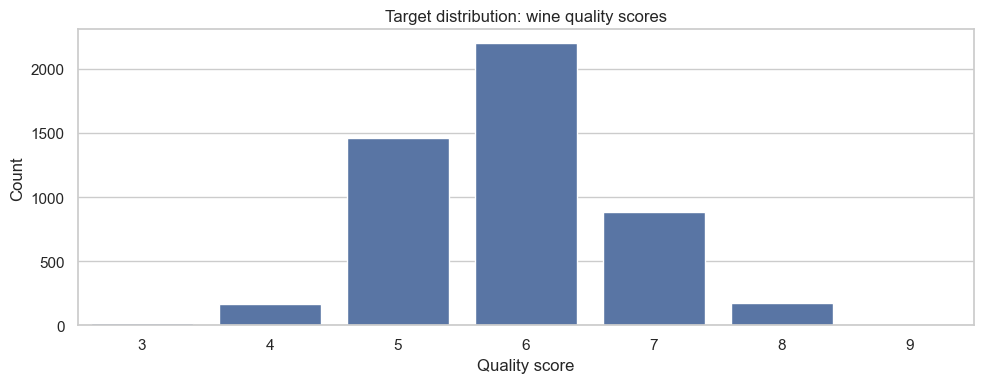

In [15]:
DATA_URL = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/winequality-white.csv"
LOCAL_PATH = Path("./Data/winequality-white.csv")  # will cache locally after first successful download


def load_wine_data(url=DATA_URL, local_path=LOCAL_PATH, sep=";", retries=5, backoff=2):
    # 1) If already cached locally, use it
    if local_path.exists():
        return pd.read_csv(local_path, sep=sep)

    # 2) Otherwise, try downloading with retries
    last_err = None
    for i in range(retries):
        try:
            df = pd.read_csv(url, sep=sep)
            # cache for next time
            df.to_csv(local_path, sep=sep, index=False)
            return df
        except Exception as e:
            last_err = e
            time.sleep(backoff ** i)  # exponential backoff

    # 3) If download fails, give a clear error with next steps
    raise RuntimeError(
        f"Failed to download dataset after {retries} retries.\n"
        f"Last error: {last_err}\n\n"
        f"Fix options:\n"
        f"- Try again later (network/GitHub can be flaky)\n"
        f"- Manually download the CSV and place it next to this notebook as: {local_path.name}\n"
    )

data = load_wine_data()
print("Dataset shape:", data.shape)
print("\nHead (first 5 rows):")
print(data.head().to_string(index=False))

print("\nData types and non-null counts:")
data.info()

print("\nMissing values per column:")
missing = data.isna().sum().to_frame("missing_count").T
print(missing.to_string(index=False))

dup_count = data.duplicated().sum()
print(f"\nDuplicate rows: {dup_count:,} ({dup_count / len(data):.2%} of the dataset)")

# Target distribution
plt.figure(figsize=(10, 4))
sns.countplot(x="quality", data=data)
plt.title("Target distribution: wine quality scores")
plt.xlabel("Quality score")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


<details>
<summary><span style="color:red">about this block:</span></summary>  


## 1) Define where to get the data (online + local cache)

```python
DATA_URL = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/winequality-white.csv"
LOCAL_PATH = Path("../Data4/winequality-white.csv")
```

* `DATA_URL` is the direct link to the CSV file on GitHub (raw file).
* `LOCAL_PATH` is where we want to save a local copy **after** successfully download it once.

  * This is a **cache**: next time we run the notebook, it can load locally without depending on the internet.


## 2) Define a loader function with retry + caching logic

```python
def load_wine_data(url=DATA_URL, local_path=LOCAL_PATH, sep=";", retries=5, backoff=2):
```

This function loads the dataset either:

* from disk (fast, offline), or
* from the web (with retries), then saves it.

Parameters:

* `sep=";"`: the dataset uses semicolons as separators (common for this dataset).
* `retries=5`: try up to 5 times if download fails.
* `backoff=2`: wait longer after each failed attempt (exponential backoff).


### Step A: Use the cached file if it exists

```python
if local_path.exists():
    return pd.read_csv(local_path, sep=sep)
```

* If the file is already saved at `LOCAL_PATH`, it immediately loads it with `pandas.read_csv` and returns the DataFrame.


### Step B: Otherwise, try downloading (with retries)

```python
last_err = None
for i in range(retries):
    try:
        df = pd.read_csv(url, sep=sep)
        df.to_csv(local_path, sep=sep, index=False)
        return df
    except Exception as e:
        last_err = e
        time.sleep(backoff ** i)
```

What happens here:

* It loops `retries` times.
* Inside the `try` block:

  * `pd.read_csv(url, sep=sep)` downloads and reads the CSV directly into a DataFrame.
  * `df.to_csv(local_path, ...)` saves it locally for future runs.
  * returns the DataFrame immediately if successful.
* If it fails:

  * saves the error in `last_err`
  * waits before retrying using **exponential backoff**:

    * `backoff ** i` gives waits like `1, 2, 4, 8, 16...` seconds (depending on `i`)

This reduces “hammering” GitHub and helps recover from temporary network hiccups.


### Step C: If all retries fail, raise a clear error

```python
raise RuntimeError(...)
```

This throws a helpful message that:

* tells us how many retries were attempted,
* shows the final error,
* suggests fixes (try later or download manually).


## 3) Load data and print basic diagnostics

```python
data = load_wine_data()
print("Dataset shape:", data.shape)
```

* Loads the dataset into `data`.
* Prints the shape: `(rows, columns)`.


### Preview first 5 rows

```python
print(data.head().to_string(index=False))
```

* Shows the first 5 rows without the index column, so it looks cleaner.  

`.to_string()` is a pandas method that converts a DataFrame (or Series) into a plain text string so it prints nicely in the console.

### Data types + non-null counts

```python
data.info()
```

* Displays:

  * each column name,
  * its dtype (`float64`, `int64`, etc.),
  * how many non-null values it has.

Good for confirming parsing worked and whether there areany missing values.


### Missing values per column

```python
missing = data.isna().sum().to_frame("missing_count").T
print(missing.to_string(index=False))
```
1. **`data.isna()`**
   Creates a DataFrame of the same shape as `data`, but with **True/False**:

* `True` where the value is missing (`NaN`)
* `False` where it’s present

2. **`.sum()`**
   When you sum booleans in pandas:

* `True` counts as 1
* `False` counts as 0

So this gives us the **number of missing values per column** (a Series like: `fixed acidity: 0`, `pH: 0`, ...).

3. **`.to_frame("missing_count")`**
   Converts that Series into a DataFrame with **one column**, named `"missing_count"`.

So instead of a Series, we now have a table like:

```
                     missing_count
fixed acidity                    0
volatile acidity                 0
...
```

4. **`.T`** (transpose)
   Flips rows and columns so it becomes a **single row** with many columns:

```
fixed acidity  volatile acidity  ...  quality
0             0                 ...  0
```

### Why do this?

It’s mainly for **pretty printing**: one compact row showing missing counts for every column.


### Count duplicate rows

```python
dup_count = data.duplicated().sum()
print(f"...")
```

* `data.duplicated()` marks rows that are exact duplicates of earlier rows.
* `.sum()` counts them.

This is important because duplicates can inflate performance if the same row appears in train and holdout.


## 4) Plot the target distribution

```python
sns.countplot(x="quality", data=data)
```

* Creates a bar chart showing how many wines are labeled 3, 4, 5, 6, etc.
* This helps us understand:

  * imbalance (most wines are 5–6),
  * what a “naive baseline” might achieve,
  * how hard it will be to predict extreme scores.

If you want the equivalent using matplotlib, you’d do something like:

```python
counts = data["quality"].value_counts().sort_index() # If you don’t use .sort_index(), the bars will be plotted in the order returned by value_counts(), which is descending by frequency, not in numeric order of the quality scores.
plt.bar(counts.index, counts.values)
plt.xlabel("Quality score")
plt.ylabel("Count")
plt.title("Target distribution: wine quality scores")
plt.show()
```

</details>

### **What the initial data audit tells us**  

The dataset has **4,898 rows and 12 columns**. Each row is one wine sample described by **11 physicochemical measurements** and a target label, **`quality`**.

A few quick observations from the printout:

### **Schema and data types**
- All **11 predictors** are `float64`.
- The target `quality` is an `int64` score.

That’s ideal: no categorical encoding, no type-cleaning, and scaling/pipelines will work cleanly.

### **Missing values**
Every column has **0 missing values**, so we don’t need imputation. Any limitations we see later are much more likely to be about *model capacity* and *signal-to-noise* than data hygiene.

### **Duplicate rows**
We have **937 duplicate rows (~19%)**. This is common in this dataset (identical lab measurements can repeat), but it matters because duplicates can inflate performance if they land in both train and holdout folds.

We’ll keep them for now (to stay consistent with most benchmark setups), but we’ll be mindful of this when interpreting small performance differences.

### **Target distribution (wine quality)**
The distribution is concentrated around **scores 5 and 6**, with relatively few wines at the extremes. That implies:
- a naive “predict-the-average” baseline can look deceptively strong,
- and predicting rare high-quality wines will be harder and noisier.

**Where we go next**   
the data is clean enough to model, so the next step is to build intuition: *which measurements look plausibly connected to perceived quality?* That’s the job of EDA.


## **2) EDA: building intuition and hypotheses**

Now that the dataset looks sane, the next step is to ask: *what signals might plausibly drive quality?*  
EDA is where we turn domain-tinged intuition into testable modeling expectations.

We’ll do three quick passes:
1. A correlation heatmap to visualize broad linear relationships, including redundancy (i.e., features that carry overlapping information).
2. A few feature-vs-quality plots to spot monotonic vs non-monotonic patterns.
3. Distributions for a handful of variables to understand scale, skew, and outliers.

We’ll treat what we see here as **hypotheses**, not conclusions, later models will test them.


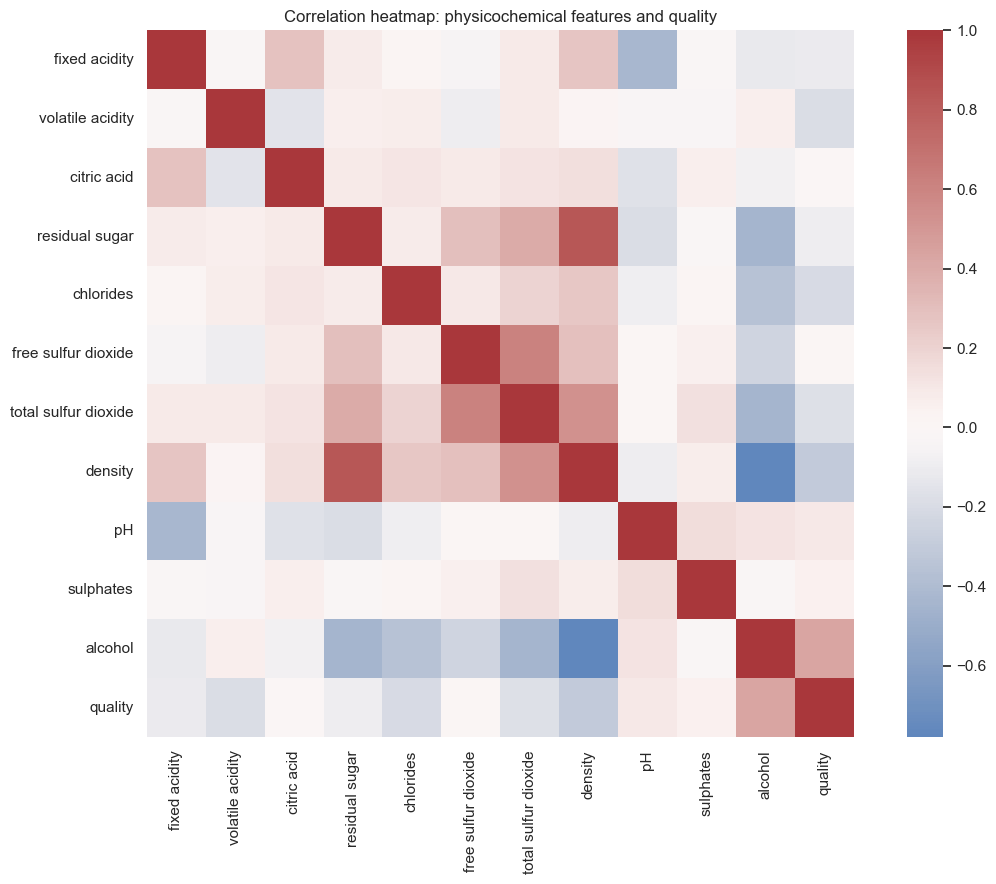

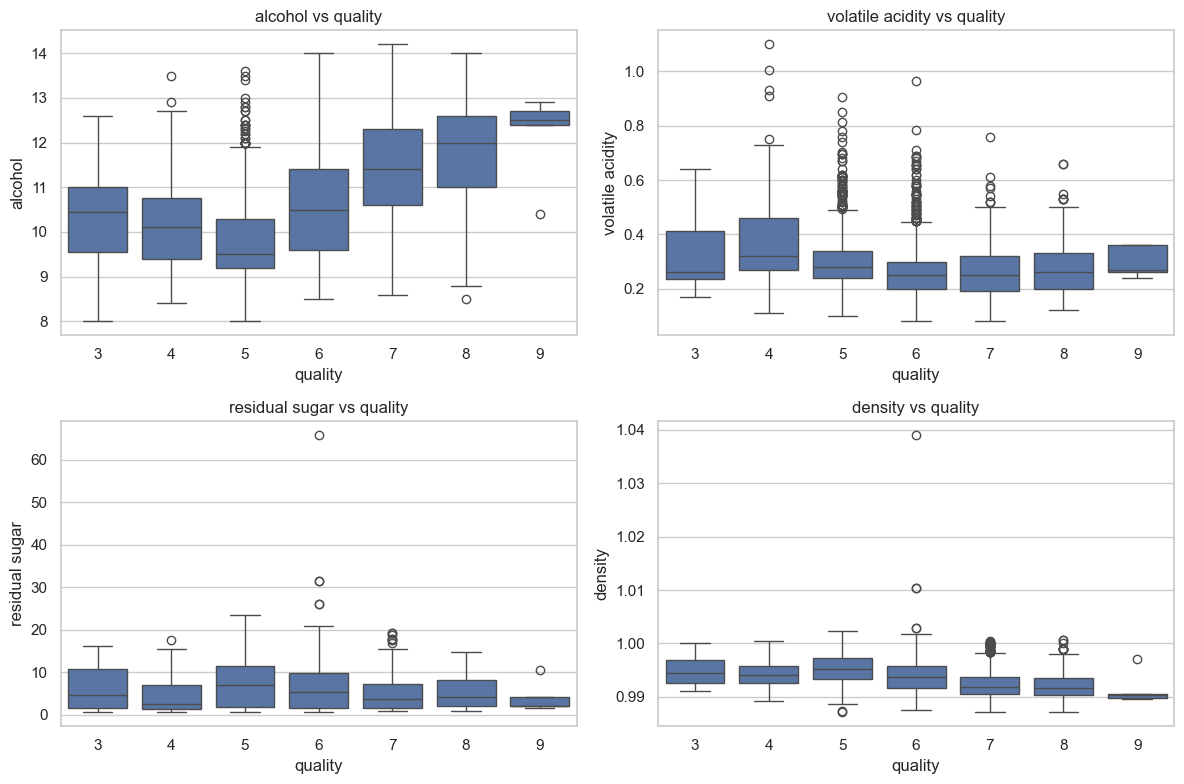

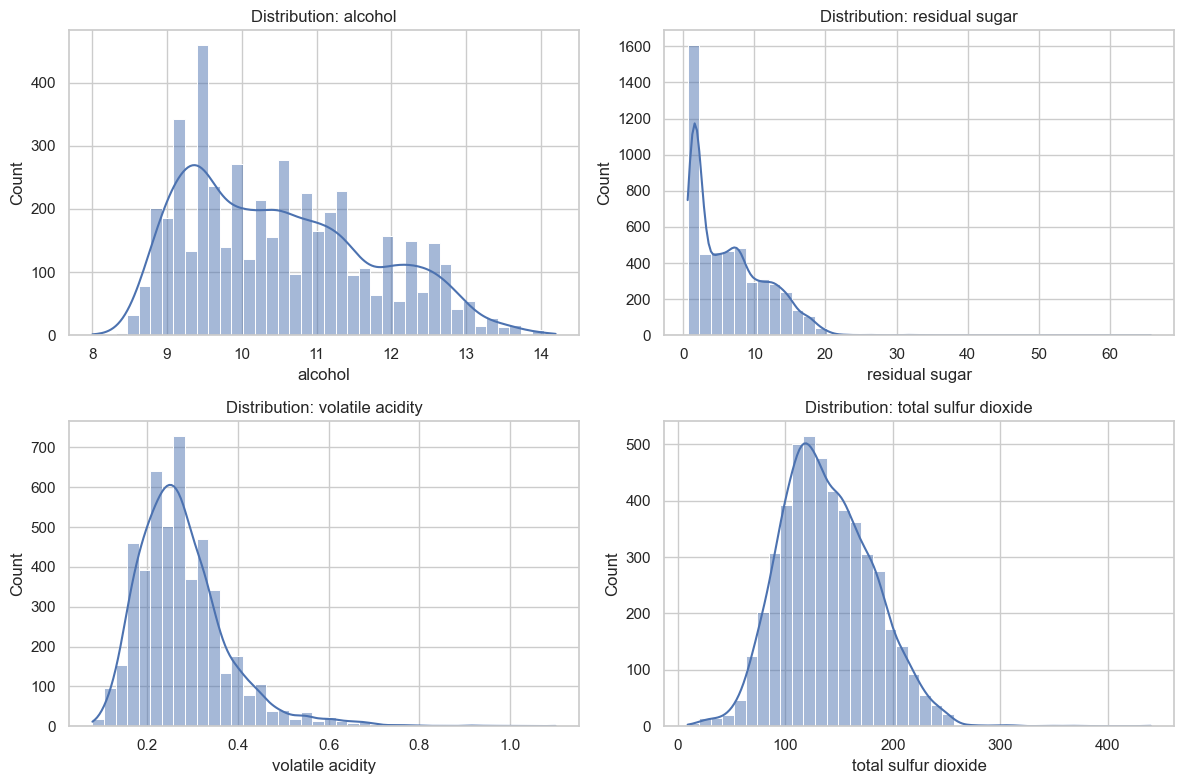

In [16]:
# Correlation heatmap (features + target)
corr = data.corr(numeric_only=True)

plt.figure(figsize=(12, 9))
sns.heatmap(corr, cmap="vlag", center=0, square=True)
plt.title("Correlation heatmap: physicochemical features and quality")
plt.tight_layout()
plt.show()

# Feature vs quality: quick visual checks
feature_pairs = ["alcohol", "volatile acidity", "residual sugar", "density"]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

for ax, col in zip(axes, feature_pairs):
    sns.boxplot(x="quality", y=col, data=data, ax=ax)
    ax.set_title(f"{col} vs quality")
    ax.set_xlabel("quality")
    ax.set_ylabel(col)

plt.tight_layout()
plt.show()

# Distributions for a few key variables (skew + scale)
dist_features = ["alcohol", "residual sugar", "volatile acidity", "total sulfur dioxide"]
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()
for ax, col in zip(axes, dist_features):
    sns.histplot(data[col], bins=40, kde=True, ax=ax)
    ax.set_title(f"Distribution: {col}")
    ax.set_xlabel(col)
plt.tight_layout()
plt.show()


<details>
<summary><span style="color:red"> about this block:</span></summary>  

This block does **three EDA passes**: (1) correlations, (2) feature vs target, (3) feature distributions.


## 1) Correlation heatmap (features + target)

```python
corr = data.corr(numeric_only=True)
```

* Computes the **correlation matrix** between all numeric columns (including `quality`).
* Correlation here is Pearson correlation by default: values in **[-1, 1]**.

  * `+1`: strong positive linear relationship
  * `-1`: strong negative linear relationship
  * `0`: no linear relationship


Pearson correlation between two variables $X$ and $Y$ is:
$$
r_{XY}=\frac{\mathrm{Cov}(X,Y)}{\sigma_X , \sigma_Y}
$$

In **sample form** (what pandas uses by default):

$$
r_{XY}=
\frac{\sum_{i=1}^{n}(x_i-\bar{x})(y_i-\bar{y})}
{\sqrt{\sum_{i=1}^{n}(x_i-\bar{x})^2}\sqrt{\sum_{i=1}^{n}(y_i-\bar{y})^2}}
$$

Where:

* $x_i, y_i$ are paired observations
* $\bar{x}, \bar{y}$ are sample means
* $n$ is the number of observations
* The numerator measures how $X$ and $Y$ vary together (covariation)
* The denominator rescales by their standard deviations, so the result is always in $[-1, 1]$.
* $\sigma_X$ = standard deviation of $X$
* $\sigma_Y$ = standard deviation of $Y$

(And $\mathrm{Cov}(X,Y)$ is the covariance.)

<details>
<summary><span style="color:red"> What “sample form” means:</span></summary>  

By **“sample form”** I mean the formula we use when we compute correlation from a **finite dataset we observed** (a *sample*), not from the entire true population.

### Population vs sample (idea)

* **Population**: the “true” full distribution of all possible wines (unknown).
* **Sample**: our dataset of 4,898 wines (what we actually have).

### Why it matters

The *population* Pearson correlation would be written with population expectations:

$$
\rho_{XY}=\frac{\mathrm{Cov}(X,Y)}{\sigma_X\sigma_Y}
$$

But in real life we don’t know the population means/covariances, so we estimate them from data using **sample means** $\bar{x}, \bar{y}$, giving the **sample correlation**:

$$
r_{XY}=
\frac{\sum_{i=1}^{n}(x_i-\bar{x})(y_i-\bar{y})}
{\sqrt{\sum_{i=1}^{n}(x_i-\bar{x})^2}\sqrt{\sum_{i=1}^{n}(y_i-\bar{y})^2}}
$$

That $r$ is what we compute in pandas/sklearn.

### Tiny nuance (optional)

There’s also a “$n$ vs $n-1$” detail in how covariance/variance are estimated, but in the correlation formula it cancels out, so we typically don’t worry about it.
</details>


```python
plt.figure(figsize=(12, 9))
sns.heatmap(corr, cmap="vlag", center=0, square=True)
```

* Creates a heatmap of the matrix:

  * `cmap="vlag"`: diverging colormap (good for negative vs positive).
  * `center=0`: makes 0 the neutral midpoint.
  * `square=True`: each cell is a square (prettier / easier to read).

Purpose: quickly see:

* which features correlate with `quality`,
* which features correlate with each other (redundancy / multicollinearity).


<details>
<summary><span style="color:red">Redundancy vs multicollinearity:</span></summary>  

## Redundancy

**Meaning:** two (or more) features carry **overlapping information**.

* They may be strongly correlated, or one may be almost a function of the other.
* It’s a *data/feature* concept: “Do we really need both of these?”

**Example:** `free sulfur dioxide` and `total sulfur dioxide` often move together, so having both can be partly redundant.

## Multicollinearity

**Meaning:** in a **regression model**, one feature can be **well predicted from other features**.

* It’s a *modeling* concept: it matters because OLS coefficients become **unstable** (large standard errors, signs/magnitudes can swing) when predictors are highly correlated.
* You can have multicollinearity even if no single pair is extremely correlated, several features together can create it.

**Example:** `density`, `residual sugar`, and `alcohol` are interrelated; even if pairwise correlations aren’t perfect, together they can make one predictable from the others → multicollinearity.

## Quick practical difference

* **Redundancy:** “These features overlap; one might be enough.”
* **Multicollinearity:** “Because predictors overlap, OLS coefficient estimates are fragile and hard to interpret.”

## How our models react

* **OLS:** sensitive → coefficients can be hard to trust when multicollinearity is high.
* **Lasso:** often picks one feature from a redundant group and shrinks others toward 0 (though which one it picks can vary).
* **Random Forest:** less bothered for prediction; can still spread importance across correlated features.



<details>
<summary><span style="color:red">Is it a problem that Random Forest feature importance gets split across correlated features?</span></summary>   

Not necessarily “bad”, it depends on what we’re trying to do.

## For prediction

It’s usually **fine**.

* If two features contain similar signal, RF can use either (or both) to make good splits.
* Prediction accuracy typically doesn’t suffer just because importance is shared.

## For interpretation

It can be **annoying / misleading** if we treat “importance” as a clean ranking.

* With correlated features, the model can “substitute” one for the other.
* So importance may get **diluted across the group**, making each feature look only “moderately” important even though the *group* is very important.
* Or the ranking can **shift** depending on randomness / data split.

### Example intuition

If `alcohol` and `density` overlap a lot:

* the forest might split on `alcohol` in some trees and `density` in others,
* so each ends up with less importance than if it were the only proxy.

## What to do (when we care about interpretability)

* Prefer **permutation importance** (we used it) because it’s tied to prediction error.
* Even then, correlated features can “share” importance, so interpret it as:

  * “This **cluster** matters,” not “this exact feature alone is the sole driver.”
* If you want deeper clarity, SHAP helps because it can show **direction** and **local effects**, but it also can split credit among correlated features.

So: **not bad for performance**, but it means we should be cautious about interpreting a single feature-importance ranking as “the truth.”

</details>
</details>


<details>
<summary><span style="color:red">In practice, how do we deal with redundant features and multicollinearity? do we drop features, use regularization, or something else?</span></summary>  

Regularization is **one** common way, but it’s not the only (or always best) approach, especially once you separate **redundancy** (overlapping information) from **multicollinearity** (predictors being linearly dependent in a regression).

## Yes! regularization can handle redundancy *and* multicollinearity

* **Lasso (L1)** can shrink some coefficients to **exactly 0** → a built-in feature selector (often drops redundant predictors).
* **Ridge (L2)** shrinks coefficients toward 0 but rarely to exactly 0 → **stabilizes OLS** when predictors are correlated (good multicollinearity fix).
* **Elastic Net (L1 + L2)** is often best when we have correlated groups → it can keep groups together more sensibly than pure Lasso.

So yes: you *can* keep all features and let the model cope.


## But we *do* sometimes remove or transform features manually

Common reasons (these apply to redundancy and sometimes to multicollinearity too):

1. **Interpretability / simplicity**
   Dropping one of two near-duplicates makes our story cleaner and coefficients easier to explain.

2. **Stability**
   With Lasso, correlated predictors can “compete,” so the chosen survivor can vary across samples. Removing obvious redundancy can make results more consistent.

3. **Production cost / measurement constraints**
   If one redundant feature is expensive or unavailable at inference time, we drop it.

4. **Cleaner importance explanations**
   Tree models can “split credit” across correlated features, which can make feature-importance plots harder to interpret.

## Other standard ways to handle multicollinearity (beyond regularization)

* **Feature selection by correlation / VIF**

  * Drop one feature from highly correlated pairs, or use **VIF** (Variance Inflation Factor) to identify predictors that are predictable from others.
* **Dimensionality reduction (PCA / PLS)**

  * Replace correlated predictors with a smaller set of components.
  * Great for prediction, weaker for interpretability (components are mixtures).
* **Use models less sensitive to multicollinearity**

  * Tree-based models (RF/GBM) don’t suffer coefficient instability like OLS does (though interpretability can still be messy).
* **Centering/standardizing does *not* remove multicollinearity**

  * It helps optimization and comparability of coefficients, but the underlying dependence remains.

## Practical rule of thumb

* If your goal is **prediction**, you can often keep correlated features and rely on **Ridge/Elastic Net** or **tree models**.
* If your goal is **explanation**, you usually want to **reduce redundancy**, or at least interpret correlated predictors as a **cluster** rather than fighting over which single one is “the” driver.

In our project, keeping everything is totally reasonable: we used **Lasso** (shrinkage) plus **permutation importance** (impact on error) to manage redundancy/multicollinearity without manual feature dropping.

</details>

## 2) Feature vs quality (boxplots)

```python
feature_pairs = ["alcohol", "volatile acidity", "residual sugar", "density"]
```

We pick 4 features to compare against the target.

```python
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()
```

* Creates a 2×2 grid of subplots.
* `ravel()` flattens the 2D array of axes into a 1D list so it’s easier to loop over.

```python
for ax, col in zip(axes, feature_pairs):
    sns.boxplot(x="quality", y=col, data=data, ax=ax)
```

For each feature:

* x-axis = `quality` (categories: 3,4,5,...)
* y-axis = the feature value
* A **boxplot** shows:

  * median (middle line),
  * IQR (box),
  * spread / outliers (whiskers + points)

Purpose: see whether the feature tends to **increase/decrease** with quality, and whether relationships look:

* monotonic,
* noisy,
* different spreads at different quality levels (heteroscedasticity).


## 3) Distributions of key variables (histograms + KDE)

```python
dist_features = ["alcohol", "residual sugar", "volatile acidity", "total sulfur dioxide"]
```

We choose 4 variables to inspect their distributions.

```python
sns.histplot(data[col], bins=40, kde=True, ax=ax)
```

* `histplot`: histogram with 40 bins.
* `kde=True`: overlays a smooth density curve (kernel density estimate).

Purpose:

* understand **scale** (typical ranges),
* detect **skewness** (e.g., long right tail),
* spot **outliers**,
* decide whether transformations might help (especially for linear models).


<details>
<summary><span style="color:red">

1) How is the KDE curve computed when `kde=True`?</span></summary>  

### 1) How is the KDE curve computed when `kde=True`?

A KDE (Kernel Density Estimate) is a **smooth estimate of the probability density** of a variable, built by placing a small “bump” (the *kernel*) on every data point and adding them up.

Conceptually:

* Put a kernel $K(\cdot)$ (usually Gaussian) centered at each $x_i$
* Control the smoothness with a bandwidth $h$ (bigger $h$ = smoother curve)
* Sum and normalize

Mathematically, the KDE at a point $x$ is:

$$
\hat{f}(x)=\frac{1}{n h}\sum_{i=1}^{n} K\left(\frac{x-x_i}{h}\right)
$$

* $n$: number of samples
* $K$: kernel function (often Gaussian)
* $h$: bandwidth (smoothing parameter)

So the KDE curve is basically a “smoothed histogram” that doesn’t depend on bin edges.
</details>

<details>
<summary><span style="color:red">

2) How do these plots help decide whether transformations might help (especially for linear models)?</span></summary>  



Histograms + KDE help us see issues that often make **linear models** struggle:

#### A) Strong skew (long tails)

If a feature is very right-skewed (common for `residual sugar`, `total sulfur dioxide`), then:

* extreme values can dominate the fit,
* the relationship with the target may be closer to **log-linear** than linear.

**Typical fix:** log transform (or `np.log1p(x)` if zeros exist).

#### B) Outliers / heavy tails

If we see a few extreme values far from the bulk:

* OLS can get pulled toward them (high leverage),
* residuals can become non-normal and heteroscedastic.

**Typical fixes:** log transform, winsorizing/clipping, or using robust models.

#### C) Non-constant spread (often revealed later, but distribution hints it)

Very wide-ranging features can produce relationships where variance grows with the feature level.

**Transformations** like log/sqrt often compress large values and can make the error variance more stable.

#### D) “Count-like” or bounded behavior

Some variables behave like counts or are naturally nonnegative. A transform can make the feature behave more “linear-friendly.”

**In short:**
These plots don’t *prove* we need a transform, but they help us **spot skew + outliers**, which are classic signals that a **log / sqrt / Box-Cox-like** transformation might make relationships more linear and improve OLS/Lasso behavior (more stable coefficients, cleaner residuals).

</details>

### Summary

This cell helps us build intuition by showing:

* **what’s correlated with what**,
* **how key features vary across quality levels**,
* and **what the raw distributions look like** before modeling.

</details>

### **Hypotheses (informed by the plots above)**

The EDA gives us a first set of testable expectations:

- **H1: Alcohol likely increases quality.** Higher-quality bins tend to have higher alcohol levels.
- **H2: Volatile acidity likely decreases quality.** The feature–quality plot suggests a fairly monotonic negative relationship.
- **H3: Density and residual sugar may be non-linear or conditional.** Their distributions are skewed, and “more” doesn’t look uniformly better across quality levels.
- **H4: Sulfur variables likely overlap.** Free and total sulfur dioxide are strongly related chemically, and the correlation heatmap shows redundancy.
- **H5: Expect multicollinearity clusters.** Chemically linked variables can make OLS coefficients unstable even when predictions are decent, useful context for why Lasso (and tree models) can behave differently.

>**How our models react**
>
>* **OLS:** sensitive → coefficients can be hard to trust when multicollinearity is high.
>* **Lasso:** often picks one feature from a redundant group and shrinks others toward 0 (though which one it picks can vary).
>* **Random Forest:** less bothered for prediction; can still spread importance across correlated features.

<span style="font-size:24px; color:hotpink;">  

Random Forest can exploit non-linear and interaction effects better than OLS because it learns threshold-based, piecewise rules and conditional splits automatically, while OLS assumes one global linear relationship per feature unless we explicitly add polynomial or interaction terms.  

</span>

<details>
<summary><span style="color:red">More on this:</span></summary>   

**OLS can only express one fixed linear effect per feature**, while a **Random Forest can learn “different effects in different regions”** and interactions automatically.

From the plots, we can infer that residual sugar has a weaker and possibly non-linear relationship with quality.

> The boxplots don’t show a clean monotonic trend like alcohol does; instead, sugar varies widely even within the same quality score, and its distribution is heavily right-skewed with outliers. This supports the idea that sugar may help only within certain ranges (or may interact with other features), exactly the kind of pattern Random Forest can exploit better than OLS.

*Here’s the intuition for the specific situation we described: sugar might help only within certain ranges (or interact with other features).*  

## 1) OLS assumes a single straight-line effect

In OLS we’re effectively fitting:

$$
\hat y = \beta_0 + \beta_{\text{sugar}} \cdot \text{sugar} + \beta_{\text{alcohol}} \cdot \text{alcohol} + \dots
$$

That means the effect of sugar is **constant**:

* if $\beta_{\text{sugar}}>0$: *more sugar always increases predicted quality*
* if $\beta_{\text{sugar}}<0$: *more sugar always decreases predicted quality*

OLS cannot naturally represent:

* “sugar helps up to ~5, then starts hurting”
* “sugar matters only when alcohol is high”
* “sugar matters only when density is low”

unless **we manually add** non-linear terms like:

* $\text{sugar}^2$ (quadratic)
* splines / bins
* interactions like $\text{sugar} \times \text{alcohol}$


## 2) Random Forests learn piecewise rules (nonlinearity for free)

A Random Forest is an ensemble of decision trees. Trees split the feature space with rules like:

* `residual sugar <= 5.2`
* `alcohol > 10.8`
* `density <= 0.994`

Each leaf predicts a different value. That creates a **piecewise-constant (or piecewise) function**, which can approximate non-linear relationships well.

So a tree can represent something like:

* If sugar is low → predicted quality ≈ 6.0
* If sugar is medium → predicted quality ≈ 6.4
* If sugar is very high → predicted quality ≈ 5.8

No need to explicitly add polynomial features.


## 3) Random Forests also capture interactions automatically

In OLS, interactions must be explicitly engineered:

$$
\hat y = \beta_0 + \beta_1 \cdot \text{sugar} + \beta_2 \cdot \text{alcohol} + \beta_3(\text{sugar}\cdot \text{alcohol})
$$

If we don’t include the $\text{sugar}\cdot\text{alcohol}$ term, OLS *cannot* learn that effect.

In a tree, interactions appear naturally because splits are **conditional**:

* First split: `alcohol > 11`
* Inside that branch: split on `sugar`

That means the effect of sugar can be different depending on alcohol. That’s exactly an interaction.

## 4) How this connects to our plots

Our sugar boxplot doesn’t show a clean monotonic shift across quality levels, and sugar’s distribution is highly skewed with outliers. That pattern often suggests:

* thresholds (“too much sugar”)
* diminishing returns
* interactions with other chemistry variables like density/alcohol

Those are all patterns a Random Forest can fit **without extra feature engineering**, while OLS would need us to **manually specify** the right transformations.

</details>


**Key takeaways**
- Correlations tell us where OLS should do okay, and where it may struggle (redundancy / multicollinearity).
- Feature-vs-quality plots hint at curvature and thresholds that linear models can only approximate.
- These hypotheses give us a structured lens for interpreting coefficients, permutation importance, PDP, and SHAP later.


## **3) Preprocessing + a baseline we can’t ignore**

With some intuition in place, we can now lock an evaluation protocol. The goal is simple: **make comparisons fair, reproducible, and leakage-free**, so any gains we see later are genuinely due to modeling.

We’ll use this workflow:

- **Train / holdout split:** 70% / 30% with `random_state=17`
- **Primary selection metric:** **5-fold CV MSE** computed on the training split  
- **Holdout set:** reported as a one-time **sanity check** (it should broadly agree with CV)
- **Scaling (linear models):** `StandardScaler` fit **only on training data**
  - makes coefficients comparable (standardized effect size)
  - makes Lasso’s $\ell_1$ penalty behave sensibly
- **Leakage prevention:** when we use CV, scaling must happen **inside each fold**, so we wrap preprocessing + model in a **scikit-learn `Pipeline`**

Before any “real” model, we also set a baseline: **predict the training mean quality** for every wine.  
If a model can’t beat that *consistently*, something is wrong (model mismatch, leakage, or very weak signal).


<details>
<summary><span style="color:red">More on scaling:</span></summary>  

We use `StandardScaler()` for the **linear models** because their math *cares* about feature scale. For **Random Forest**, scaling is usually unnecessary.

### Why we scale for Lasso (and often for OLS)

* **Lasso is scale-sensitive**: it penalizes coefficients with an $\ell_1$ penalty. If one feature is measured in large units (e.g., “total sulfur dioxide”) and another in small units (e.g., “chlorides”), the penalty will shrink them unevenly unless we standardize first. Scaling makes the penalty “fair” across features.
* **OLS isn’t scale-sensitive for prediction**, but scaling makes coefficients comparable (effect per 1 standard deviation) and is helpful when we want to interpret “which feature matters most.” Separately, OLS is **outlier-sensitive** because squared error gives large residuals huge influence.

### Why Random Forest doesn’t need scaling

Random Forest builds **decision trees**, and trees make splits using **order-based thresholds**, like:

* “is `alcohol` ≤ 10.5?”

If we rescale the feature (say multiply by 100), the model can represent the *same split* as:

* “is `alcohol_scaled` ≤ 1050?”

Because scaling doesn’t change the **rank order** of the data, trees can learn essentially the same structure.

✅ So **we typically do NOT need `StandardScaler` for Random Forest**.

### Two small caveats (not deal-breakers)

1. **Importance measures can still be tricky**
   Impurity-based feature importance in trees can be biased (especially with correlated features). This is why permutation importance and SHAP are usually better for explanations, but that’s not a scaling issue.

2. **Some algorithms really do need scaling (RF is not one of them)**
   KNN, SVM with RBF kernels, PCA, k-means, neural nets, etc. rely on distances/gradients and are strongly affected by feature units.

### Practical rule of thumb

<span style="font-size:24px; color:hotpink;">

* **Scale for:** Lasso / Ridge / Elastic Net, Logistic Regression, SVM, KNN, PCA, k-means
* **Optional for OLS:** not required for accuracy, but great for interpretability
* **Don’t bother for:** **Random Forest** (and most tree-based methods)

</span>

</details>

In [17]:
X = data.drop(columns=["quality"])
y = data["quality"]

X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_STATE
)

print("Train shape:", X_train.shape, "Holdout shape:", X_holdout.shape)

# Explicit scaling objects (fit on train only), mainly for analysis utilities like lasso_path. Our actual models (OLS/Lasso) are later scaled via Pipelines, which is the safest approach for CV.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_holdout_scaled = scaler.transform(X_holdout)

# Baseline: predict the mean target from the training set
baseline = DummyRegressor(strategy="mean")
baseline_results = evaluate_regression(
    baseline, X_train, y_train, X_holdout, y_holdout, model_name="Baseline (mean)", cv_folds=5
)

baseline_table = pd.DataFrame([baseline_results])[[
    "model", "cv_mse", "train_mse", "holdout_mse", "holdout_rmse", "holdout_mae", "holdout_r2"
]]

print_df(baseline_table, title="Baseline performance (lower is better for MSE/RMSE/MAE):")


Train shape: (3428, 11) Holdout shape: (1470, 11)
Baseline performance (lower is better for MSE/RMSE/MAE):
          model  cv_mse  train_mse  holdout_mse  holdout_rmse  holdout_mae  holdout_r2
Baseline (mean)  0.7866     0.7865       0.7789        0.8825       0.6809     -0.0000


<details>
<summary><span style="color:red">about this block:</span></summary>  

### 1) Split the dataset into features and target

```python
X = data.drop(columns=["quality"]) # we’re calling the DataFrame method "drop()" on the DataFrame object "data".
y = data["quality"]
```

* `X` becomes **all input features** (the 11 physicochemical measurements).
* `y` becomes the **target** we want to predict: the `quality` score.

So now we have:

* **X:** shape (4898, 11)
* **y:** shape (4898,)


### 2) Create a train / holdout split

```python
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_STATE
)
```

* This splits the data into:

  * **70% training set** (`X_train`, `y_train`)
  * **30% holdout set** (`X_holdout`, `y_holdout`)
* `random_state=RANDOM_STATE` makes the split **reproducible** (same split every run).

The holdout set is kept aside as our **final reality check**.


### 3) Print the shapes

```python
print("Train shape:", X_train.shape, "Holdout shape:", X_holdout.shape)
```

This confirms the split worked and shows how many rows/columns are in each part.

In our case we got:

* Train: (3428, 11)
* Holdout: (1470, 11)


### 4) Fit a scaler on training features only (no leakage)

```python
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_holdout_scaled = scaler.transform(X_holdout)
```

* `StandardScaler()` standardizes each feature to roughly:

  * mean = 0
  * standard deviation = 1

**Important detail:**

* `fit_transform(X_train)` means: *learn scaling parameters from training*, then transform training.
* `transform(X_holdout)` means: *apply the same training-based scaling* to holdout.

That avoids “peeking” at the holdout distribution.

We mention this is “mainly for analysis utilities like `lasso_path`” because:

* Our actual models (OLS/Lasso) are later scaled via **Pipelines**, which is the safest approach for CV.


### 5) Define a baseline model (mean predictor)

```python
baseline = DummyRegressor(strategy="mean")
```

This baseline ignores all features and predicts:

> **the mean of `y_train` for every wine**

It’s a sanity check: if a real model can’t beat this, something is wrong.


### 6) Evaluate baseline on train, holdout, and with CV

```python
baseline_results = evaluate_regression(
    baseline, X_train, y_train, X_holdout, y_holdout, model_name="Baseline (mean)", cv_folds=5
)
```

This calls our helper function, which:

* fits the model on `X_train, y_train`
* computes predictions on **train** and **holdout**
* computes metrics:

  * train MSE
  * holdout MSE, RMSE, MAE, R²
* and because `cv_folds=5`, it also computes:

  * **5-fold CV MSE on the training set** (using `cross_val_score`)

So we get a consistent evaluation record for the baseline.


### 7) Put results into a neat table and print

```python
baseline_table = pd.DataFrame([baseline_results])[[
    "model", "cv_mse", "train_mse", "holdout_mse", "holdout_rmse", "holdout_mae", "holdout_r2"
]]

print_df(baseline_table, title="Baseline performance (lower is better for MSE/RMSE/MAE):")
```

* Wraps the results dict into a one-row DataFrame
* Selects only the columns you want to show
* Prints it in a clean format

> Why do we use `pd.DataFrame([baseline_results])` instead of `pd.DataFrame(baseline_results)`?
> `DataFrame` expects each column to have a 1-D sequence of values (like a list/array). But in our dict, the values are scalars (`model`, `cv_mse`, etc.), so pandas can’t infer how many rows to create. Wrapping the dict in a list (`[baseline_results]`) tells pandas: “make this one row.”
>
> If we wrote:
>
> ```python
> pd.DataFrame([baseline_results])["model", "cv_mse", "train_mse", ...]
> ```
>
> we’d get a `KeyError` because `"model", "cv_mse", ...` is a **tuple**. Pandas interprets that as: “select a single column whose name is exactly this tuple” (which doesn’t exist).
>
> ✅ Fix: pass a **list** of column names:
>
> ```python
> cols = ["model", "cv_mse", "train_mse", ...]
> df = pd.DataFrame([baseline_results])[cols]
> ```


### The key idea

This whole cell sets up:  
✅ a clean train/holdout split  
✅ leakage-free scaling (fit on train only)  
✅ a baseline that defines what “better than trivial” means  
✅ comparable metrics for later models  


</details>

### **Baseline results: a sanity check that should be boring**


For **Baseline (mean)**, the model’s rule is:

> “Always predict the average `quality` of the training data.” 
>The mean predictor establishes the “do-nothing” reference point.


What we expect from this baseline:
- **CV and holdout errors** should be similar (no leakage).
- **$R^2$** should be ~0 (predicting the mean explains essentially no variance beyond the mean itself).

> ### Why it’s ~0 (slightly negative) here
>
> Our baseline model predicts **the training-set mean** for every holdout wine:
>
> $$
> \hat{y}_i = \bar{y}_{train}
> $$
>
> But $R^2$ on the holdout set is:
>
> $$
> R^2 = 1 - \frac{\sum_{i}(y_i - \hat{y}_i)^2}{\sum_{i}(y_i - \bar{y}_{holdout})^2}
> $$
>
> The denominator uses the **holdout mean** $\bar{y}_{holdout}$. The numerator uses predictions based on $\bar{y}_{train}$.
>
> Since $\bar{y}_{train} \neq \bar{y}_{holdout}$ by a tiny amount (sampling noise), our baseline SSE (Sum of Squared Errors also called Sum of Squared Residuals) is *slightly worse* than the “predict holdout mean” SSE, so $R^2$ becomes slightly negative.
>
> ### If we predicted the holdout mean on the holdout set
>
> If we (improperly) predicted:
>
> $$
> \hat{y}_i = \bar{y}_{holdout}
> $$
>
> then the numerator would equal the denominator, and we’d get:
>
> $$
> R^2 = 0
> $$
>
> ### Why our result is reassuring
>
> Seeing $R^2 \approx 0$ (or a hair below) confirms:
>
> * no leakage,
> * the split is reasonable,
> * the baseline is behaving as expected.




So **CV MSE = 0.7866** means:

**What happened in 5-fold CV**  

For each fold:

1. Take 4/5 of the training data (the “train fold”).
2. Compute the **mean quality** on that train fold.
3. Predict that same mean for every sample in the held-out fold.
4. Compute the MSE on that held-out fold.

Then we average the 5 MSE values → **0.7866**.

**How to interpret the number**  

* It’s the **expected squared error** of the “predict-the-mean” strategy on unseen data drawn from the same distribution.
* In RMSE terms:
  $$
  \sqrt{0.7866}\approx 0.887
  $$
  So the baseline is typically off by about **0.89 quality points**.

**Why it’s useful**  

This number is our **floor**:
any real model should beat **~0.79 CV MSE** (or **~0.89 CV RMSE**) to prove it’s learning signal beyond “everyone gets the average.”

>If this baseline ever looked unusually strong, it would be a red flag. Instead, it behaves exactly as expected, so we can treat any later improvement as real model signal rather than evaluation artifacts.


## **4) Model 1 — OLS (LinearRegression): a transparent linear benchmark**

With the baseline in hand, we can finally ask: *are mostly linear, additive relationships enough?*  
Ordinary Least Squares is a great first serious model because it is fast, easy to validate, and highly interpretable, especially after scaling.

We fit OLS using a `Pipeline` so scaling happens correctly (and safely inside CV). Then we examine:

- **Generalization:** 5-fold **CV MSE** (primary), plus train/holdout as context
- **Direction:** standardized coefficients (sign = direction; magnitude = standardized linear effect size)
- **Impact on error:** permutation importance on holdout (what actually moves MSE)
- **Residual behavior:** do errors show structure the model can’t capture?
- **Effect shape:** partial dependence plots (PDP) for top drivers (a quick shape sanity check)

**Key idea:** coefficients tell us *direction*, while permutation importance tells us *predictive usefulness*.


OLS — Mean squared error (train):   0.558
OLS — Mean squared error (cv):      0.560
OLS — CV MSE std:                   0.043
OLS — Mean squared error (holdout): 0.584
Most influential OLS feature by |coefficient|: density
OLS coefficient table (standardized features):
             feature    coef  abs_coef  rank
             density -0.6657    0.6657     1
      residual sugar  0.5382    0.5382     2
    volatile acidity -0.1923    0.1923     3
                  pH  0.1500    0.1500     4
             alcohol  0.1295    0.1295     5
       fixed acidity  0.0978    0.0978     6
           sulphates  0.0621    0.0621     7
 free sulfur dioxide  0.0422    0.0422     8
total sulfur dioxide  0.0143    0.0143     9
           chlorides  0.0081    0.0081    10
         citric acid -0.0002    0.0002    11


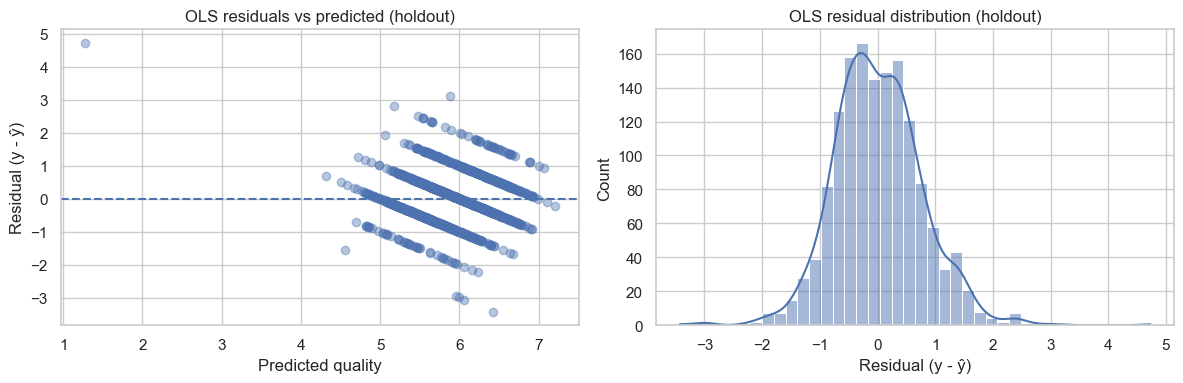

OLS permutation importance on holdout (ΔMSE when permuted):
             feature  delta_mse_mean  delta_mse_std
             density          0.9382         0.0352
      residual sugar          0.6879         0.0335
    volatile acidity          0.0645         0.0073
                  pH          0.0360         0.0067
             alcohol          0.0325         0.0053
       fixed acidity          0.0241         0.0043
           sulphates          0.0163         0.0033
 free sulfur dioxide          0.0055         0.0015
total sulfur dioxide          0.0007         0.0005
         citric acid         -0.0000         0.0000
           chlorides         -0.0001         0.0002


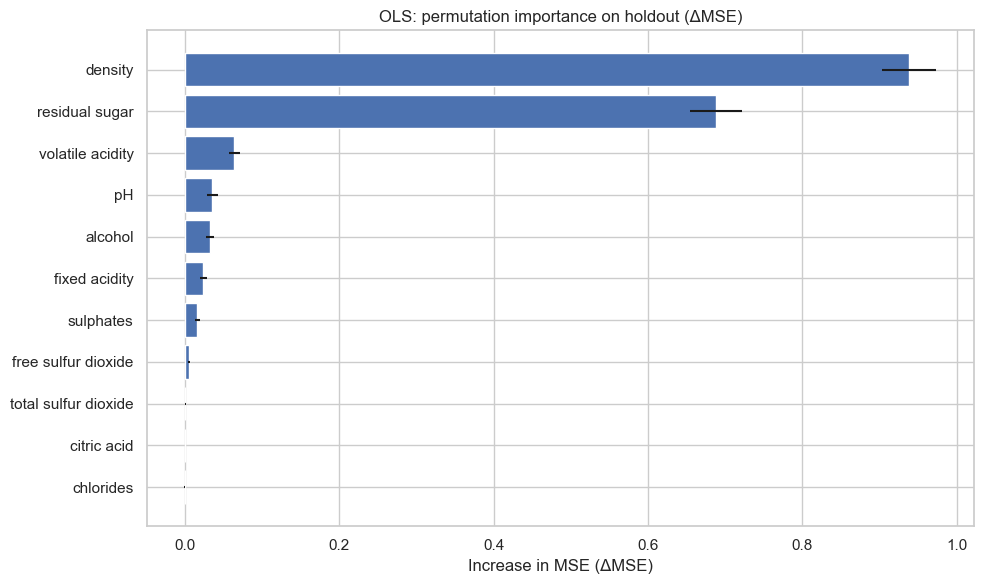

PDP features (OLS): ['density', 'residual sugar', 'volatile acidity']


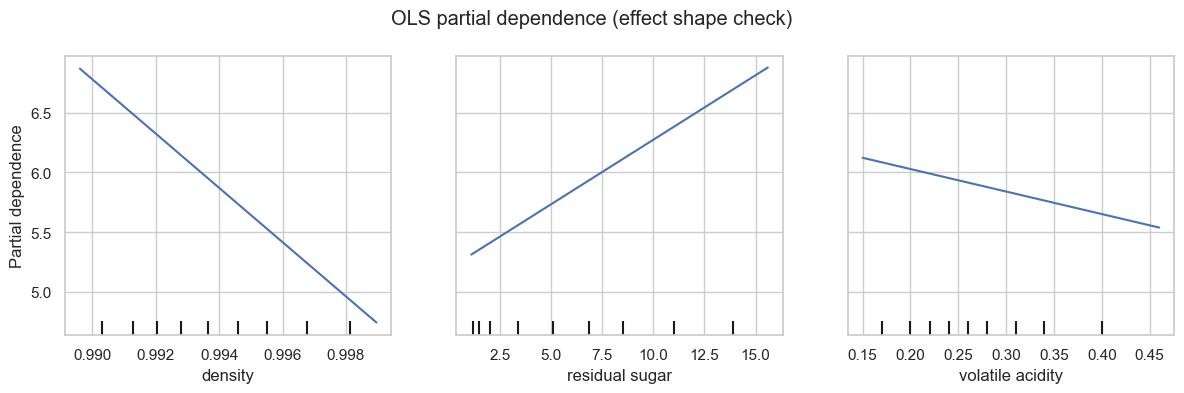

In [18]:
ols = Pipeline([
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression()),
])

ols_results = evaluate_regression(
    ols, X_train, y_train, X_holdout, y_holdout, model_name="OLS (LinearRegression)", cv_folds=5
)

print("OLS — Mean squared error (train):   %.3f" % ols_results["train_mse"])
print("OLS — Mean squared error (cv):      %.3f" % ols_results["cv_mse"])
print("OLS — CV MSE std:                   %.3f" % ols_results["cv_mse_std"])
print("OLS — Mean squared error (holdout): %.3f" % ols_results["holdout_mse"])

# Coefficients: direction (sign) and standardized linear effect size (magnitude)
coef = ols.named_steps["linreg"].coef_
ols_coef_table = (pd.DataFrame({
    "feature": X_train.columns,
    "coef": coef,
    "abs_coef": np.abs(coef),
})
.sort_values("abs_coef", ascending=False)
.reset_index(drop=True))
ols_coef_table["rank"] = np.arange(1, len(ols_coef_table) + 1)

top_ols_feature = ols_coef_table.loc[0, "feature"]
print(f"Most influential OLS feature by |coefficient|: {top_ols_feature}")
print_df(ols_coef_table, title="OLS coefficient table (standardized features):")

# Residual diagnostics on holdout
pred_holdout = ols.predict(X_holdout)
resid_holdout = y_holdout - pred_holdout

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].scatter(pred_holdout, resid_holdout, alpha=0.4)
axes[0].axhline(0, linestyle="--")
axes[0].set_title("OLS residuals vs predicted (holdout)")
axes[0].set_xlabel("Predicted quality")
axes[0].set_ylabel("Residual (y - ŷ)")

sns.histplot(resid_holdout, bins=40, kde=True, ax=axes[1])
axes[1].set_title("OLS residual distribution (holdout)")
axes[1].set_xlabel("Residual (y - ŷ)")

plt.tight_layout()
plt.show()

# Impact on error (permutation importance on holdout)
ols_perm = compute_permutation_importance(
    ols, X_holdout, y_holdout, feature_names=list(X_train.columns), n_repeats=30
)
print_df(ols_perm, title="OLS permutation importance on holdout (ΔMSE when permuted):")

plot_permutation_importance(
    ols_perm, top_k=12, title="OLS: permutation importance on holdout (ΔMSE)"
)

# Effect shape check (PDP) for the top 3 features by permutation importance
top_pdp_features = list(ols_perm["feature"].head(3))
print("PDP features (OLS):", top_pdp_features)

fig, ax = plt.subplots(figsize=(12, 4))
PartialDependenceDisplay.from_estimator(
    ols, X_train, features=top_pdp_features, ax=ax
)
plt.suptitle("OLS partial dependence (effect shape check)")
plt.tight_layout()
plt.show()


<details>
<summary><span style="color:red">about this block:</span></summary>  

## 1) Build an OLS model as a Pipeline (scaling + regression)

```python
ols = Pipeline([
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression()),
])
```

* **`Pipeline([...])`** chains preprocessing + model into one object.
* **`StandardScaler()`** standardizes each feature using training data (mean 0, std 1).

  * This makes coefficients comparable across variables (because everything is on the same scale).
* **`LinearRegression()`** is ordinary least squares (OLS): it fits the best linear relationship.

✅ Using a pipeline also prevents leakage when we do cross-validation, because scaling happens *inside each fold*.


## 2) Fit + evaluate with train, holdout, and CV metrics

```python
ols_results = evaluate_regression(
    ols, X_train, y_train, X_holdout, y_holdout, model_name="OLS (LinearRegression)", cv_folds=5
)
```

Our `evaluate_regression` function does:

1. Fits the pipeline on `(X_train, y_train)`
2. Predicts on both **train** and **holdout**
3. Computes **train MSE** and **holdout MSE**
4. If `cv_folds=5`, it runs **5-fold CV** on the training set and returns:

   * `cv_mse`: average CV MSE
   * `cv_mse_std`: variability across folds

Then we print:

```python
print("OLS — Mean squared error (train):   %.3f" % ols_results["train_mse"])
print("OLS — Mean squared error (cv):      %.3f" % ols_results["cv_mse"])
print("OLS — CV MSE std:                   %.3f" % ols_results["cv_mse_std"])
print("OLS — Mean squared error (holdout): %.3f" % ols_results["holdout_mse"])
```

* **Train MSE**: how well it fits the training data
* **CV MSE**: better estimate of generalization than train MSE
* **CV MSE std**: if large, performance varies a lot across folds (less stable)
* **Holdout MSE**: a final “unseen data” check


## 3) Extract and rank OLS coefficients (direction + standardized effect size)

```python
coef = ols.named_steps["linreg"].coef_
```

* After fitting, the OLS model has coefficients: one per feature.
* Because we scaled features, these coefficients are **standardized coefficients**:

  * **Sign** tells direction (positive/negative relationship)
  * **Magnitude** tells relative linear effect size (in standardized units)

We build a table:

```python
ols_coef_table = pd.DataFrame({
    "feature": X_train.columns,
    "coef": coef,
    "abs_coef": np.abs(coef),
}).sort_values("abs_coef", ascending=False)
```

Then add ranks:

```python
ols_coef_table["rank"] = np.arange(1, len(ols_coef_table) + 1)
```

This gives us a clean “which features have largest |coef|” view.


## 4) Residual diagnostics on holdout

### Predict and compute residuals

```python
pred_holdout = ols.predict(X_holdout)
resid_holdout = y_holdout - pred_holdout
```
<details>
<summary><span style="color:red">More on this:</span></summary>  

### Where did we fit `ols`?  

We fit it **inside** `evaluate_regression(...)`.

In our `evaluate_regression` function, the very first thing it does is:

```python
model.fit(X_train, y_train)
```

When we call:

```python
ols_results = evaluate_regression(ols, X_train, y_train, X_holdout, y_holdout, ..., cv_folds=5)
```

that line runs, so the pipeline `ols` gets fit on **X_train + y_train**.

Concretely, because `ols` is a `Pipeline`:

1. `StandardScaler` is fit on `X_train` (it learns each feature’s mean and std).
2. `StandardScaler` transforms `X_train` into standardized values.
3. `LinearRegression` is fit on the standardized `X_train` to learn coefficients + intercept.

After that call finishes, `ols` is now a trained pipeline object.


### What happens when we call `pred_holdout = ols.predict(X_holdout)`?

Since the pipeline is already fit, `.predict(X_holdout)` does a **two-step forward pass**:

1. **Scale the holdout features using the *training* scaler**

   * It applies the mean/std learned from `X_train`
   * It does **not** re-fit the scaler on holdout

2. **Predict with the trained linear regression**

   * It takes the scaled holdout rows and computes predictions:

$$
\hat{y} = \beta_0 + \sum_{j=1}^{p} \beta_j x_j^{(\text{scaled})}
$$

So `pred_holdout` becomes a vector (length = number of holdout rows, here 1470) containing the predicted quality scores for each holdout wine.

</details>



* **Residual** = actual − predicted
* We’re using the **holdout residuals**, which is good: it reflects behavior on unseen data.

### Plot residuals vs predictions

```python
axes[0].scatter(pred_holdout, resid_holdout, alpha=0.4)
axes[0].axhline(0, linestyle="--")
```

This checks:

* Do residuals cluster around 0? (good)
* Do we see patterns like funnels/curves? (bad → suggests heteroskedasticity or non-linearity)
* Do errors increase at higher predicted values? (could indicate model mismatch)

### Plot residual histogram (+ KDE)

```python
sns.histplot(resid_holdout, bins=40, kde=True, ax=axes[1])
```

This checks:

* Are residuals roughly centered around 0?
* Are they symmetric-ish?
* Are there heavy tails (outliers)?

## 5) Permutation importance on the holdout set (impact on error)

```python
ols_perm = compute_permutation_importance(
    ols, X_holdout, y_holdout, feature_names=list(X_train.columns), n_repeats=30
)
```

This answers a different question than coefficients:

* Coefficients = **direction / linear association**
* Permutation importance = **how much predictive accuracy depends on the feature**

Mechanism (on holdout):

1. Measure baseline holdout MSE
2. Shuffle one feature column (break its relationship with $y$)
3. Recompute MSE
4. ΔMSE = increase in MSE caused by shuffling
5. Repeat 30 times for stability

Then we print and plot the top features:

```python
plot_permutation_importance(ols_perm, ...)
```

✅ This gives a *more error-grounded* notion of “importance” than raw coefficients.


## 6) PDP (Partial Dependence Plot): effect “shape” (global average effect)

```python
top_pdp_features = list(ols_perm["feature"].head(3))
PartialDependenceDisplay.from_estimator(
    ols, X_train, features=top_pdp_features, ax=ax
)
```

* **PDP = Partial Dependence Plot**
* It asks:

> On average, how does the model’s prediction change as we vary one feature, holding others “as observed” in the data?

Even though OLS is linear, PDP is still useful as a sanity check:

* if PDP looks curved in practice, it can hint at interactions/nonlinearities in the data distribution (or in how features correlate), suggesting why RF might win later.


## Big picture: what this OLS block gives us

We end up with 4 complementary lenses:

1. **Performance**: train vs CV vs holdout MSE
2. **Direction**: coefficients (sign and standardized effect size)
3. **Impact on error**: permutation importance (ΔMSE)
4. **Effect shape**: PDP (global pattern)

</details>

### **OLS results: a strong linear benchmark**

OLS makes a clear jump over the baseline:

- Baseline CV MSE ≈ **0.787**
- OLS CV MSE ≈ **0.561** (CV RMSE ≈ 0.749)

Train and holdout MSE are also close (≈0.558 vs ≈0.584), which is reassuring: OLS is learning real signal without dramatic overfitting.


## **Interpreting OLS: direction vs impact vs shape**

At this point we have three complementary lenses:

### **1) Direction (coefficients)**
Because we standardized features, coefficients can be read as *standardized linear effects*:

- **Density** has a strong **negative** coefficient.
- **Residual sugar** has a strong **positive** coefficient.
- **Volatile acidity** is negative (consistent with EDA intuition).

**Important caveat:** OLS coefficients are not “importance”. With correlated features, OLS can spread weight across proxies.

### **2) Impact on error (permutation importance)**
Permutation importance makes the model’s reliance visible on unseen data:

- **Density** and **residual sugar** dominate ΔMSE, far ahead of other features.
- Alcohol is still helpful, but it looks *less central* in OLS than in Random Forest later, consistent with the idea that density/sugar can act as proxies for alcohol/body in a purely linear fit. (alcohol is entangled with density and sugar. In correlated groups, OLS tends to “share” explanatory weight across related predictors.)

### **3) Effect shape (PDP)**
For a linear model, PDPs look roughly linear, which is expected. The more important point is what PDPs *can’t* show here: interactions and threshold effects. If those exist, they will show up later as the main reason a non-linear model wins.


### **Residuals: a quick reality check**

The residual diagnostics look broadly healthy: residuals are **centered around zero** with no dramatic drift, which suggests OLS is capturing a meaningful chunk of the signal.

Two details are worth calling out:

* **“Banding” in residuals vs. predictions is expected here.**
  The true target (`quality`) is an **integer score**, while OLS produces **continuous** predictions. That mismatch naturally creates horizontal stripes because residuals can only take certain offsets relative to discrete labels.

* **There’s still structure OLS can’t fully explain.**
  Even though the residual cloud is fairly symmetric, the spread isn’t uniform and there are visible tails in the histogram. That remaining error likely reflects a mix of:

  * **non-linear effects** (thresholds/kinks),
  * **interactions** (e.g., sugar behaving differently depending on alcohol/density),
  * and **irreducible noise** (quality is a human-rated outcome).

Overall, the residuals don’t scream “broken model,” but they do suggest there’s room to improve. The next logical move is to try regularization (Lasso) to tame redundancy and reduce variance, and then test non-linear models to capture any threshold-like or interaction effects hiding in the data.

**Key takeaways**
- OLS is a solid, transparent benchmark and a strong starting point.
- Coefficients explain **direction**, but permutation importance is a better proxy for **unique predictive impact**.
- If the true relationships are strongly non-linear, OLS will hit a ceiling, setting the stage for Lasso (regularization) and Random Forest (non-linearity).





## **5) Model 2 — Lasso: regularization, sparsity, and stability**

OLS treats every coefficient as “free” to take whatever value fits best. But our EDA hinted at redundancy and correlated feature clusters (e.g., sulfur measures). This is where **Lasso** can help.

Lasso adds an **$\ell_1$** penalty:

$$
\hat{\beta}(\alpha)=\arg\min_{\beta}\;\frac{1}{2n}\lVert y - X\beta\rVert_2^2 + \alpha\lVert\beta\rVert_1
$$

As $\alpha$ increases, coefficients shrink toward 0, and some become exactly 0.

We’ll run two versions:
1. **Lasso with $\alpha = 0.01$** (moderate regularization; encourages sparsity)
2. **LassoCV** to tune $\alpha$ via 5-fold cross-validation over a wide log-scale grid

<details>
<summary><span style="color:red">What I meant by “sparsity”:</span></summary>  

In Lasso, **sparsity** means:

> **many coefficients become exactly 0**, so the model uses only a subset of features.

So a “sparse” model is one where the coefficient vector $\beta$ has lots of zeros:

$$
\beta = [0, 0, 0.12, 0, -0.05, 0, \dots]
$$

That’s why people say Lasso does **feature selection**.


### Why $\alpha = 0.01$ is described as a “gentle nudge”

In Lasso, $\alpha$ controls the strength of the $\ell_1$ penalty:

$$
\min_{\beta} \frac{1}{2n}\sum_{i=1}^n (y_i - x_i^\top\beta)^2 + \alpha \sum_{j=1}^p |\beta_j|
$$

* If $\alpha = 0$ → it behaves like OLS (no shrinkage, no sparsity)
* As $\alpha$ increases → coefficients shrink more, and more can hit exactly 0
* Very large $\alpha$ → almost everything goes to 0 (underfitting)

Because we standardize features, $\alpha$ is on a meaningful scale. A value like **0.01** is often *small enough* that:

* many important coefficients remain non-zero
* but weak / redundant ones may get pushed closer to zero

So it’s a “gentle” regularization setting: it encourages sparsity without aggressively killing predictors.

**Important:** it’s not universally gentle for every dataset, what’s “gentle” depends on the data and noise level. That’s exactly why we also run **LassoCV** to choose $\alpha$ from data.

### How to *see* sparsity in our output

After fitting Lasso, check:

```python
np.sum(lasso001_coef == 0), len(lasso001_coef)
```

This tells us how many coefficients were set to zero.

* More zeros → more sparsity
* Fewer zeros → less sparsity (closer to OLS)
</details>

Then we interpret Lasso using the same framework:
- **Direction:** standardized coefficients
- **Impact on error:** permutation importance on holdout
- **Stability:** bootstrap selection frequency (how robust is feature selection?)



Lasso(alpha=0.01) — Mean squared error (train):   0.564
Lasso(alpha=0.01) — Mean squared error (holdout): 0.574
Least informative feature for Lasso(alpha=0.01) (closest coefficient to 0): fixed acidity
Lasso(alpha=0.01) coefficients (sorted by |coef| ascending):
             feature    coef  abs_coef
       fixed acidity -0.0000    0.0000
         citric acid -0.0000    0.0000
total sulfur dioxide -0.0000    0.0000
           chlorides -0.0027    0.0027
           sulphates  0.0297    0.0297
 free sulfur dioxide  0.0431    0.0431
                  pH  0.0673    0.0673
    volatile acidity -0.1885    0.1885
             density -0.2355    0.2355
      residual sugar  0.2564    0.2564
             alcohol  0.3224    0.3224


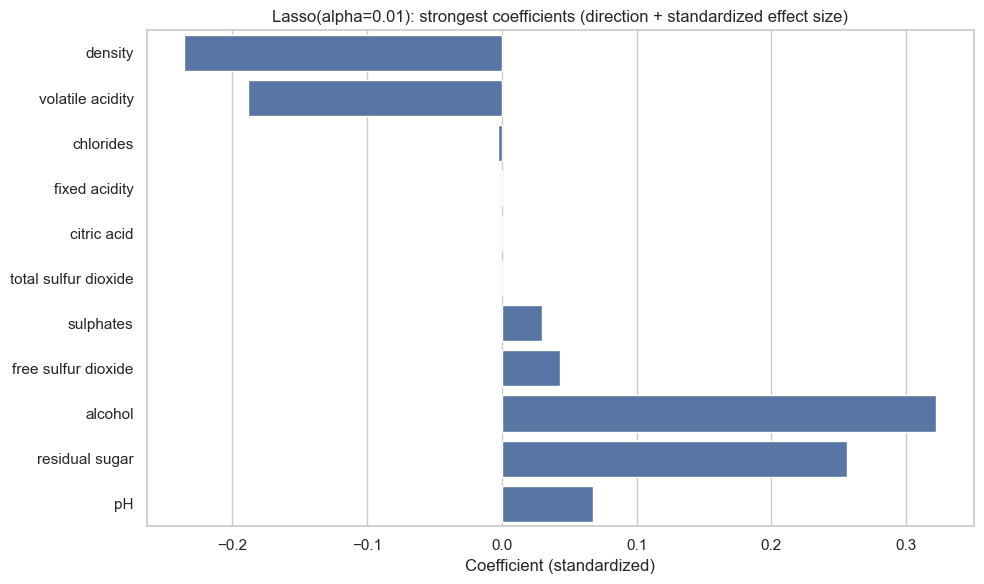

LassoCV — chosen alpha: 0.000283
LassoCV — Mean squared error (train):   0.558
LassoCV — Mean squared error (cv):      0.560
LassoCV — Mean squared error (holdout): 0.583
LassoCV — CV MSE std:                  0.043
Least informative feature for tuned LassoCV (closest coefficient to 0): citric acid
LassoCV coefficients (sorted by |coef| ascending):
             feature    coef  abs_coef
         citric acid -0.0000    0.0000
           chlorides  0.0069    0.0069
total sulfur dioxide  0.0130    0.0130
 free sulfur dioxide  0.0427    0.0427
           sulphates  0.0609    0.0609
       fixed acidity  0.0933    0.0933
             alcohol  0.1371    0.1371
                  pH  0.1465    0.1465
    volatile acidity -0.1920    0.1920
      residual sugar  0.5269    0.5269
             density -0.6482    0.6482


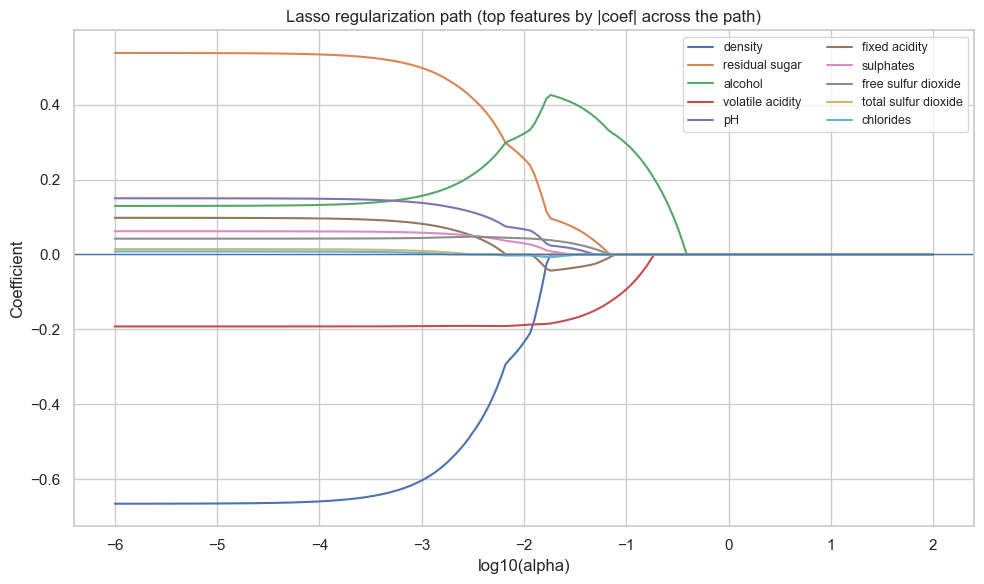

Lasso(alpha=0.01) permutation importance on holdout (ΔMSE):
             feature  delta_mse_mean  delta_mse_std
             alcohol          0.2075         0.0140
      residual sugar          0.1579         0.0146
             density          0.1193         0.0110
    volatile acidity          0.0703         0.0073
 free sulfur dioxide          0.0069         0.0016
           sulphates          0.0062         0.0016
                  pH          0.0056         0.0029
           chlorides          0.0001         0.0001
       fixed acidity          0.0000         0.0000
         citric acid          0.0000         0.0000
total sulfur dioxide          0.0000         0.0000


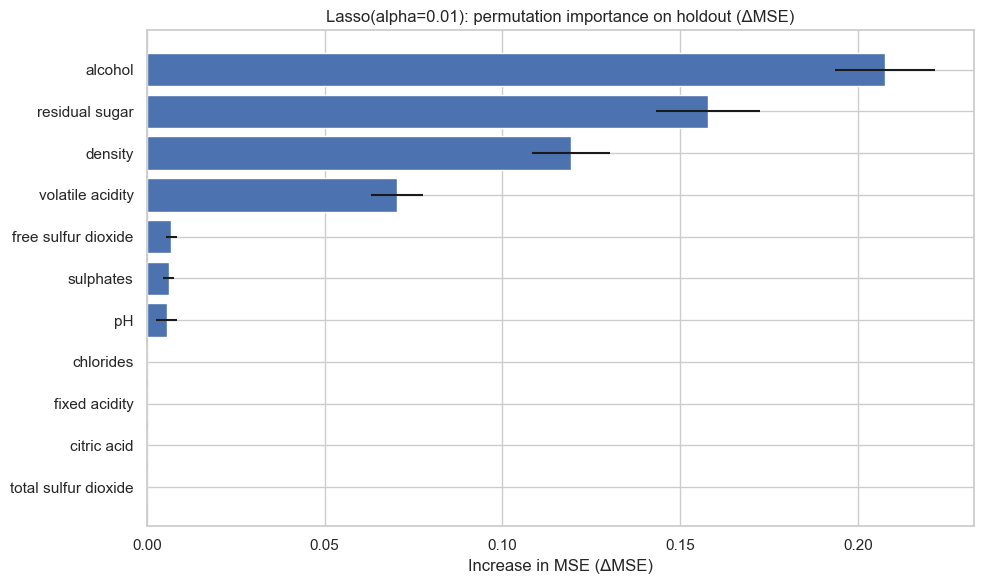

LassoCV (tuned) permutation importance on holdout (ΔMSE):
             feature  delta_mse_mean  delta_mse_std
             density          0.8895         0.0341
      residual sugar          0.6593         0.0327
    volatile acidity          0.0646         0.0073
             alcohol          0.0365         0.0057
                  pH          0.0342         0.0065
       fixed acidity          0.0222         0.0041
           sulphates          0.0159         0.0033
 free sulfur dioxide          0.0057         0.0015
total sulfur dioxide          0.0006         0.0005
         citric acid          0.0000         0.0000
           chlorides         -0.0001         0.0002


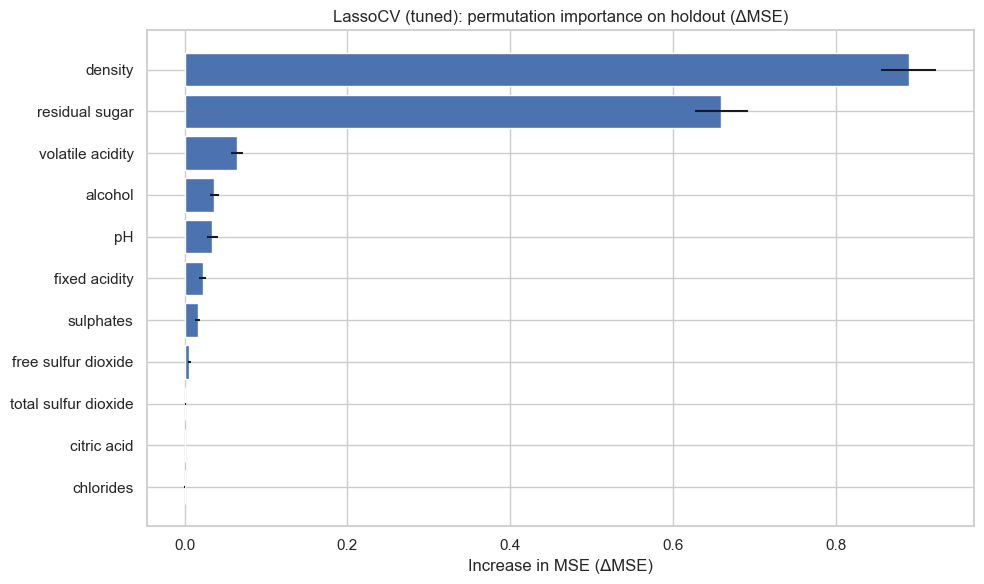

Bootstrap stability (tuned Lasso): top 15 by selection frequency:
             feature  selection_freq  coef_mean  coef_std
             alcohol          1.0000     0.1350    0.0489
             density          1.0000    -0.6520    0.0844
       fixed acidity          1.0000     0.0900    0.0283
 free sulfur dioxide          1.0000     0.0411    0.0241
                  pH          1.0000     0.1462    0.0237
      residual sugar          1.0000     0.5282    0.0502
           sulphates          1.0000     0.0611    0.0166
total sulfur dioxide          1.0000     0.0175    0.0182
    volatile acidity          1.0000    -0.1912    0.0139
         citric acid          0.9750     0.0016    0.0111
           chlorides          0.9250     0.0070    0.0118


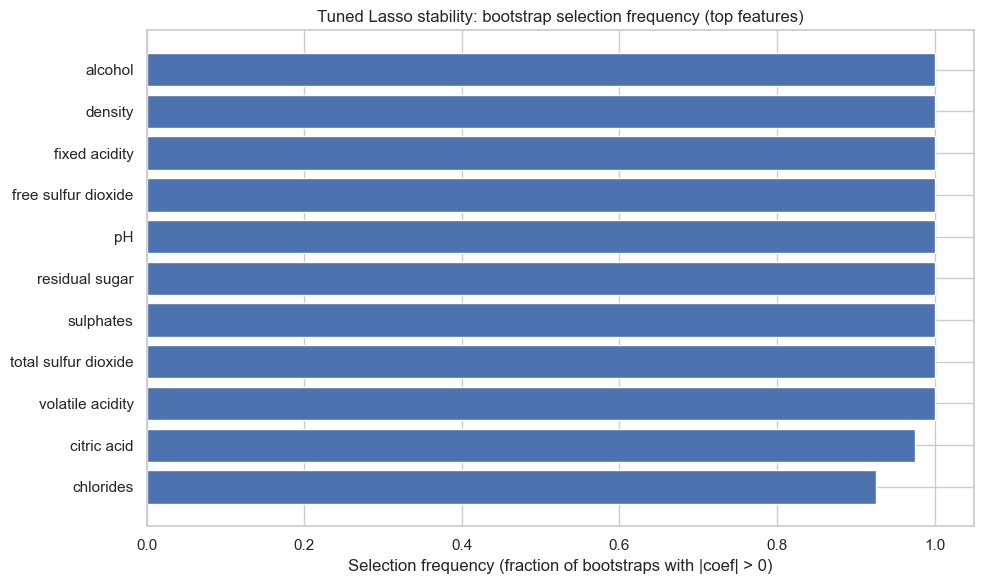

Permutation importance comparison: OLS vs tuned Lasso
             feature  ols_delta_mse  lasso_delta_mse
             density         0.9382           0.8895
      residual sugar         0.6879           0.6593
    volatile acidity         0.0645           0.0646
                  pH         0.0360           0.0342
             alcohol         0.0325           0.0365
       fixed acidity         0.0241           0.0222
           sulphates         0.0163           0.0159
 free sulfur dioxide         0.0055           0.0057
total sulfur dioxide         0.0007           0.0006
         citric acid        -0.0000           0.0000
           chlorides        -0.0001          -0.0001


In [19]:
import inspect

# --- Lasso with alpha=0.01 ---
lasso_alpha = 0.01
lasso_001 = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", Lasso(alpha=lasso_alpha, random_state=RANDOM_STATE, max_iter=5000)),
])

lasso001_results = evaluate_regression(
    lasso_001, X_train, y_train, X_holdout, y_holdout,
    model_name="Lasso (alpha=0.01)", cv_folds=5
)

print("Lasso(alpha=0.01) — Mean squared error (train):   %.3f" % lasso001_results["train_mse"])
print("Lasso(alpha=0.01) — Mean squared error (holdout): %.3f" % lasso001_results["holdout_mse"])

lasso001_coef = lasso_001.named_steps["lasso"].coef_
lasso001_table = (pd.DataFrame({
    "feature": X_train.columns,
    "coef": lasso001_coef,
    "abs_coef": np.abs(lasso001_coef),
})
.sort_values("abs_coef", ascending=True)
.reset_index(drop=True))

least_info_lasso001 = lasso001_table.loc[0, "feature"]
print(f"Least informative feature for Lasso(alpha=0.01) (closest coefficient to 0): {least_info_lasso001}")
print_df(lasso001_table, title="Lasso(alpha=0.01) coefficients (sorted by |coef| ascending):")

# Show most influential coefficients (direction lens)
lasso001_sorted = (pd.DataFrame({"feature": X_train.columns, "coef": lasso001_coef})
                   .assign(abs_coef=lambda d: d["coef"].abs())
                   .sort_values("abs_coef", ascending=False))

top_pos = lasso001_sorted.sort_values("coef", ascending=False).head(8)
top_neg = lasso001_sorted.sort_values("coef", ascending=True).head(8)
coef_bar = pd.concat([top_neg, top_pos], axis=0)

plt.figure(figsize=(10, 6))
sns.barplot(data=coef_bar, x="coef", y="feature")
plt.title("Lasso(alpha=0.01): strongest coefficients (direction + standardized effect size)")
plt.xlabel("Coefficient (standardized)")
plt.ylabel("")
plt.tight_layout()
plt.show()

# --- LassoCV tuning ---
alphas = np.logspace(-6, 2, 200)

lasso_cv_kwargs = dict(alphas=alphas, cv=5, max_iter=5000)
if "random_state" in inspect.signature(LassoCV).parameters:
    lasso_cv_kwargs["random_state"] = RANDOM_STATE

lasso_cv = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso_cv", LassoCV(**lasso_cv_kwargs)),
])

lasso_cv_results = evaluate_regression(
    lasso_cv, X_train, y_train, X_holdout, y_holdout,
    model_name="LassoCV (tuned alpha)", cv_folds=5
)

chosen_alpha = lasso_cv.named_steps["lasso_cv"].alpha_
print(f"LassoCV — chosen alpha: {chosen_alpha:.6f}")
print("LassoCV — Mean squared error (train):   %.3f" % lasso_cv_results["train_mse"])
print("LassoCV — Mean squared error (cv):      %.3f" % lasso_cv_results["cv_mse"])
print("LassoCV — Mean squared error (holdout): %.3f" % lasso_cv_results["holdout_mse"])

# optional: variability across folds
print("LassoCV — CV MSE std:                  %.3f" % lasso_cv_results["cv_mse_std"])

lasso_cv_coef = lasso_cv.named_steps["lasso_cv"].coef_
lasso_cv_table = (pd.DataFrame({
    "feature": X_train.columns,
    "coef": lasso_cv_coef,
    "abs_coef": np.abs(lasso_cv_coef),
})
.sort_values("abs_coef", ascending=True)
.reset_index(drop=True))

least_info_lasso_cv = lasso_cv_table.loc[0, "feature"]
print(f"Least informative feature for tuned LassoCV (closest coefficient to 0): {least_info_lasso_cv}")
print_df(lasso_cv_table, title="LassoCV coefficients (sorted by |coef| ascending):")

# Regularization path (effect of alpha on which features survive)
alphas_path, coefs_path, _ = lasso_path(X_train_scaled, y_train.values, alphas=alphas)
plot_lasso_path(alphas_path, coefs_path, feature_names=list(X_train.columns), top_k=10)

# Permutation importance: impact on error for both Lasso variants
lasso001_perm = compute_permutation_importance(
    lasso_001, X_holdout, y_holdout, feature_names=list(X_train.columns), n_repeats=30
)
lasso_cv_perm = compute_permutation_importance(
    lasso_cv, X_holdout, y_holdout, feature_names=list(X_train.columns), n_repeats=30
)

print_df(lasso001_perm, title="Lasso(alpha=0.01) permutation importance on holdout (ΔMSE):")
plot_permutation_importance(lasso001_perm, top_k=12, title="Lasso(alpha=0.01): permutation importance on holdout (ΔMSE)")

print_df(lasso_cv_perm, title="LassoCV (tuned) permutation importance on holdout (ΔMSE):")
plot_permutation_importance(lasso_cv_perm, top_k=12, title="LassoCV (tuned): permutation importance on holdout (ΔMSE)")

# Stability: bootstrap selection frequency for the tuned alpha
stability_df = bootstrap_lasso_stability(
    X_train, y_train, alpha=chosen_alpha, n_bootstraps=40, random_state=RANDOM_STATE
)

print_df(stability_df.head(15), title="Bootstrap stability (tuned Lasso): top 15 by selection frequency:")

plt.figure(figsize=(10, 6))
top_stable = stability_df.head(12).iloc[::-1]
plt.barh(top_stable["feature"], top_stable["selection_freq"])
plt.title("Tuned Lasso stability: bootstrap selection frequency (top features)")
plt.xlabel("Selection frequency (fraction of bootstraps with |coef| > 0)")
plt.ylabel("")
plt.tight_layout()
plt.show()


compare = (ols_perm[["feature", "delta_mse_mean"]]
           .rename(columns={"delta_mse_mean": "ols_delta_mse"})
           .merge(lasso_cv_perm[["feature", "delta_mse_mean"]]
                  .rename(columns={"delta_mse_mean": "lasso_delta_mse"}),
                  on="feature")
           .sort_values("ols_delta_mse", ascending=False))

print_df(compare, title="Permutation importance comparison: OLS vs tuned Lasso")


<details>
<summary><span style="color:red">about this block:</span></summary>  

### 0) `import inspect`

By using this we can **safely pass `random_state` to `LassoCV` only if that parameter exists** in the installed sklearn version:

```python
if "random_state" in inspect.signature(LassoCV).parameters:
    lasso_cv_kwargs["random_state"] = RANDOM_STATE
```

That prevents version-specific errors.


### 1) Lasso with a fixed $\alpha = 0.01$

### Build the model (with correct scaling)

```python
lasso_001 = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", Lasso(alpha=0.01, random_state=..., max_iter=5000)),
])
```

Why a pipeline?

* **Lasso is scale-sensitive**: if we don’t scale, features with larger units can dominate just because of scale.
* Pipeline ensures scaling happens **properly inside CV folds** when we later do cross-validation inside `evaluate_regression`.

#### Evaluate it

```python
lasso001_results = evaluate_regression(...)
```

This returns metrics like:

* `train_mse`: fit + evaluate on training data
* `cv_mse`: 5-fold CV estimate on training set (generalization estimate)
* `holdout_mse`: one-time check on the holdout split

Then we print train/holdout MSE.


### 2) Extract + rank coefficients (what Lasso “keeps” vs shrinks)

```python
lasso001_coef = lasso_001.named_steps["lasso"].coef_
```

This gives a coefficient for each feature **after scaling** (so magnitudes are comparable).

Then we build a table sorted by absolute coefficient:

```python
.sort_values("abs_coef", ascending=True)
```

So the *top row* is the coefficient **closest to 0** → the feature Lasso is treating as least useful under $\alpha=0.01$.

We also create a barplot of the strongest positive and negative coefficients:

* **positive coef** → increases predicted quality
* **negative coef** → decreases predicted quality
* magnitudes reflect **standardized linear effect sizes**, not causality


### 3) LassoCV: choose $\alpha$ by cross-validation

#### Define an alpha grid

```python
alphas = np.logspace(-6, 2, 200)
```

This tests $\alpha$ from:

* very weak penalty ($10^{-6}$)
* to very strong penalty ($10^2$)

### Build LassoCV pipeline

```python
lasso_cv = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso_cv", LassoCV(alphas=alphas, cv=5, ...)),
])
```

What LassoCV does internally:

* It tries each $\alpha$
* runs 5-fold CV
* chooses the $\alpha$ that minimizes CV error (typically MSE)

Then we evaluate the whole pipeline again with our `evaluate_regression(...)`.

⚠️ Important subtlety:

* **Inside LassoCV** we already have CV to choose alpha.
* **Outside**, our `evaluate_regression(..., cv_folds=5)` is doing *another* CV on the training set.

So our printed `lasso_cv_results["cv_mse"]` is effectively:

> “outer 5-fold CV performance of a pipeline that itself uses inner CV to pick $\alpha$”

It’s not “wrong”, but it’s computationally heavier and conceptually close to *nested CV-lite*.

We print:

* chosen alpha
* train MSE
* CV MSE
* holdout MSE
* CV std (how variable fold performance was)


### 4) LassoCV coefficient table

Same idea as before, but now coefficients correspond to the **CV-chosen alpha**.

This is our “regularized story” version of OLS coefficients.


### 5) Lasso regularization path

```python
alphas_path, coefs_path, _ = lasso_path(X_train_scaled, y_train.values, alphas=alphas)
plot_lasso_path(...)
```

This shows how coefficients evolve as $\alpha$ changes:

* large $\alpha$ → heavy shrinkage → most coefficients go to 0
* small $\alpha$ → looks more like OLS

It’s a great visual for *when features enter/leave the model* and how correlated groups behave.


### 6) Permutation importance for both Lasso variants (impact on error)

```python
lasso001_perm = compute_permutation_importance(lasso_001, X_holdout, y_holdout, ...)
lasso_cv_perm  = compute_permutation_importance(lasso_cv,  X_holdout, y_holdout, ...)
```

This answers a different question than coefficients:

* **Coefficients**: “direction + standardized linear association”
* **Permutation importance**: “if I scramble this feature in the holdout set, how much does MSE increase?”

Since our `compute_permutation_importance` uses:

```python
scoring="neg_mean_squared_error"
```

our reported `delta_mse_mean` is effectively:
$$
\Delta \text{MSE} = \text{MSE}_{\text{permuted}} - \text{MSE}_{\text{original}}
$$
Bigger = feature matters more for predictive accuracy.

Then we plot the top features with error bars (`delta_mse_std`).


## 7) Bootstrap stability (robustness of selection)

```python
stability_df = bootstrap_lasso_stability(X_train, y_train, alpha=chosen_alpha, ...)
```

This does:

* repeatedly resample the training data **with replacement**
* fit Lasso with the tuned alpha
* record which coefficients are non-zero

Output includes:

* `selection_freq`: fraction of bootstraps where $|\beta_j| > \epsilon$
* `coef_mean`, `coef_std`: how stable the coefficient value is

This is how we answer:

> “Is Lasso’s ‘feature selection’ stable or just an artifact of sample noise?”

Then we plot the most stable features.


### 8) Compare OLS vs LassoCV permutation importance (do they rely on the same signals?)

```python
compare = (
    ols_perm[...]
    .merge(lasso_cv_perm[...], on="feature")
    .sort_values("ols_delta_mse", ascending=False)
)
```

This makes a single table like:

| feature | OLS ΔMSE | Lasso ΔMSE |
| ------- | -------: | ---------: |

So we can see if regularization changes what actually drives predictive accuracy.


# Big picture: what this whole block accomplishes

We’re building **three complementary explanations** for Lasso:

1. **Coefficients** → direction + standardized linear association
2. **Permutation importance** → impact on predictive error on unseen data
3. **Bootstrap stability** → how robust the selected predictors are

…and then we compare the “impact” story (permutation importance) against OLS to see what regularization changes.

</details>


### **Lasso results: shrinkage without a big performance shift**

In cross-validation, Lasso ends up very close to OLS:

- **OLS CV MSE:** ≈ 0.5605  
- **LassoCV CV MSE:** ≈ 0.5604  
- **Lasso(α=0.01) CV MSE:** ≈ 0.5656  

So regularization doesn’t buy a clear generalization win here, at least within this search space. The most telling sign is the tuned value:

- **LassoCV chose α ≈ 0.000283**, which is *very small*, meaning the best CV solution is only lightly regularized and behaves a lot like OLS.

Holdout MSE differences exist (e.g., α=0.01 is slightly better on this particular split), but CV suggests those gaps are not robust enough to treat as a meaningful “winner” among linear models.


## **What Lasso adds (even when accuracy is similar)**

### **1) Sparsity / redundancy hints**
With **α = 0.01**, several coefficients are pushed to (almost) zero (e.g., fixed acidity, citric acid, total sulfur dioxide). That’s a useful signal: these features are likely **redundant given the rest**.

### **2) “What matters” stays largely the same**
Permutation importance for tuned Lasso is nearly identical to OLS:
- **density** and **residual sugar** dominate,
- followed by **volatile acidity**, then smaller effects.

So Lasso doesn’t fundamentally change which signals the linear model relies on, it mostly changes how the weight is distributed among correlated features.

### **3) Stability is the reality check**
Bootstrap stability helps separate robust signals from fragile “selected” features:
- Many predictors appear consistently (high selection frequency), but some have **tiny mean coefficients** even when selected often.
- That’s a good reminder that “selected” ≠ “important,” especially when α is small and many coefficients hover near zero.

**Key takeaways**
- Lasso is most valuable here as a *redundancy / stability lens*, not as a performance booster.
- CV-selected α being very small implies the data doesn’t demand heavy shrinkage to generalize well.
- This strengthens the case that the next big gain, if it exists, will come from **non-linearity and interactions**, not from linear regularization.


> *Because LassoCV optimized predictive error, it selected a very small $\alpha$, yielding a model close to OLS. If we want a sparse “explanation model,” we’d deliberately choose a larger $\alpha$ that trades a small amount of accuracy for a simpler, more selective feature set.*

>an “explanation model” means: A model built primarily to understand and explain relationships in the data, not just to maximize prediction accuracy.

<details>
<summary><span style="color:red"> 

Isn’t such a small $\alpha$ weird?</span></summary>  

Not weird at all! it’s actually a common outcome, and it usually means **the data + our evaluation objective didn’t reward sparsity**.

Here’s what’s going on in our run.

### 1) LassoCV chooses $\alpha$ to minimize **CV prediction error**, not to maximize sparsity

LassoCV is solving:

$$
\alpha^* = \arg\min_{\alpha} \text{CV-MSE}(\alpha)
$$

If stronger regularization (bigger $\alpha$) makes coefficients zero **but increases CV error**, CV will pick a smaller $\alpha$. So the algorithm is basically saying:

> “Keeping more features (less shrinkage) predicts slightly better.”

That’s exactly what our chosen $\alpha \approx 2.83\times 10^{-4}$ implies.

### 2) Our dataset likely has enough samples that OLS isn’t very high-variance

We have ~3,428 training rows and only 11 features. That’s a very “easy” ratio for linear regression. With this much data relative to $p$ (the number of predictors / features in our model), OLS coefficients can already be fairly stable, so Lasso doesn’t gain much by shrinking hard.

<span style="font-size:24px; color:hotpink;">

When $n \gg p$ (like our case), OLS is often already fairly stable, so regularization like Lasso may not help much unless there’s heavy noise, multicollinearity issues, or you want sparsity for interpretability.

</span>

In other words: **variance isn’t our main problem**, so regularization isn’t strongly needed to improve generalization.

### 3) Correlated features don’t automatically mean Lasso will choose one

Correlation *creates* redundancy, but whether Lasso benefits depends on whether that redundancy causes overfitting enough to hurt CV error. Sometimes:

* correlated features are all carrying small complementary signal
* removing any one makes predictions slightly worse
  So CV keeps them.

### 4) Our own results support this: tuned Lasso ≈ OLS

- **OLS CV MSE:** ≈ 0.5605  
- **LassoCV CV MSE:** ≈ 0.5604  

Basically identical. That’s a strong sign the best linear model here doesn’t need much regularization.

### 5) Why does $\alpha=0.01$ look better on *holdout* then?

We saw:

* Lasso($\alpha=0.01$) holdout MSE: **0.574** (better)
* LassoCV picks $\alpha\approx0.000283$ and gets holdout MSE: **0.583**

This can happen because:

* CV is an *average* over folds → it may prefer a smaller $\alpha$ that is slightly better on average
* our single holdout split might favor slightly stronger regularization by chance
* differences are small enough that fold variance can change the minimum

So it’s not “wrong,” it’s just that **the minimum of CV error may be shallow**, and multiple $\alpha$ values perform similarly.

### 6) If you *want* sparsity, use the 1-SE rule

Many people don’t pick the $\alpha$ with the absolute minimum CV error. They pick the **largest $\alpha$** whose CV error is within **one standard error** of the minimum (simpler model with similar performance). This is called the **one-standard-error rule**.

That would likely give you a larger $\alpha$ and a sparser model, with only a tiny loss in error.

### Bottom line

A weak $\alpha$ is not weird, it usually means:

* OLS is already stable (lots of data, few features)
* sparsity doesn’t improve CV error much
* many $\alpha$ values perform similarly, so the optimum is shallow

</details>

## **6) Model 3 — Random Forest: non-linearity and interactions without feature engineering**

Linear models give clarity, but our EDA hinted at curvature and interactions (e.g., “helpful up to a point” effects). **Random Forest** changes the bias profile:

- captures **non-linearities** and **feature interactions** automatically,
- is relatively robust to outliers and monotonic transforms,
- but needs different interpretability tools (importance, PDP, SHAP) instead of coefficients.

We’ll run two versions:
1. **Default Random Forest** (only `random_state=17`)  
2. **Tuned Random Forest** via `GridSearchCV` over:
   - `max_depth` in 10..24  
   - `max_features` in 6..11  

Then we interpret with:
- **Built-in feature importance** (fast, but can be biased),
- **Permutation importance on holdout** (model-agnostic, tied to error),
- **PDP** (Partial Dependence Plots) to visualize effect shapes,
- **SHAP** for global + local, per-wine explanations.



RF (default) — Mean squared error (train):   0.053
RF (default) — Mean squared error (cv):      0.414
RF (default) — Mean squared error (holdout): 0.371
RF (default) - Holdout RMSE: 0.609
RF (default) - Holdout R²:   0.524

Tuned RF — best parameters: {'max_depth': 21, 'max_features': 6}
Tuned RF — CV MSE (from GridSearchCV): 0.398
Tuned RF — Train MSE:   0.054
Tuned RF — Holdout MSE:                0.366
Tuned RF - Holdout R²:   0.530
Random Forest most important feature (built-in importance): alcohol
Tuned RF built-in feature importances:
             feature  importance
             alcohol      0.2061
    volatile acidity      0.1176
 free sulfur dioxide      0.1116
             density      0.0885
                  pH      0.0737
total sulfur dioxide      0.0736
           chlorides      0.0734
      residual sugar      0.0721
         citric acid      0.0626
       fixed acidity      0.0618
           sulphates      0.0591


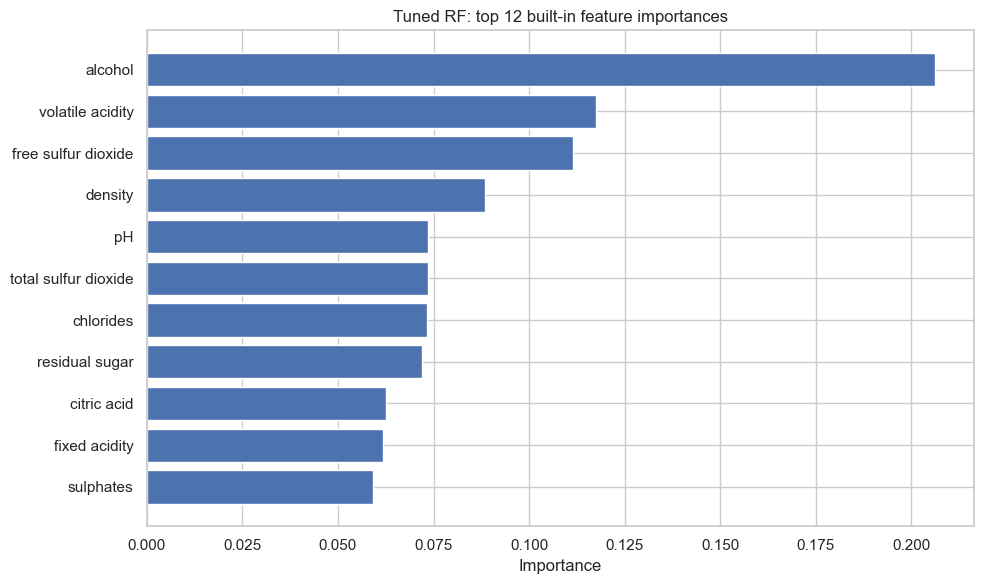

Tuned RF permutation importance on holdout (ΔMSE): top 15
             feature  delta_mse_mean  delta_mse_std
             alcohol          0.3098         0.0138
    volatile acidity          0.1573         0.0101
 free sulfur dioxide          0.0860         0.0090
      residual sugar          0.0568         0.0050
             density          0.0487         0.0033
           chlorides          0.0451         0.0042
                  pH          0.0391         0.0036
         citric acid          0.0315         0.0024
total sulfur dioxide          0.0304         0.0025
           sulphates          0.0262         0.0019
       fixed acidity          0.0197         0.0024


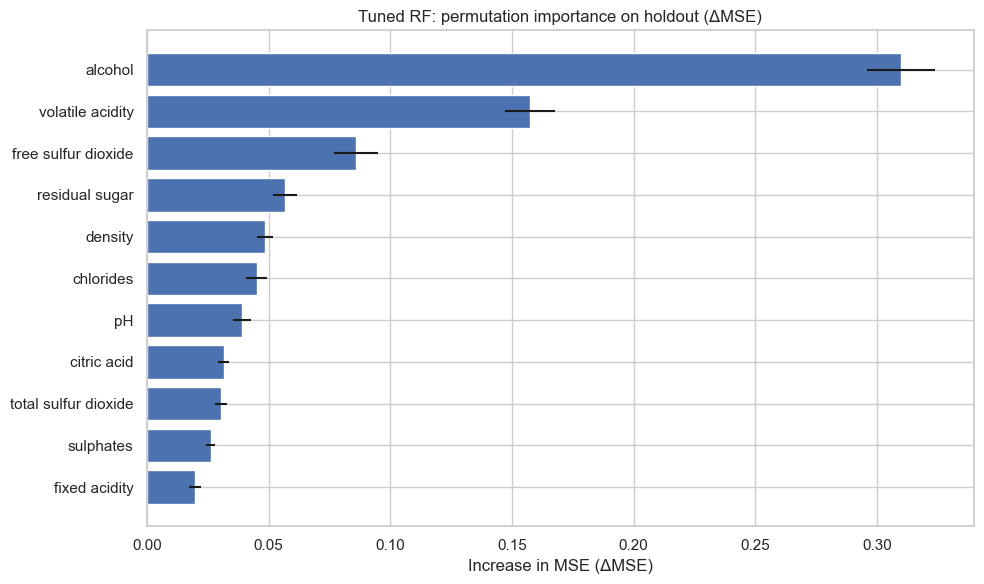

PDP features (tuned RF): ['alcohol', 'volatile acidity', 'free sulfur dioxide']


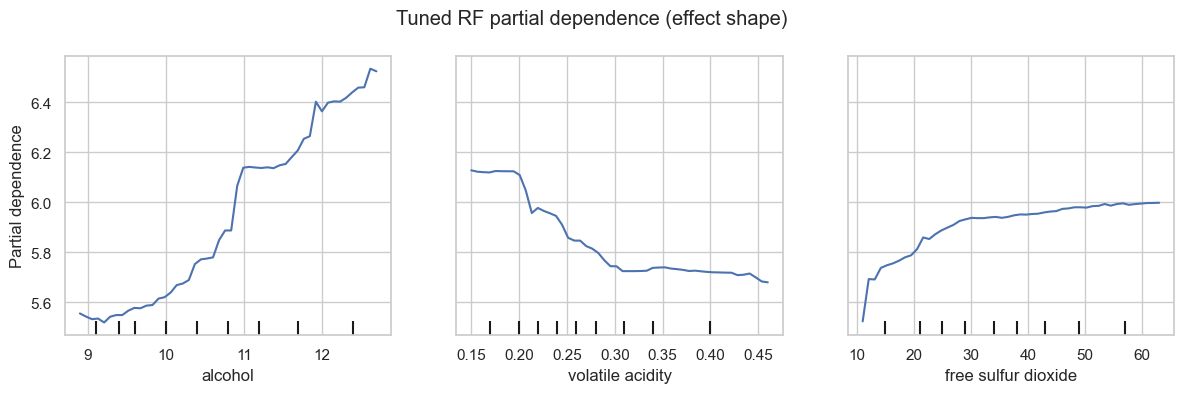

In [20]:
# --- Random Forest (default) ---
rf_default = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
rf_default.fit(X_train, y_train)

rf_default_train_pred = rf_default.predict(X_train)
rf_default_holdout_pred = rf_default.predict(X_holdout)

rf_default_train_mse = mean_squared_error(y_train, rf_default_train_pred)
rf_default_holdout_mse = mean_squared_error(y_holdout, rf_default_holdout_pred)

rf_default_cv_scores = cross_val_score(
    rf_default, X_train, y_train,
    scoring="neg_mean_squared_error",
    cv=5,
    n_jobs=-1
)
rf_default_cv_mse = -rf_default_cv_scores.mean()

print("RF (default) — Mean squared error (train):   %.3f" % rf_default_train_mse)
print("RF (default) — Mean squared error (cv):      %.3f" % rf_default_cv_mse)
print("RF (default) — Mean squared error (holdout): %.3f" % rf_default_holdout_mse)
print("RF (default) - Holdout RMSE: %.3f" % np.sqrt(rf_default_holdout_mse))
print("RF (default) - Holdout R²:   %.3f" % r2_score(y_holdout, rf_default_holdout_pred))

# --- Random Forest (tuned with GridSearchCV) ---
param_grid = {
    "max_depth": list(range(10, 25)),
    "max_features": list(range(6, 12)),
}

rf_base = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)

rf_grid = GridSearchCV(
    rf_base,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=5,
    n_jobs=-1,
    refit=True,
)

rf_grid.fit(X_train, y_train)

best_rf = rf_grid.best_estimator_
best_params = rf_grid.best_params_
best_cv_mse = -rf_grid.best_score_


best_train_pred = best_rf.predict(X_train)
best_train_mse = mean_squared_error(y_train, best_train_pred)


best_holdout_pred = best_rf.predict(X_holdout)
best_holdout_mse = mean_squared_error(y_holdout, best_holdout_pred)

print("\nTuned RF — best parameters:", best_params)
print("Tuned RF — CV MSE (from GridSearchCV): %.3f" % best_cv_mse)
print("Tuned RF — Train MSE:   %.3f" % best_train_mse)
print("Tuned RF — Holdout MSE:                %.3f" % best_holdout_mse)
print("Tuned RF - Holdout R²:   %.3f" % r2_score(y_holdout, best_holdout_pred))

# Feature importance (built-in, model-specific)
rf_importance = (pd.DataFrame({
    "feature": X_train.columns,
    "importance": best_rf.feature_importances_,
})
.sort_values("importance", ascending=False)
.reset_index(drop=True))

top_rf_feature = rf_importance.loc[0, "feature"]
print(f"Random Forest most important feature (built-in importance): {top_rf_feature}")
print_df(rf_importance, title="Tuned RF built-in feature importances:")

plt.figure(figsize=(10, 6))
top_k = 12
top_imp = rf_importance.head(top_k).iloc[::-1]
plt.barh(top_imp["feature"], top_imp["importance"])
plt.title(f"Tuned RF: top {top_k} built-in feature importances")
plt.xlabel("Importance")
plt.ylabel("")
plt.tight_layout()
plt.show()

# Permutation importance on holdout (more robust: impact on error)
rf_perm = compute_permutation_importance(
    best_rf, X_holdout, y_holdout, feature_names=list(X_train.columns), n_repeats=30
)
print_df(rf_perm.head(15), title="Tuned RF permutation importance on holdout (ΔMSE): top 15")
plot_permutation_importance(rf_perm, top_k=12, title="Tuned RF: permutation importance on holdout (ΔMSE)")

# Effect shape check (PDP) for top 3 RF drivers by permutation importance
rf_top_pdp = list(rf_perm["feature"].head(3))
print("PDP features (tuned RF):", rf_top_pdp)

fig, ax = plt.subplots(figsize=(12, 4))
PartialDependenceDisplay.from_estimator(
    best_rf, X_train, features=rf_top_pdp, ax=ax, grid_resolution=50
)
plt.suptitle("Tuned RF partial dependence (effect shape)")
plt.tight_layout()
plt.show()


<details>
<summary><span style="color:red">about this block:</span></summary>  


### 1) Default Random Forest: fit once, measure train/CV/holdout

#### Build + fit

```python
rf_default = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
rf_default.fit(X_train, y_train)
```

* `RandomForestRegressor` = an ensemble of decision trees trained on bootstrapped samples, averaged for prediction.
* `random_state` makes results reproducible.
* `n_jobs=-1` uses all CPU cores.

#### Predict on train + holdout

```python
rf_default_train_pred = rf_default.predict(X_train)
rf_default_holdout_pred = rf_default.predict(X_holdout)
```

#### Compute train & holdout MSE

```python
rf_default_train_mse = mean_squared_error(y_train, rf_default_train_pred)
rf_default_holdout_mse = mean_squared_error(y_holdout, rf_default_holdout_pred)
```

Interpretation:

* **Train MSE** shows how well the model fits the training data.
* **Holdout MSE** is the “one-time” generalization check on unseen data.

#### Cross-validated MSE on the training set

```python
rf_default_cv_scores = cross_val_score(
    rf_default, X_train, y_train,
    scoring="neg_mean_squared_error",
    cv=5,
    n_jobs=-1
)
rf_default_cv_mse = -rf_default_cv_scores.mean()
```

What’s happening:

* Training data is split into **5 folds**.
* For each fold: fit on 4 folds, validate on 1 fold.
* We get 5 MSE values (as *negative* scores because sklearn treats “higher is better”).
* We flip the sign back and average.

Why CV here?

* It estimates generalization **more reliably than a single split**.
* It also tells us if a good holdout result might just be “luck”.


### 2) Tuned Random Forest via GridSearchCV

#### Define the hyperparameter grid

```python
param_grid = {
    "max_depth": list(range(10, 25)),
    "max_features": list(range(6, 12)),
}
```

* `max_depth`: limits how deep each tree can grow (controls complexity).
* `max_features`: how many features are considered at each split (adds randomness; can reduce variance).


<details>
<summary><span style="color:red">

More on `max_features`:</span></summary>   

In a **Random Forest**, `max_features` controls **how many features the model is allowed to “look at” when choosing each split** inside each decision tree.

#### What it means exactly

At **every split node** in a tree:

1. The algorithm randomly selects a subset of the input features of size `max_features`.
2. It then finds the **best split** *only among that subset* (not among all features).

So with our grid:

```python
"max_features": list(range(6, 12))
```

and we have **11 features total**, it means:

* If `max_features = 6`, each split considers **6 randomly chosen features** out of 11.
* If `max_features = 11`, each split considers **all 11 features** (so it behaves more like bagged trees; less randomness in splits).

#### Why it matters (intuition)

`max_features` is a **variance-control knob**:

* **Smaller `max_features`** → more randomness → trees become **less similar** → averaging helps more → often **better generalization**, but can increase bias a bit.
* **Larger `max_features`** → less randomness → trees become **more similar** → can overfit more easily, but sometimes reduces bias.

That’s why tuning it often helps.

#### Common defaults (useful context)

In scikit-learn:

* For **RandomForestRegressor**, default is `max_features=1.0` → meaning **all features** (i.e., `n_features`).
* Historically/elsewhere (and in many textbooks), you’ll often see **sqrt(p)** used as a default rule of thumb, but sklearn’s regressor default is “all”.

#### In our case

We have **p = 11** features.

Our tuned winner earlier was:

* `max_features = 6`

So our best model preferred **not** letting every split see all features, which is consistent with:

* **reducing overfitting**
* **decorrelating trees**
* handling correlated predictors more robustly


“Bagged trees” means **many decision trees trained independently on bootstrap samples of the training data**, and then **averaged** (for regression) or **majority-voted** (for classification).

#### Break it down

**Bagging** = *bootstrap aggregating*:

1. **Bootstrap sampling:** for each tree, we create a new training set by sampling the original training rows **with replacement** (so some rows repeat, some are left out).
2. **Train a full decision tree** on that bootstrap sample (often deep / high-variance).
3. **Aggregate predictions:**

   * regression: average the tree predictions
   * classification: majority vote / average probabilities

#### How it relates to Random Forest

* A **Random Forest** = **bagged trees + extra randomness in features**

  * bagging randomness: different rows per tree (bootstrap)
  * feature randomness: at each split, only a subset of features (`max_features`) is considered

So if we set `max_features = all features`, a Random Forest becomes *very close to* plain **bagged trees** (still a “RandomForest” in sklearn, but without the feature-subsampling trick that decorrelates trees).

#### Why bagging helps

A single deep tree has **high variance** (it changes a lot if the data changes slightly).
Averaging many such trees trained on slightly different samples **reduces variance**, usually improving generalization.

</details>

#### Run grid search

```python
rf_grid = GridSearchCV(
    rf_base,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=5,
    n_jobs=-1,
    refit=True,
)
rf_grid.fit(X_train, y_train)
```

What this does:

* Tries **every combination** of `max_depth × max_features`.
* Uses **5-fold CV** inside the grid search to score each combo.
* Picks the best combo (lowest CV MSE).
* `refit=True` means it then **refits** the best model on the *full training set*.

#### Extract the best model and its CV score

```python
best_rf = rf_grid.best_estimator_
best_params = rf_grid.best_params_
best_cv_mse = -rf_grid.best_score_
```

* `best_params` is what the grid search chose.
* `best_cv_mse` is the mean CV MSE of that winning configuration.

#### Evaluate tuned model on train + holdout

```python
best_train_pred = best_rf.predict(X_train)
best_train_mse = mean_squared_error(y_train, best_train_pred)

best_holdout_pred = best_rf.predict(X_holdout)
best_holdout_mse = mean_squared_error(y_holdout, best_holdout_pred)
```

Interpretation:

* **Train MSE**: how hard it can fit the training set.
* **Holdout MSE**: whether that improved fit transfers to unseen data.

So this section answers:

> “Does tuning help generalization or just reduce training error?”


### 3) Built-in feature importance (quick but imperfect)

```python
best_rf.feature_importances_
```

This is the **impurity-based importance**:

* Each split in each tree reduces impurity (variance for regression).
* Features that reduce impurity a lot across many trees get high importance.

We wrap it into a sorted dataframe and plot the top 12.

Important caveat:

* This can be biased toward features with more “split opportunities”
* It can be unstable with correlated features
  So it’s **useful as a quick signal**, but not the most trustworthy “impact” measure.


### 4) Permutation importance on holdout (impact on predictive error)

```python
rf_perm = compute_permutation_importance(
    best_rf, X_holdout, y_holdout, ..., n_repeats=30
)
```

Conceptually:

* Measure baseline holdout MSE.
* For each feature:

  * shuffle that feature’s values **in the holdout set** (break its relationship to y)
  * recompute MSE
  * record how much MSE increases
* Repeat 30 times to average out randomness.

So this answers:

> “Which features does the trained RF actually rely on to reduce holdout error?”

This is usually more faithful than built-in importance because it’s tied directly to the evaluation metric.


### 5) PDP = Partial Dependence Plot (effect “shape”)

```python
PartialDependenceDisplay.from_estimator(
    best_rf, X_train, features=rf_top_pdp, ...
)
```

PDP shows, for each feature:

* vary that feature across a grid of values
* keep others as they are in the data
* average the model’s predictions

So it answers:

> “On average, how does changing this feature change predictions?”

Why we choose top 3 features from permutation importance:

* those are the features that most affect **prediction error**
* PDP then shows *how* they affect the prediction (linear? threshold? plateau? etc.)

Why use `X_train` instead of holdout for PDP?

* It’s common to compute PDP on training data (more samples, stable averages).
* Also avoids repeatedly poking the holdout for exploratory plots.


### What this RF section gives us (in our framework)

We’re basically replicating the same lenses we used for linear models, but adapted to RF:

1. **Performance:** training, CV, and holdout MSE  
2. **Global interpretability:**  
   * built-in feature importance (fast, but can be biased)  
   * permutation importance (directly tied to predictive error)  
3. **Effect shape:**  
   * PDPs to visualize non-linearities and threshold-style behavior

That’s a strong structure because it doesn’t just say “RF wins”, it explains **why** it wins and **what it learned**.

</details>

### **Random Forest results: what changes when we allow non-linearity?**

#### **Performance: breaking the linear ceiling**
Random Forest is the first model that clearly “breaks out” of the linear regime:

- Linear models (OLS / LassoCV) sit around **CV MSE ≈ 0.560** (CV RMSE ≈ 0.749).
- **Tuned RF reaches CV MSE ≈ 0.398** (CV RMSE ≈ 0.631).

That’s a large gap, and because it shows up in **cross-validation**, it’s strong evidence that wine quality depends on **non-linear effects and/or interactions** that linear models cannot capture.

<details>
<summary><span style="color:red">Non-linear effects vs interactions:</span></summary>   


### Non-linear effects (curvature)

A **non-linear effect** means the relationship between a feature and the target isn’t well described by a straight line.

Example: alcohol helps quality, but it helps *more* after some point (a “knee” / threshold), or it levels off.

Mathematically: the true relationship might look like
$$
y \approx f(x_1) \quad \text{where } f \text{ is not linear.}
$$

OLS assumes something like:
$$
y = \beta_0 + \beta_1 x_1
$$
(one constant slope).

### Interactions (depends-on-another-feature)

An **interaction** means the effect of one feature depends on the value of another feature.

Example: residual sugar might help **only when acidity is high**, but hurt when acidity is low.

In linear models, that would require an explicit interaction term like:
$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 (x_1 x_2)
$$
Without ($x_1x_2$), OLS can’t represent “the slope changes depending on $x_2$.”

### How Random Forest captures both

Random Forest can capture:

* **non-linear effects** via threshold splits (piecewise behavior),
* **interactions** via conditional splits (“if $x_2$ is high, then split on $x_1$ differently”).

### Why the phrase “and/or” is useful

In practice, RF’s big gain over OLS/Lasso could come from:

* mostly **curvature**, or
* mostly **interactions**, or
* a mix of both (very common).

So saying **“non-linear effects and/or interactions”** is accurate because it covers both sources of extra structure that linear models miss unless we explicitly engineer them.


</details>



#### **Generalization check: strong fit + visible overfitting (default vs tuned RF)**
Both RF variants show the same headline pattern: **very low training error** and much higher CV/holdout error.

- **Default RF:** train MSE ≈ 0.053, CV MSE ≈ 0.414, holdout MSE ≈ 0.371  
- **Tuned RF:**  train MSE ≈ 0.054, CV MSE ≈ 0.398, holdout MSE ≈ 0.366  

So tuning doesn’t remove the train–CV gap, but it **does** improve CV and holdout slightly, and the two stay in the same ballpark (good sign that the improvement isn’t “holdout luck”).

> Even with a visible overfitting gap, RF generalizes **much better** than the linear models.


## **Interpretability: why RF tells a different story than OLS/Lasso**

### **Built-in importance vs permutation importance**
Both RF importance methods (impurity-based importance and permutation importance) agree on the headline:

- **Alcohol is the #1 driver** for the tuned forest.

Permutation importance (ΔMSE on holdout) makes the reliance especially clear:
- alcohol ΔMSE ≈ **0.31**
- volatile acidity ΔMSE ≈ **0.16**
- free sulfur dioxide ΔMSE ≈ **0.086**

Everything else is secondary.

### **Why the ranking differs from linear models**
Under OLS/Lasso, **density + residual sugar** dominated. Under RF, **alcohol + volatile acidity + free sulfur dioxide** rise to the top.

A plausible interpretation:

- **Linear models** tend to lean on **density and residual sugar as proxies** inside correlated feature clusters (they carry overlapping information with alcohol), so “credit” can get distributed in a way that’s hard to interpret.  

- **Random Forest**, by contrast, can **untangle those clusters** by learning **threshold-based rules (non-linear effects) and conditional splits (interactions)**, letting it rely more directly on **alcohol and acidity patterns** and capture **interactions** that a single global linear slope can’t express.



### **PDP: effect-shape evidence**
PDPs support the non-linear story:

- **Alcohol:** rising curve with a steeper region around ~10.5–12+, suggesting a **threshold-like effect**, where higher alcohol increasingly pushes wines into higher predicted quality ranges, something OLS can’t model except as a single straight slope. 

> By “threshold-style effect” I mean the relationship looks like it has a **noticeable change** in behavior after some point (a “knee” in the curve), rather than increasing at a constant rate.

- **Volatile acidity:** strong negative effect that flattens at higher values. That’s a “diminishing returns” pattern that linear models can only approximate.  

- **Free sulfur dioxide:** increases quickly then plateaus, beneficial up to a point, then marginal gains fade.

**Key takeaways (RF stage)**
- RF is the clear performance winner in CV (and holdout agrees).
- The model still overfits in the sense of very low train error, but its out-of-sample error is far lower than linear alternatives.
- Permutation importance + PDP tell a coherent story: the forest is exploiting non-linear patterns in alcohol, acidity, and sulfur-related variables.


### **SHAP explainability: what matters *and* how it shifts individual predictions**

Permutation importance and PDPs give us a strong global picture, but they answer *different* questions:

- **Permutation importance asks:**
  > *Which features matter most for predictive accuracy?*  
  > *(If we scramble this feature **in the holdout set**, how much does **holdout MSE** increase?)*

  ```python
  compute_permutation_importance(best_rf, X_holdout, y_holdout, ...)
  ```  

- **PDP asks:**
  > *On average, how does changing one feature affect the prediction?*  
  > *(Here we vary the feature over a grid and average predictions over the **training set** distribution.)*

  ```python
  PartialDependenceDisplay.from_estimator(best_rf, X_train, ...)
  ```

>Tiny note: PDP isn’t “trained on” the training set (the model is already trained); it’s just **computed/averaged over** the rows we pass (`X_train` in our case).



But one key question remains:

> **For a specific wine, which features pushed the prediction up or down, and by how much?**

That’s where **SHAP** (SHapley Additive exPlanations) helps. It attributes each prediction to feature contributions so we can write:

$$
\hat{y} \approx \text{baseline} + \sum_j \phi_j
$$

where $\phi_j$ is feature $j$’s contribution for that particular wine (in **quality points**).

**What the next cell does**
- Imports SHAP safely.
- Computes SHAP values on the holdout set (or a capped sample for speed).
- Produces:
  1. a **global beeswarm** (importance + direction),
  2. a **global bar plot** (mean absolute impact),
  3. a **local waterfall** for one wine (case-level explanation).

If SHAP isn’t available, we fall back to the lightweight tools already used: **permutation importance + PDP**.


 98%|===================| 1436/1470 [00:40<00:00]        

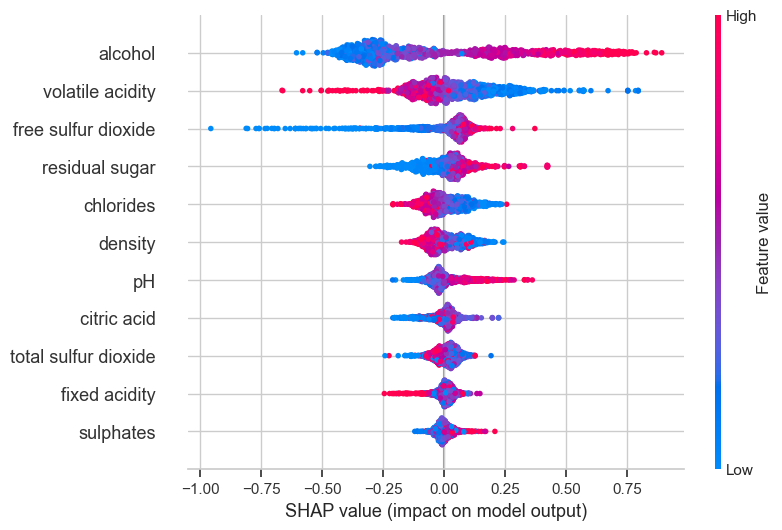

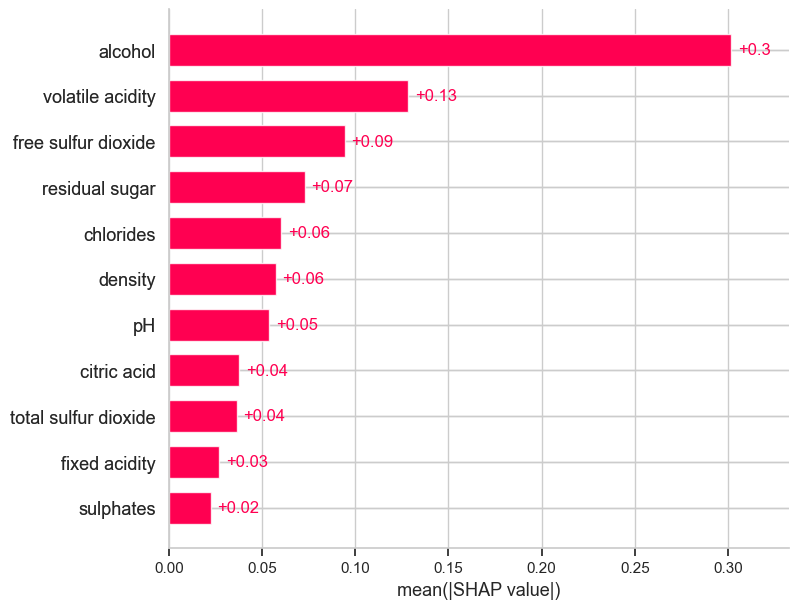

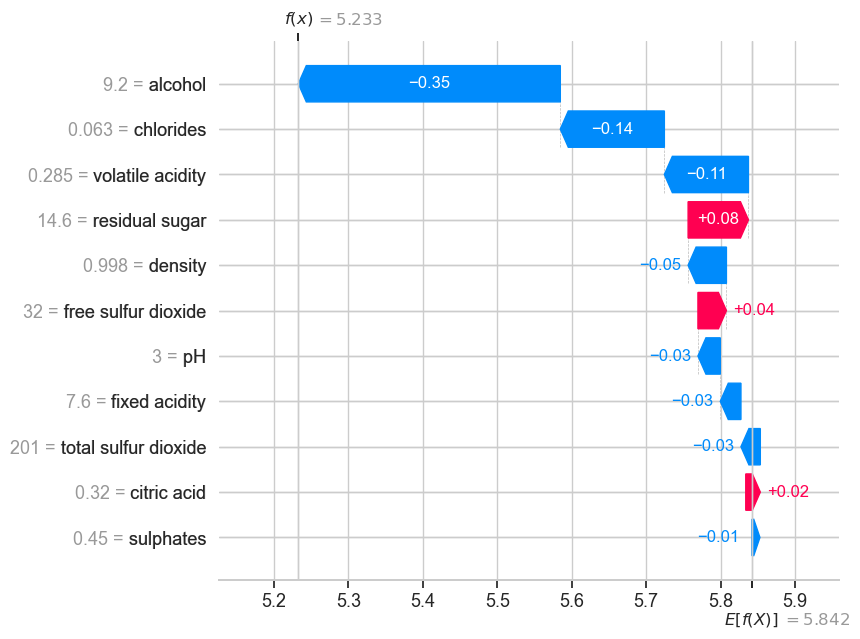

In [21]:
try:
    import shap
    SHAP_AVAILABLE = True
except Exception as e:
    SHAP_AVAILABLE = False
    _shap_import_error = e

if not SHAP_AVAILABLE:
    print("SHAP is not available in this environment. Skipping SHAP plots.")
    print("Import error:", _shap_import_error)
else:
    # Sample holdout for speed
    X_shap = X_holdout.sample(n=max(500, len(X_holdout)), random_state=RANDOM_STATE)

    # Prefer the unified API if available; otherwise fall back to TreeExplainer
    if hasattr(shap, "Explainer"):
        explainer = shap.Explainer(best_rf, X_train)
        shap_values = explainer(X_shap)

        # Global explanations
        shap.plots.beeswarm(shap_values, max_display=15, show=True)
        shap.plots.bar(shap_values, max_display=15, show=True)

        # Local explanation for one wine
        shap.plots.waterfall(shap_values[0], max_display=15, show=True)
    else:
        explainer = shap.TreeExplainer(best_rf)
        shap_values = explainer.shap_values(X_shap)

        shap.summary_plot(shap_values, X_shap, max_display=15, show=True)
        shap.summary_plot(shap_values, X_shap, plot_type="bar", max_display=15, show=True)

        # Local explanation (fallback)
        try:
            shap.waterfall_plot(shap.Explanation(values=shap_values[0], base_values=explainer.expected_value, data=X_shap.iloc[0], feature_names=X_shap.columns))
        except Exception:
            print("Local SHAP waterfall plot not supported in this SHAP version.")


<details>
<summary><span style="color:red">about this block:</span></summary>  

### 1) “Try to import SHAP, but don’t crash if it’s missing”

```python
try:
    import shap
    SHAP_AVAILABLE = True
except Exception as e:
    SHAP_AVAILABLE = False
    _shap_import_error = e
```

* If `import shap` works → set `SHAP_AVAILABLE = True`.
* If it fails (SHAP not installed, version conflict, etc.) → set `SHAP_AVAILABLE = False` and save the error so we can print it.

This is just “defensive coding” so our notebook still runs even without SHAP.


### 2) If SHAP isn’t available, print a clear message and stop

```python
if not SHAP_AVAILABLE:
    print("SHAP is not available in this environment. Skipping SHAP plots.")
    print("Import error:", _shap_import_error)
```

So the notebook doesn’t break; it just skips the SHAP section.


### 3) Otherwise, compute SHAP explanations

```python
else:
    X_shap = X_holdout.sample(n=max(500, len(X_holdout)), random_state=RANDOM_STATE)
```

### Important note on `max(500, len(X_holdout))`

* Our holdout has **1470 rows**, so `max(500, 1470) = 1470`.
* So we’re effectively using **the entire holdout set**.
* If the holdout were smaller than 500, this would try to sample more rows than exist and **would raise an error** (unless `replace=True`). That’s why most people usually write `min(500, len(X_holdout))`.

Conceptually, we’re selecting a dataset (`X_shap`) on which we’ll compute SHAP values, and here we want it to be the entire holdout set.


### 4) Choose which SHAP API to use (new vs old)

```python
if hasattr(shap, "Explainer"):
```

* Newer SHAP versions support a unified interface: `shap.Explainer(...)`.
* Older versions rely on explainer-specific classes like `TreeExplainer`.

So this `if` branch is compatibility logic.


### 5) New API path (`shap.Explainer`)

```python
explainer = shap.Explainer(best_rf, X_train)
shap_values = explainer(X_shap)
```

#### What this means

* `best_rf` is the trained model we want to explain (our tuned Random Forest).
* `X_train` is used as the **background / reference distribution** for SHAP (roughly: “what typical feature values look like”).
* `explainer(X_shap)` computes SHAP values for each row in `X_shap`.

So the SHAP attributions we plot are **for predictions on the holdout rows**, but the baseline expectations come from the training distribution we gave the explainer.

<details>
<summary><span style="color:red">More on this sentence:</span></summary>  

That sentence is saying SHAP is using **two different datasets for two different roles**:

### 1) The rows we *explain* (what SHAP values are computed for)

```python
shap_values = explainer(X_shap)
```

Here, `X_shap` is sampled from **X_holdout**.
So the SHAP values we get are answering:

> “For *these specific holdout examples*, how did each feature push the model’s prediction up or down?”

In other words: **the attributions are for holdout predictions**.

### 2) The “baseline” / reference (what SHAP compares against)

```python
explainer = shap.Explainer(best_rf, X_train)
```

`X_train` is used as the **background distribution**. SHAP needs a reference notion of “normal/typical” feature values so it can define a baseline prediction, like:

> “If I only knew ‘typical training data’, what would the model predict on average?”

Then for each holdout row, SHAP decomposes:

**prediction(row) − baseline**
into feature contributions that add up to that difference.

So:

* **We explain holdout rows** (because we pass `X_shap` to the explainer call).
* **But the baseline expectation comes from training data** (because we gave `X_train` as the explainer’s background).

#### Tiny numeric intuition

Think: baseline (from `X_train`) = 5.0  
Holdout row prediction = 6.2  
Then SHAP values will sum to **+1.2** (feature pushes) to explain why this row is above the baseline.

<details>
<summary><span style="color:red">

Do we use `X_train` mainly to compute the SHAP baseline (expected value), i.e., the average model prediction over `X_train`?
</span></summary>  

Pretty much **yes**! with one important nuance.

When we pass `X_train` here:

```python
explainer = shap.Explainer(best_rf, X_train)
```

SHAP uses `X_train` as the **background distribution** to define the **base value** (baseline). For many SHAP explainers (and for tree models like Random Forest), that base value is essentially:

> **the expected model output over the background data**
> ≈ the **average of `best_rf.predict(X_train)`**

So for regression, the decomposition is roughly:

$$
f(x) = \mathbb{E}_{X\sim X_{train}}[f(X)] + \sum_j \phi_j
$$

where:

* $\mathbb{E}[f(X)]$ is the **baseline** (from `X_train`)
* $\phi_j$ are the SHAP values (feature contributions) for that specific row $x$

#### The nuance (what it’s *not*)

* It’s **not** the mean of `y_train`.
* It’s the mean of the **model’s predictions** on the background data.

#### Also important

`X_train` doesn’t only set the baseline, it also affects *how SHAP simulates “missing” features* when assigning credit to features (i.e., what counts as “typical” values when a feature is unknown). So changing the background data can change the SHAP values too, not just the base value.
</details>
</details>

### 6) Global plots (new API)

```python
shap.plots.beeswarm(shap_values, max_display=15, show=True)
shap.plots.bar(shap_values, max_display=15, show=True)
```

* **Beeswarm**: shows the distribution of SHAP contributions for each feature across many wines:

  * which features matter most overall,
  * and how low/high feature values push predictions up/down.
* **Bar**: ranks features by **mean absolute SHAP value** (average magnitude of influence).

These are “global” explanations, aggregated across many holdout samples.

### 7) Local plot for one wine (new API)

```python
shap.plots.waterfall(shap_values[0], max_display=15, show=True)
```

This explains a **single prediction** (the first row in `X_shap`):

* starts from a baseline prediction,
* then adds/subtracts feature contributions,
* ending at the final predicted value.  
* `max_display=15` just controls how many features SHAP will show in the plot. It tells SHAP: “Show at most the top 15 most important feature contributions (by absolute SHAP value) for this one prediction.” In our case (11 features), it effectively means “show them all.”  


### 8) Fallback path (older SHAP versions)

```python
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_shap)
```

* `TreeExplainer` is SHAP’s classic explainer optimized for tree models.
* It returns SHAP values (often as an array) rather than the newer `Explanation` object.

Then it makes similar plots:

```python
shap.summary_plot(shap_values, X_shap, ...)
shap.summary_plot(shap_values, X_shap, plot_type="bar", ...)
```

And it tries a local waterfall-like plot:

```python
shap.waterfall_plot(...)
```

wrapped in a `try/except` because older versions vary a lot in what plotting functions exist and what argument formats they accept.


### Summary

This block **(1) checks whether SHAP is installed, (2) computes SHAP values for the tuned RF on holdout wines, and (3) produces global + local explanation plots**, using either the new SHAP API or a backward-compatible fallback.


</details>

### **Reading the SHAP plots: global importance + local reasons**

SHAP complements permutation importance and PDP by adding a *per-wine* attribution view.

#### **1) Global ranking (bar plot)**
The SHAP bar plot ranks features by **mean(|SHAP value|)** across the evaluated wines (here, the holdout set or a holdout sample).  
This is “average absolute influence” on predictions, and it aligns well with our RF permutation importance:

- **alcohol** dominates,
- followed by **volatile acidity** and **free sulfur dioxide**,
- then a second tier (residual sugar, chlorides, density, …).

#### **2) Global direction + heterogeneity (beeswarm)**
The beeswarm plot adds direction:
- points to the **right** push predicted quality *up*,
- points to the **left** push it *down*,
- color encodes the feature value (low → blue, high → pink).

For example:
- high **alcohol** values tend to push predictions upward,
- high **volatile acidity** values tend to push predictions downward.

This is a richer version of “importance,” because it also shows variability: some features matter only in certain regimes.

#### **3) Local explanation (waterfall)**
The waterfall plot explains one specific wine:
- start at the model’s **baseline** prediction,
- add positive/negative contributions feature-by-feature,
- land at the final predicted quality.

This is the missing piece: not just *what matters on average*, but *why this particular wine got this prediction*.

**Key takeaway**  

SHAP doesn’t replace permutation importance or PDP, it completes the interpretability stack:
- permutation importance → **impact on error**
- PDP → **average effect shape**
- SHAP → **feature contributions for individual predictions**


## **7) Validation curves + learning curve: diagnosing bias/variance**

So far we’ve compared models by their point estimates of error. The next step is to understand **why** they behave that way.

Two classic diagnostics help:

- **Validation curve:** how train vs CV error changes as we vary a hyperparameter  
  (here: `max_depth` and `max_features` for Random Forest).
- **Learning curve:** how train vs CV error changes as we increase training set size  
  (will more data help?).

We’ll interpret both in the same bias–variance language:
- widening gaps often mean **variance / overfitting**,
- high errors everywhere often mean **bias / underfitting**,
- and curve shapes guide what we would try next.



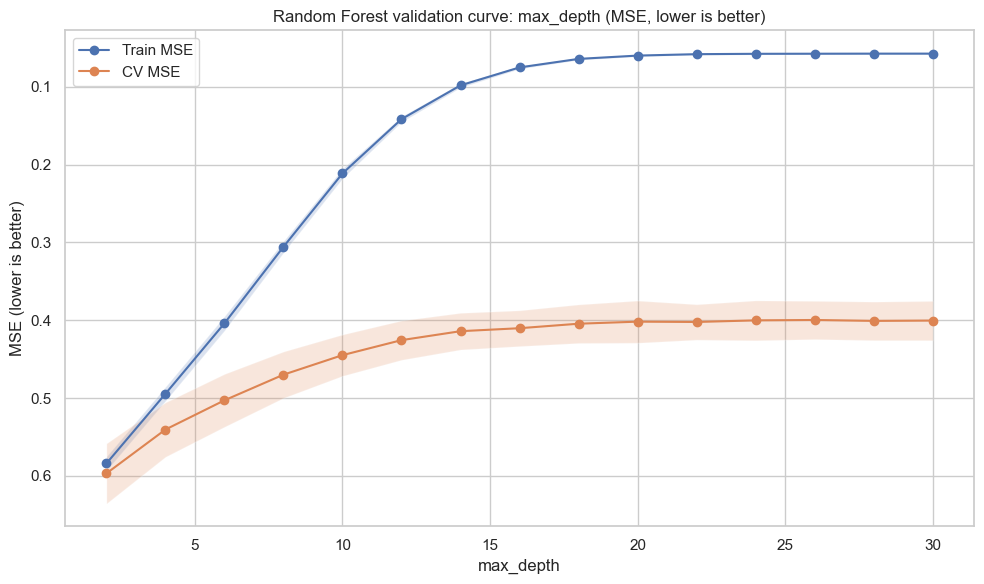

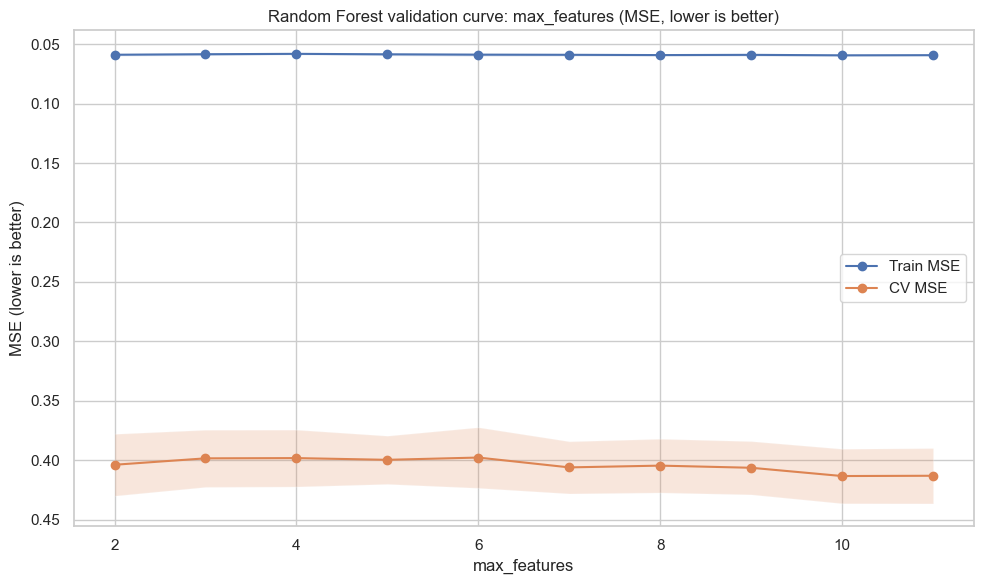

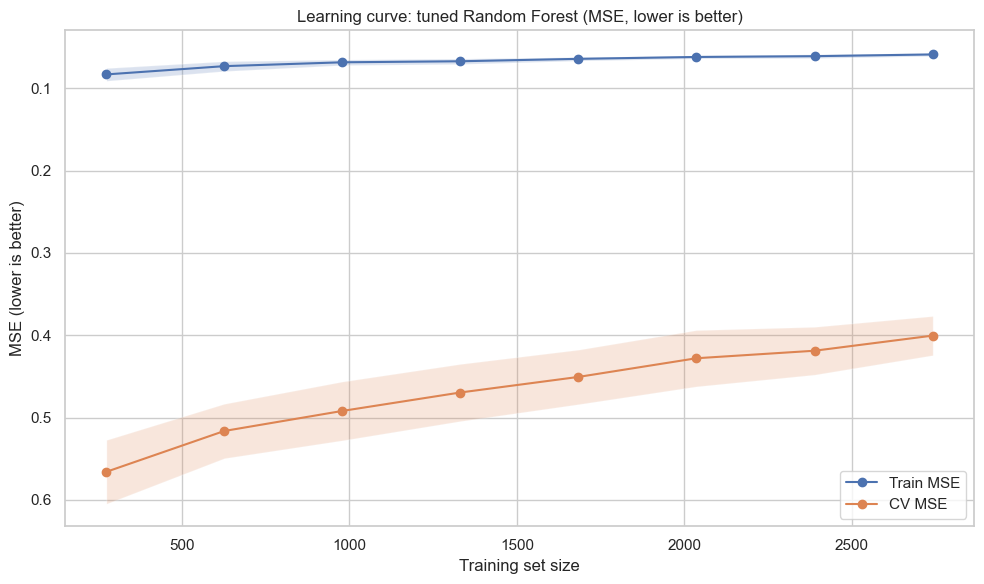

In [22]:
# Validation curve for Random Forest: max_depth
depth_range = list(range(2, 31, 2))

plot_validation_curve(
    best_rf, X_train, y_train,
    param_name="max_depth",
    param_range=depth_range,
    scoring="neg_mean_squared_error",
    cv=5,
    title="Random Forest validation curve: max_depth (MSE, lower is better)"
)

# Validation curve for Random Forest: max_features
feat_range = list(range(2, X_train.shape[1] + 1))  # 2..11
plot_validation_curve(
    best_rf, X_train, y_train,
    param_name="max_features",
    param_range=feat_range,
    scoring="neg_mean_squared_error",
    cv=5,
    title="Random Forest validation curve: max_features (MSE, lower is better)"
)

# Learning curve for the best model (tuned RF)
plot_learning_curve(
    best_rf, X_train, y_train,
    scoring="neg_mean_squared_error",
    cv=5,
    title="Learning curve: tuned Random Forest (MSE, lower is better)"
)


<details>
<summary><span style="color:red">about this block:</span></summary>  


### 1) Validation curve for `max_depth`

```python
depth_range = list(range(2, 31, 2))  # 2,4,6,...,30
```

This creates a list of candidate tree depths we want to test.

```python
plot_validation_curve(
    best_rf, X_train, y_train,
    param_name="max_depth",
    param_range=depth_range,
    scoring="neg_mean_squared_error",
    cv=5,
    title="Random Forest validation curve: max_depth (MSE, lower is better)"
)
```

Conceptually, this plot answers:

> “As I make trees deeper (more complex), do I get better generalization… or just more overfitting?”

<details>
<summary><span style="color:red">

More on `max_depth`:</span></summary>  

In a Random Forest, **`max_depth=2` means each decision tree is allowed to grow only 2 levels deep** (i.e., it can make only a small number of splits before stopping).

### Intuition

* A tree “depth” counts how many split layers we have from the root.
* **Depth = 0**: just a single node (predict the average quality), no splits.
* **Depth = 1**: one split → the tree has up to 2 leaves.
* **Depth = 2**: two split layers → the tree can have up to **4 leaves** (in the best case).

So with `max_depth=2`, each tree is extremely simple:

* it can only carve the feature space into a few coarse regions,
* which usually means **high bias / underfitting** (it can’t learn complex patterns).

### Why we see higher error at small depths

If wine quality depends on combinations like “high alcohol *and* low volatile acidity” or threshold effects, depth 2 can’t express that richness well, so both train and CV error tend to be high.

(And as depth increases, the model can represent more detailed rules, so training error drops and CV may improve until overfitting takes over.)

</details>

What happens under the hood:

* For each `max_depth` value in `depth_range`:

  * The code runs **5-fold cross-validation** on `X_train, y_train`.
  * In each fold:

    * Train the RF on 4/5 of the training data
    * Evaluate on the remaining 1/5
  * It computes:

    * **Train MSE** (error on the training fold)
    * **CV MSE** (error on the validation fold)

Why `scoring="neg_mean_squared_error"`:

* scikit-learn scoring assumes “higher is better”, so it returns **negative MSE**.
* Our plotting helper flips the sign back so the y-axis is **MSE** (lower is better).

So we end up with two curves:

* **Train MSE vs max_depth** (usually decreases as depth grows)
* **CV MSE vs max_depth** (improves until a point, then plateaus or worsens)


### 2) Validation curve for `max_features`

```python
feat_range = list(range(2, X_train.shape[1] + 1))  # 2..11
```

We have 11 features, so this tests `max_features` from 2 to 11.

```python
plot_validation_curve(
    best_rf, X_train, y_train,
    param_name="max_features",
    param_range=feat_range,
    scoring="neg_mean_squared_error",
    cv=5,
    title="Random Forest validation curve: max_features (MSE, lower is better)"
)
```

This plot answers:

> “How much randomness should we inject at each split?”

Reminder: in Random Forest,

* at **each split**, the tree considers only a subset of features of size `max_features`.
* smaller `max_features` ⇒ more randomness ⇒ often **less overfitting** (but sometimes more bias)
* larger `max_features` ⇒ less randomness ⇒ sometimes **stronger fit**, but can increase correlation among trees and overfit more easily

We said something similar earlier in this notebook:  
* **Smaller `max_features`** → more randomness → trees become **less similar** → averaging helps more → often **better generalization**, but can increase bias a bit.
* **Larger `max_features`** → less randomness → trees become **more similar** → can overfit more easily, but sometimes reduces bias.


So again we get train vs CV curves, but now as a function of **feature subsampling** instead of depth.


### 3) Learning curve for the tuned RF

```python
plot_learning_curve(
    best_rf, X_train, y_train,
    scoring="neg_mean_squared_error",
    cv=5,
    title="Learning curve: tuned Random Forest (MSE, lower is better)"
)
```

This plot answers:

> “If we give the model more training data, does performance keep improving?”

What happens:

* It chooses several training set sizes (e.g., 10%, 20%, …, 100% of `X_train`)
* For each size:

  * take that many samples from `X_train`
  * run **5-fold CV**
  * compute:

    * training MSE
    * validation (CV) MSE

Interpretation pattern:

* If **CV MSE keeps dropping** with more data → we’re **data-limited** (more data should help).
* If **CV MSE plateaus early** → we’re likely **model/feature-limited** (more data won’t help much).
* If the train–CV gap stays large → high variance / overfitting tendency (often true for flexible models like RF).

### One subtle but important note

All three plots use **only `X_train, y_train`** with cross-validation.
So they’re diagnostic tools that don’t “spend” the holdout set, good practice.

</details>

### **Validation curves + learning curve: what the diagnostics say**

#### **Validation curve (`max_depth`): where capacity stops buying accuracy**

The depth curve makes the bias–variance trade-off concrete:

- At **small depths (≈2–6)**, both train and CV MSE are high → classic **underfitting**.
- In the **mid-range (≈8–14)**, CV MSE improves noticeably → extra capacity helps.
- Past roughly **~14–18**, train MSE keeps dropping, but **CV MSE flattens** → diminishing returns.

> Beyond a moderate depth, extra complexity mostly memorizes training idiosyncrasies rather than improving out-of-sample prediction (generalization).

Notably, `GridSearchCV` selected **`max_depth=21`**, which sits in the *plateau region*: deep enough to capture structure, but past the point where additional depth meaningfully reduces CV error.

#### **Validation curve (`max_features`): a shallow optimum (broad plateau)**

The `max_features` curve is much flatter than depth:

- train MSE is low across the range (RF can fit training data well regardless),
- CV MSE varies only modestly, suggesting **RF isn’t extremely sensitive** to this knob here.

There’s a shallow “best region,” and the tuned choice **`max_features=6`** falls within that broadly good band, consistent with the idea that feature subsampling mainly acts as a variance-control dial rather than a make-or-break parameter.

#### **Learning curve: still data-limited, but the gap won’t vanish**

The learning curve reinforces the same message from a different angle:

- Train MSE stays very low even with fewer samples → RF can fit the training set extremely well.
- CV MSE steadily improves as training size grows → more data is still helping.

However, the train–CV gap remains large even at the largest training sizes. That suggests:
- **irreducible noise** (quality is a human rating), and/or
- the current features don’t fully capture what raters reward.

#### **So what should we do next?**  

1. **Don’t chase deeper trees.** After moderate depths, we mostly reduce train error, not CV error.
2. **Regularize at the leaf level if we want better generalization.** Consider `min_samples_leaf` and `min_samples_split` (these prevent tiny, overly-specific leaves).
3. **More data would still help.** CV improves with training size → partially data-limited.
4. **Feature work could matter too.** The persistent gap hints at noise and/or missing explanatory variables.

**Key takeaways**
- Depth shows a clear transition: **underfitting → improvement → plateau**.
- `max_features` shows a **broadly good band**, not a sharp optimum.
- The learning curve suggests we’re **still data-limited**, but noise/features impose a ceiling.


In [23]:
# --- Random Forest (tuned with GridSearchCV + leaf-level regularization) ---

param_grid = {
    "max_depth": list(range(10, 25)),          # same as before
    "max_features": list(range(4, 12)),        # you can keep 6..11 if you want
    "min_samples_leaf": [1, 2, 5, 10],
    "min_samples_split": [2, 5, 10, 20],
}

rf_base = RandomForestRegressor(
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_grid = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=5,
    n_jobs=-1,
    refit=True,
    verbose=1
)

rf_grid.fit(X_train, y_train)

best_rf = rf_grid.best_estimator_
best_params = rf_grid.best_params_
best_cv_mse = -rf_grid.best_score_

# Train / Holdout evaluation for the selected model
best_train_pred = best_rf.predict(X_train)
best_train_mse = mean_squared_error(y_train, best_train_pred)

best_holdout_pred = best_rf.predict(X_holdout)
best_holdout_mse = mean_squared_error(y_holdout, best_holdout_pred)

print("\nTuned RF (depth + features + leaf regularization) — best parameters:", best_params)
print("Tuned RF — CV MSE (from GridSearchCV): %.3f" % best_cv_mse)
print("Tuned RF — Train MSE:                 %.3f" % best_train_mse)
print("Tuned RF — Holdout MSE:               %.3f" % best_holdout_mse)


Fitting 5 folds for each of 1920 candidates, totalling 9600 fits

Tuned RF (depth + features + leaf regularization) — best parameters: {'max_depth': 21, 'max_features': 6, 'min_samples_leaf': 1, 'min_samples_split': 2}
Tuned RF — CV MSE (from GridSearchCV): 0.398
Tuned RF — Train MSE:                 0.054
Tuned RF — Holdout MSE:               0.366


<details>
<summary><span style="color:red">about this block</span></summary>  

### 1) Define the hyperparameter grid (what GridSearch will try)

```python
param_grid = {
    "max_depth": list(range(10, 25)),
    "max_features": list(range(4, 12)),
    "min_samples_leaf": [1, 2, 5, 10],
    "min_samples_split": [2, 5, 10, 20],
}
```

We’re telling `GridSearchCV`:

> “Try **every combination** of these values and pick the one with the best cross-validated MSE.”

What each parameter controls:

* **`max_depth`**: maximum depth of each tree.
  Larger depth → more complex trees → lower train error but higher overfitting risk.

* **`max_features`**: number of features considered *at each split*.
  Smaller `max_features` → more randomness across trees → typically **lower variance** (often better generalization).

* **`min_samples_split`**: minimum number of samples required to split an internal node.
  Larger values prevent “splitting on tiny subsets,” reducing variance.

* **`min_samples_leaf`**: minimum number of samples required to be at a leaf node.
  Larger values prevent tiny leaves (very specific rules), usually one of the **most effective** ways to regularize a forest.


### 2) Create the base model (the “template” estimator)

```python
rf_base = RandomForestRegressor(
    random_state=RANDOM_STATE,
    n_jobs=-1
)
```

This is the estimator GridSearch will clone many times.

* `random_state`: makes results reproducible.
* `n_jobs=-1`: use all CPU cores.

(Everything else stays default unless overridden by the grid.)


### 3) Wrap it in GridSearchCV

```python
rf_grid = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=5,
    n_jobs=-1,
    refit=True,
    verbose=1
)
```

This sets up the search:

* **`scoring="neg_mean_squared_error"`**: scikit-learn expects “higher is better,” so it returns *negative* MSE internally.
* **`cv=5`**: 5-fold cross-validation on the training set.
* **`n_jobs=-1`**: parallelize the whole search.
* **`refit=True`**: after it finds the best hyperparameters, it **refits a final model on the full training set** automatically.
* **`verbose=1`**: prints progress like “Fitting 5 folds for each of X candidates…”

### 4) Run the search (fit all candidates using CV)

```python
rf_grid.fit(X_train, y_train)
```

This is the heavy step.

Conceptually:

For each parameter combination:

1. Split `X_train` into 5 folds
2. Train on 4 folds, validate on 1 fold (repeat 5 times)
3. Average validation MSE across folds
4. Keep the best combination


### 5) Extract the best model + best CV score

```python
best_rf = rf_grid.best_estimator_
best_params = rf_grid.best_params_
best_cv_mse = -rf_grid.best_score_
```

* `best_estimator_`: the *refit* model trained on **all of `X_train`** using the best params.
* `best_params_`: the winning hyperparameter combination.
* `best_score_`: best mean CV score (negative MSE), so we flip the sign to get **CV MSE**.


### 6) Evaluate the selected model on train + holdout

```python
best_train_pred = best_rf.predict(X_train)
best_train_mse = mean_squared_error(y_train, best_train_pred)

best_holdout_pred = best_rf.predict(X_holdout)
best_holdout_mse = mean_squared_error(y_holdout, best_holdout_pred)
```

This gives us:

* **Train MSE**: how well it fits the training data (often *very low* for forests).
* **Holdout MSE**: a one-time “unseen data” check (our sanity check).

Important: the holdout set is **not used** in the GridSearchCV tuning, only in this final check.


### 7) Print summary

```python
print("\nTuned RF (depth + features + leaf regularization) — best parameters:", best_params)
print("Tuned RF — CV MSE (from GridSearchCV): %.3f" % best_cv_mse)
print("Tuned RF — Train MSE:                 %.3f" % best_train_mse)
print("Tuned RF — Holdout MSE:               %.3f" % best_holdout_mse)
```

We’re reporting:

* what the search selected,
* how it generalizes *in CV*,
* how much it overfits (train vs CV),
* and whether that CV story holds on our holdout.


### One key interpretation (based on our outcome)

GridSearch still chose:

* `min_samples_leaf = 1`
* `min_samples_split = 2`

That means:

> given our dataset and the grid we tried, CV did **not** find evidence that leaf-level regularization improves generalization beyond tuning `max_depth` and `max_features`.

So adding these knobs was still a **good diagnostic move**, it confirmed that depth/feature subsampling was the main lever (for this dataset + this evaluation setup), and extra regularization didn’t buy us more.

</details>

### **Leaf-level regularization: did it help?**

Based on the validation/learning curves, a natural next idea is to regularize *inside* the trees, preventing very small leaves and very small splits.

We expanded the RF grid to include:
- `min_samples_leaf`
- `min_samples_split`

In this run, the best configuration stayed at:
- `min_samples_leaf=1`
- `min_samples_split=2`

…and performance remained essentially unchanged (CV MSE ≈ 0.398, holdout MSE ≈ 0.366).

**Interpretation:** within this search space, leaf-level regularization didn’t buy extra generalization. That can mean:
- the earlier tuning already captured most of the gain, and/or
- we’d need a broader/more targeted search (or randomized search) to see improvements.

If we wanted to push further, high-leverage next steps would be:
- increasing `n_estimators` (more trees → more stable averaging),
- exploring wider leaf/split ranges,
- and trying boosted trees (XGBoost/LightGBM/CatBoost) as the next model family.

> In scikit-learn, the default value of `n_estimators` in `RandomForestRegressor` is: `n_estimators = 100` (i.e., 100 trees in the forest). Usually, tuning `n_estimators` doesn’t “fix overfitting” in the way `max_depth` or `min_samples_leaf` does, but it *can* improve generalization a bit by reducing variance (making the model’s predictions more stable).

## **8) Final model comparison + conclusion**

Up to this point we’ve reasoned model-by-model: baseline → linear transparency → regularization → non-linear capacity.  
The last step is to **put everything on one scoreboard** so the conclusion is driven by consistent metrics, not narrative momentum.

The next cell:
- collects all models into a single comparison table,
- **sorts by 5-fold CV MSE** (our primary selection signal),
- adds **CV RMSE** ($\sqrt{\text{CV MSE}}$) so error is readable in **quality points**,
- and visualizes results with a **bar chart of CV RMSE**.

### **How to read the metrics**
- **CV MSE / CV RMSE:** the main ranking signal (more stable than a single split).
- **Holdout metrics:** a one-time sanity check (should broadly agree with CV).
- **Train vs CV/holdout:** a quick read on overfitting/variance.
- **MAE / RMSE:** easier-to-interpret error sizes in the same units as the target.
- **$R^2$:** improvement over predicting the mean.

> **Note:** `cv_mse_std` is available for the default RF because we computed fold scores via `cross_val_score`.  
> For the tuned RF we use `GridSearchCV.best_score_` (mean CV MSE), so `cv_mse_std` is left as `NaN` unless we extract fold-level values from `cv_results_`.

**Key takeaways**
- A single comparison table prevents “narrative drift” and keeps conclusions grounded.
- Sorting by CV error makes the winner defensible: it performs best **across folds**, not just on one holdout split.
- The final choice should reflect both **performance** and the interpretability evidence (permutation importance, PDP, SHAP), so we pick the most defensible model, not just the lowest number.


Model comparison (sorted by CV MSE):
                 model  cv_mse  cv_rmse  train_mse  holdout_mse  holdout_rmse  holdout_mae  holdout_r2
            RF (tuned)  0.3979   0.6308     0.0543       0.3658        0.6048       0.4365      0.5304
          RF (default)  0.4143   0.6437     0.0527       0.3708        0.6089       0.4408      0.5240
 LassoCV (tuned alpha)  0.5604   0.7486     0.5581       0.5833        0.7637       0.5938      0.2511
OLS (LinearRegression)  0.5605   0.7486     0.5581       0.5842        0.7644       0.5939      0.2499
    Lasso (alpha=0.01)  0.5656   0.7521     0.5638       0.5737        0.7574       0.5933      0.2635
       Baseline (mean)  0.7866   0.8869     0.7865       0.7789        0.8825       0.6809     -0.0000


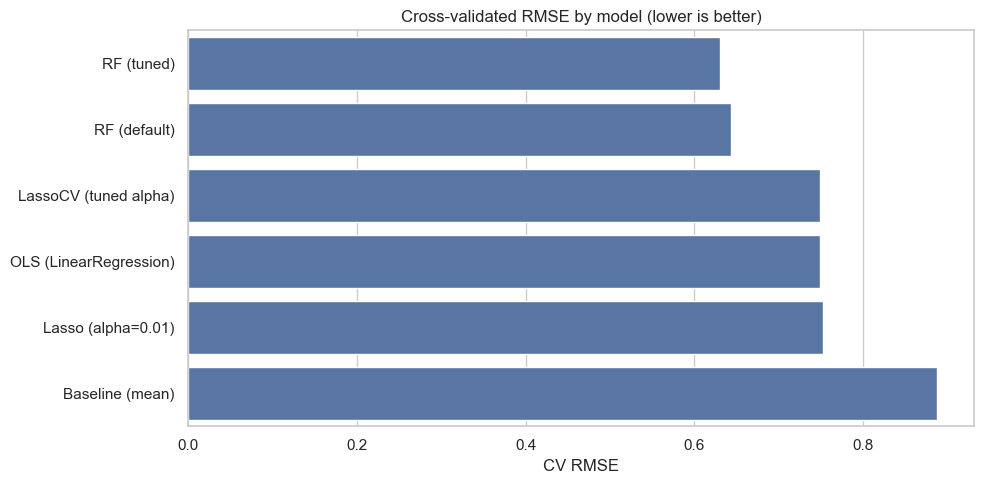

In [24]:
# Collect results into one comparison table
results = []

results.append(baseline_results)
results.append(ols_results)
results.append(lasso001_results)
results.append(lasso_cv_results)

# RF default metrics in the same schema
rf_default_results = {
    "model": "RF (default)",
    "train_mse": rf_default_train_mse,
    "holdout_mse": rf_default_holdout_mse,
    "holdout_rmse": np.sqrt(rf_default_holdout_mse),
    "holdout_mae": mean_absolute_error(y_holdout, rf_default_holdout_pred),
    "holdout_r2": r2_score(y_holdout, rf_default_holdout_pred),
    "cv_mse": rf_default_cv_mse,
    "cv_mse_std": rf_default_cv_scores.std(),
}
results.append(rf_default_results)

# RF tuned metrics
best_rf_train_pred = best_rf.predict(X_train)
best_rf_train_mse = mean_squared_error(y_train, best_rf_train_pred)

rf_tuned_results = {
    "model": "RF (tuned)",
    "train_mse": best_rf_train_mse,
    "holdout_mse": best_holdout_mse,
    "holdout_rmse": np.sqrt(best_holdout_mse),
    "holdout_mae": mean_absolute_error(y_holdout, best_holdout_pred),
    "holdout_r2": r2_score(y_holdout, best_holdout_pred),
    "cv_mse": best_cv_mse,
    "cv_mse_std": np.nan,
}
results.append(rf_tuned_results)

comparison = pd.DataFrame(results)

# Add CV RMSE for interpretability (same units as target)
comparison["cv_rmse"] = np.sqrt(comparison["cv_mse"])

# Make the table easier to read + sort by CV MSE (primary selection metric)
cols = ["model", "cv_mse", "cv_rmse", "train_mse", "holdout_mse", "holdout_rmse", "holdout_mae", "holdout_r2"]
comparison = comparison[cols].sort_values("cv_mse").reset_index(drop=True)

print_df(comparison, title="Model comparison (sorted by CV MSE):")

# Visualize cross-validated RMSE (often easier to interpret than MSE)
plt.figure(figsize=(10, 5))
sns.barplot(data=comparison, x="cv_rmse", y="model")
plt.title("Cross-validated RMSE by model (lower is better)")
plt.xlabel("CV RMSE")
plt.ylabel("")
plt.tight_layout()
plt.show()


<details>
<summary><span style="color:red">about this block:</span></summary>   

### 1) Start a list that will hold one “results dict” per model

```python
results = []

results.append(baseline_results)
results.append(ols_results)
results.append(lasso001_results)
results.append(lasso_cv_results)
```

* `baseline_results`, `ols_results`, `lasso001_results`, `lasso_cv_results` are dictionaries returned by our `evaluate_regression(...)` helper.
* Each dict already has metrics like `cv_mse`, `train_mse`, `holdout_mse`, etc.
* We’re building a single list `results` that will later become a table.


### 2) Manually create a results dict for **RF (default)** in the same schema

```python
rf_default_results = {
    "model": "RF (default)",
    "train_mse": rf_default_train_mse,
    "holdout_mse": rf_default_holdout_mse,
    "holdout_rmse": np.sqrt(rf_default_holdout_mse),
    "holdout_mae": mean_absolute_error(y_holdout, rf_default_holdout_pred),
    "holdout_r2": r2_score(y_holdout, rf_default_holdout_pred),
    "cv_mse": rf_default_cv_mse,
    "cv_mse_std": rf_default_cv_scores.std(),
}
results.append(rf_default_results)
```

Because our RF code didn’t use `evaluate_regression(...)`, we manually assemble the same set of fields:

* **train_mse**: MSE on training data
* **holdout_mse**: MSE on the holdout set
* **holdout_rmse**: √MSE (in “quality points”)
* **holdout_mae**: average absolute error on holdout
* **holdout_r2**: how much variance we explain vs predicting the mean
* **cv_mse**: mean CV MSE from `cross_val_score`
* **cv_mse_std**: *std of the fold MSEs* (how variable performance is across folds)

Then we append it to `results`.


### 3) Create a results dict for **RF (tuned)**

```python
best_rf_train_pred = best_rf.predict(X_train)
best_rf_train_mse = mean_squared_error(y_train, best_rf_train_pred)
```

* `best_rf` is our tuned model from GridSearchCV (`best_estimator_`).
* We compute its **training MSE** explicitly.

Then:

```python
rf_tuned_results = {
    "model": "RF (tuned)",
    "train_mse": best_rf_train_mse,
    "holdout_mse": best_holdout_mse,
    "holdout_rmse": np.sqrt(best_holdout_mse),
    "holdout_mae": mean_absolute_error(y_holdout, best_holdout_pred),
    "holdout_r2": r2_score(y_holdout, best_holdout_pred),
    "cv_mse": best_cv_mse,
    "cv_mse_std": np.nan,
}
results.append(rf_tuned_results)
```

Same metrics, but:

* `cv_mse` comes from GridSearchCV’s best mean CV score.
* `cv_mse_std` is set to `NaN` because we didn’t extract fold-by-fold values from `rf_grid.cv_results_` (GridSearchCV *does* store enough to compute variability, but it’s not in a single variable like `rf_default_cv_scores`).


### 4) Turn the list of dicts into a DataFrame

```python
comparison = pd.DataFrame(results)
```

Now we have a table where each row is a model and each column is a metric.


### 5) Add a more interpretable CV metric: **CV RMSE**

```python
comparison["cv_rmse"] = np.sqrt(comparison["cv_mse"])
```

* CV MSE is in **(quality points)²**
* CV RMSE is back in **quality points**
* So “0.63” reads like “off by ~0.63 quality points on average”.


### 6) Select columns + sort by CV MSE (our primary ranking)

```python
cols = ["model", "cv_mse", "cv_rmse", "train_mse", "holdout_mse", "holdout_rmse", "holdout_mae", "holdout_r2"]
comparison = comparison[cols].sort_values("cv_mse").reset_index(drop=True)
```

* We keep only the columns we care about (in a nice order).
* We sort by **`cv_mse`** so the “best generalizer” is at the top.
* We reset the index so the table shows ranks cleanly.

Then we display it:

```python
print_df(comparison, title="Model comparison (sorted by CV MSE):")
```

### 7) Plot a quick visual ranking using CV RMSE

```python
sns.barplot(data=comparison, x="cv_rmse", y="model")
```

This draws a horizontal bar chart where:

* x-axis = CV RMSE (lower is better)
* y-axis = model names
  So we can visually see the gap between RF and linear models.

#### Tiny optional improvement (pure presentation)

If you want the bars to be in the same order as the table every time, you can do:

```python
sns.barplot(data=comparison, x="cv_rmse", y="model", order=comparison["model"])
```

Not required, but it guarantees consistent ordering.

</details>

<details>
<summary><span style="color:red"> Why we plot RMSE (even though we optimize MSE):</span></summary>  

In the tables above we report **MSE** because it’s the standard loss for regression and it’s what scikit-learn uses for scoring (`neg_mean_squared_error`). But for human interpretation, we often prefer **RMSE**:

* **MSE** is measured in **squared units**.
  Since `quality` is in “quality points,” MSE is in **(quality points)²**, which is hard to interpret directly.

* **RMSE = √MSE** brings the error back to the **same units as the target** (quality points).
  That makes it easier to communicate model accuracy as a typical prediction error.

Example:
If **RMSE = 0.63**, we can say:

> “On average, predictions are off by about **0.63 quality points**.”

This is why it’s common to:

* **optimize/report MSE** (standard and convenient for training/scoring),
* but **visualize RMSE** (more interpretable in the original units).

</details>

## **Conclusion: what we learned (and what we’d ship)**

In this project we follow a simple arc: **baseline → linear transparency → regularization checks → non-linear power**, with consistent evaluation and model-appropriate interpretability.

### **1) Performance summary (CV first, holdout as sanity check)**

From the final comparison table:

- **Baseline:** CV RMSE ≈ **0.887**
- **Linear models (OLS / LassoCV):** CV RMSE ≈ **0.749**
- **Tuned Random Forest:** CV RMSE ≈ **0.631** (best), with holdout $R^2$ ≈ **0.53**

That gap is large enough (and consistent enough in CV) to strongly suggest that wine quality depends on **non-linear structure and/or interactions** that linear models can’t capture unless we explicitly add deliberate feature engineering (polynomials, interactions, or monotonic transforms).

> $R^2$ ≈ **0.53** means the tuned Random Forest explains about 53% of the variance in holdout wine-quality scores relative to a naive “predict-the-mean” baseline.


### **2) What each model taught us** 

- **OLS** gave a clean interpretability baseline: quick directionality and a strong first approximation.
- **Lasso** added useful diagnostics around redundancy and stability, but CV chose a very small α, so the best regularized linear model looked almost like OLS.
- **Random Forest** delivered the major accuracy gain and exposed non-linear effect shapes (via PDP) and per-wine attribution patterns (via SHAP).

### **3) What we’d ship (and how we’d explain it)**  

If prediction accuracy is the goal, the defensible choice here is the **tuned Random Forest**, paired with:
- **Permutation importance** for “impact on error” rankings,
- **PDP (Partial Dependence Plots)** for a lightweight global shape check,
- **SHAP** for global + local explanations that tell us *why* a particular wine got its score.

### **Limitations and next steps**  

- The target is an integer score; we model it as continuous (fine for MSE/RMSE, but not perfect).
- Duplicates exist (~19%); they can inflate metrics if they cross folds/splits.
- For production-quality estimates, we’d use **repeated splits** or **nested CV** (especially for hyperparameter tuning).

Next modeling steps:
- more trees (`n_estimators`) for stability,
- a broader RF hyperparameter search (or randomized search),
- and gradient-boosted trees as the next high-leverage family.

### **Key takeaways**  

- **CV is the decision metric:** it’s why we can confidently say RF “wins,” not just on one holdout split.
- **Interpretability should match the model:** coefficients for linear models; permutation/PDP/SHAP for RF.
- This project workflow isn’t “fit + score”, it’s **data → hypotheses → models → diagnostics → decision**, with the final choice justified by both **numbers** and **behavioral evidence**.
